In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier
import optuna
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from library.Data_Preprocessing import Balance_Ratio
from library.Imbalance_Sampling import label_divide, under_over, over_under, resampling_dataset
from library.Aging_Score_Contour import score1
from library.AdaBoost import train_set, multiple_set, multiple_month, line_chart, cf_matrix, all_optuna, optuna_history

os.chdir('C:/Users/user/Desktop/Darui_R08621110') 
os.getcwd()

'C:\\Users\\user\\Desktop\\Darui_R08621110'

## 

### Balance Cascade

In [2]:
# train & test of balance cascade (scheme 1 & 2)
class BalanceCascade:
    
    def __init__(self, base_clf = 'LightGBM', num_iter = 10, over_method = None, under_method = 'NM', 
                 over_num = 5, verbose = True):
        self.classifier = base_clf
        self.num_iter = num_iter
        self.over_method = over_method
        self.under_method = under_method
        self.over_num = over_num if over_method else 1
        self.verbose = verbose
        if over_method not in ['ADASYN', 'SMOTEN', None]:
            raise Exception(f'{over_method} is not implemented !') 
        if under_method not in ['NM', 'random']:
            raise Exception(f'{under_method} is not implemented !') 
        if base_clf not in ['LightGBM', 'RandomForest']:
            raise Exception(f'{base_clf} is not implemented !') 
    
    
    def training(self, train_data, clf_config):
        origin_good = train_data[train_data.GB == 0]
        origin_bad = train_data[train_data.GB == 1] 
        br_0 = (len(origin_bad)*self.over_num) / len(origin_good)
        false_rate = br_0**(1/(self.num_iter - 1))
        
        keep_bad = origin_bad.copy()
        keep_good = {0: origin_good.copy()}
        br_list = []
        clf_threshold = []
        clf_cascade = {}
        for j in range(self.num_iter):
            temp_train = pd.concat([keep_good[j], keep_bad], axis = 0)
            temp_br = len(keep_bad) / len(keep_good[j])
            br_list.append(temp_br)
            print(f'\nIteration {j+1}:')
            
            # oversampling
            if all([self.over_method, temp_br < 1]):
                over_ratio = temp_br*self.over_num
                over_X, over_Y = under_over(temp_train, self.over_method, None, over_ratio, 0)
                over_sample = pd.concat([over_X, over_Y], axis = 1)
                over_sample = over_sample.rename({0: 'GB'}, axis = 'columns')
                over_bad = over_sample[over_sample.GB == 1]
            else:
                over_bad = keep_bad.copy()
                if all([self.verbose, not self.over_method]):
                    print('Stop Oversampling !')
            
            # undersampling
            if all([j != self.num_iter - 1, len(keep_good[j]) > len(over_bad)]):
                under_ratio = 1/self.over_num
                under_X, under_Y = over_under(temp_train, None, self.under_method, 0, under_ratio)
                under_sample = pd.concat([under_X, under_Y], axis = 1)
                under_good = under_sample[under_sample.GB == 0]
            else:
                under_good = keep_good[j].copy()
                if self.verbose:
                    print('Stop Undersampling !')
            train_combine = pd.concat([over_bad, under_good], axis = 0)
            
            # train the base learner, find the threshold, and discard the redundant good instances
            valid_good = keep_good[j].copy()
            train_x, train_y, valid_x, valid_y = label_divide(train_combine, valid_good, 'GB', train_only = False)
            if self.classifier == 'LightGBM':
                clf = LGBMClassifier(**clf_config)
            elif self.classifier == 'RandomForest':
                clf = RandomForestClassifier(**clf_config)
            clf.fit(train_x, train_y)
            predict = clf.predict_proba(valid_x)[:, 1]
            predict_df = pd.DataFrame(dict(predict = predict), index = valid_x.index)
            predict_df = predict_df.sort_values(by = 'predict', ascending = False)
            keep_num = int(len(predict_df)*false_rate) + 1
            keep_index = predict_df.index[:keep_num]
            threshold = predict_df.loc[keep_index[-1]].values[0]
            clf_threshold.append(threshold)
            clf_cascade[j] = clf
            
            if j != (self.num_iter - 1):
                keep_good[j+1] = keep_good[j].loc[keep_index].copy()        
        self.good_data = keep_good
        self.bad_data = keep_bad
        self.threshold = clf_threshold
        self.cascade = clf_cascade
        self.balance_ratio = br_list
    
    
    def testing(self, test_data):
        clf_cascade = self.cascade
        if isinstance(self.threshold, int):
            clf_threshold = [self.threshold]*len(clf_cascade)
        else:
            clf_threshold = self.threshold

        test_x, test_y = label_divide(test_data, 'GB', train_only = True)
        predict_df = pd.DataFrame()
        for i in range(len(clf_cascade)):
            clf = clf_cascade[i]
            predict = clf.predict_proba(test_x)[:, 1]
            answer = (predict > clf_threshold[i]).astype(int)
            predict = pd.DataFrame({str(i): answer})
            predict_df = pd.concat([predict_df, predict], axis = 1)
        predict_y = (predict_df.apply(sum, axis = 1) == len(clf_cascade)).astype(int)
        result = pd.DataFrame(dict(predict = predict_y, truth = test_y))

        return result


# run all resampling datasets
def runall_cascade(train_set, test_data, base_config, base_clf = 'LightGBM', num_iter = 10, meta_config = None):
    
    num_set = len(train_set)
    table_set = pd.DataFrame()
    for i in range(1, num_set):
        print('\n', f'Dataset {i}:')
        if isinstance(meta_config, dict):
            BC = BalanceCascade(base_clf = base_clf, **meta_config[f'set{i}'])
        else:
            BC = BalanceCascade(base_clf = base_clf, num_iter = num_iter)
        BC.training(train_set[f'set{i}'], base_config[f'set{i}'])
        result = BC.testing(test_data)
        table = cf_matrix(result, train_set[f'set{i}'].GB)
        table_set = pd.concat([table_set, table]).rename(index = {0: f'dataset {i}'})
    
    return table_set

### Optuna

In [3]:
# creator of optuna study for balance cascade
def BalanceCascade_creator(train_data, mode, num_valid = 3, label = 'GB') :

    def objective(trial) :
    
        base_param = {
            'n_estimators': trial.suggest_categorical('n_estimators', [100, 300, 500, 1000]),
            'learning_rate': trial.suggest_float('learning_rate', 0.025, 0.325, step = 0.05),
            'max_depth': trial.suggest_int('max_depth', 3, 12, step = 3),
            'num_leaves': trial.suggest_int('num_leaves', 10, 130, step = 20),
            'min_child_samples': trial.suggest_categorical('min_child_samples', [10, 50, 100, 500, 1000, 5000]),
            'min_split_gain': trial.suggest_int('min_split_gain', 0, 12, step = 2),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.9, step = 0.2),
            'subsample': trial.suggest_float('subsample', 0.3, 0.9, step = 0.2),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10), # alpha
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10) # lambda
        }
        
        num_iter = 15 if mode == 1 else 10
        over_num = 5
        meta_param = {
            'num_iter': trial.suggest_int('num_iter', num_iter, num_iter, step = 5),
            'over_num': trial.suggest_int('over_num', over_num, over_num, step = 5),
            'over_method': trial.suggest_categorical('over_method', ['ADASYN']),
            'under_method': trial.suggest_categorical('under_method', ['NM'])
        }  

        result_list = []
        for i in range(num_valid):

            train_good = train_data[train_data.GB == 0]
            train_bad = train_data[train_data.GB == 1]
            train_good_x, train_good_y = label_divide(train_good, None, label, train_only = True)
            train_bad_x, train_bad_y = label_divide(train_bad, None, label, train_only = True)
            train_g_x, valid_g_x, train_g_y, valid_g_y = train_test_split(train_good_x, train_good_y, test_size = 0.25)
            train_b_x, valid_b_x, train_b_y, valid_b_y = train_test_split(train_bad_x, train_bad_y, test_size = 0.25)
            train_x = pd.concat([train_g_x, train_b_x], axis = 0)
            train_y = pd.concat([train_g_y, train_b_y], axis = 0)
            valid_x = pd.concat([valid_g_x, valid_b_x], axis = 0)
            valid_y = pd.concat([valid_g_y, valid_b_y], axis = 0)
            all_train = pd.concat([train_x, train_y], axis = 1)
            all_valid = pd.concat([valid_x, valid_y], axis = 1)

            if mode == 1:
                BC = BalanceCascade(num_iter = meta_param['num_iter'], under_method = meta_param['under_method'])
            elif mode == 2:
                BC = BalanceCascade(num_iter = meta_param['num_iter'], over_method = meta_param['over_method'], 
                                    under_method = meta_param['under_method'], over_num = meta_param['over_num'])
            BC.training(all_train, base_param)
            result = BC.testing(all_valid)
            table = cf_matrix(result, valid_y)
            recall = table['Recall'].values
            precision = table['Precision'].values
            beta = 1
            if recall > 0:
                fscore = ((1+beta**2)*recall*precision) / (recall+(beta**2)*precision) 
            else:
                fscore = 0
            result_list.append(fscore)

        return np.mean(result_list)
    return objective

### Full Experiment

In [8]:
def full_balancecascade(train_month, times, scheme):
    prob_dict = dict()
    result_df = pd.DataFrame()

    # load relabel datasets
    runhist = {}
    kinds = {}
    for i in train_month:
        runhist[f'm{i}'] = pd.read_csv(f'relabel_runhist_m{i}.csv', index_col = 'id').iloc[:, 1:]
        kinds[f'm{i}'] = pd.read_csv(f'kind_m{i}.csv').iloc[:, 2:-3]

    # do several times to average the random effect of resampling
    for i in tqdm(range(times)):
        # generate resampled datasets
        if scheme == 1:
            final_br, num_os = 0.1, 5
        elif scheme == 2:
            final_br, num_os = 0.05, 5
        resampling_dataset(runhist = runhist, kinds = kinds, train_month = train_month, 
                           final_br = final_br, num_os = num_os)

        # load & prepare the resampled datasets 
        all_train = multiple_set(num_set = 10)
        all_train_x, all_train_y = train_set(all_train)
        all_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
        all_test_x, all_test_y = label_divide(all_test, None, 'GB', train_only = True)
        
        # searching for hyperparameters
        best_param, _ = all_optuna(all_data = all_train, 
                                   mode = scheme, 
                                   TPE_multi = False, 
                                   n_iter = 25,
                                   filename = f'runhist_array_m2m4_m5_3criteria_BalanceCascade{scheme}-{i}',
                                   creator = BalanceCascade_creator
                                  )

        meta_item = ['num_iter', 'over_num', 'over_method', 'under_method']
        base_param, meta_param = {}, {}
        for k in range(1, len(all_train)):
            base_param.update({f'set{k}': {}})
            meta_param.update({f'set{k}': {}})
            [base_param[f'set{k}'].update({a: b}) for (a, b) in best_param[f'set{k}'].items() if a not in meta_item]
            [meta_param[f'set{k}'].update({a: b}) for (a, b) in best_param[f'set{k}'].items() if a in meta_item]
        
        # store the probability predicted by the classifier 
        for j in best_param.keys():
            if i == 0:
                prob_dict[j] = pd.DataFrame()
            
            if scheme == 1:
                BC = BalanceCascade(num_iter = meta_param[j]['num_iter'], over_method = None, over_num = 5,
                                    under_method = meta_param[j]['under_method'])
            elif scheme == 2:
                BC = BalanceCascade(num_iter = meta_param[j]['num_iter'], over_method = meta_param[j]['over_method'], 
                                    under_method = meta_param[j]['under_method'], over_num = meta_param[j]['over_num'])
            BC.training(all_train[j], base_param[j])
            table = BC.testing(all_test)
            prob_dict[j] = pd.concat([prob_dict[j], table[['predict']]], axis = 1)
            
    # average to get final prediction
    for j in best_param.keys():
        prediction = (prob_dict[j].apply(np.sum, axis = 1) >= times*0.5).astype(int)
        result = pd.DataFrame(dict(truth = all_test_y, predict = prediction))
        table = cf_matrix(result, all_train_y[j])
        result_df = pd.concat([result_df, table]).rename(index = {0: f'data{j}'})
        
    return result_df

## 

### For a Run

#### Resample & Load Data

In [ ]:
training_month = range(2, 5)

### load relabeled data & kinds ###
runhist = {}
kinds = {}
for i in training_month:
    runhist[f'm{i}'] = pd.read_csv(f'relabel_runhist_m{i}.csv', index_col = 'id').iloc[:, 1:]
    kinds[f'm{i}'] = pd.read_csv(f'kind_m{i}.csv').iloc[:, 2:-3]

### resample 10 datasets ###
resampling_dataset(runhist = runhist, kinds = kinds, train_month = training_month, final_br = 0.1, num_os = 5)
# scheme 1: final_br = 0.1, num_os = 5
# scheme 2: final_br = 0.05, num_os = 5

In [4]:
### training data ###
data_dict, trainset_x, trainset_y = multiple_month(training_month, num_set = 10, filename = 'dataset')

print('\nCombined training data:\n')
run_train = multiple_set(num_set = 10)
run_train_x, run_train_y = train_set(run_train)

### testing data ###
run_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
run_test_x, run_test_y = label_divide(run_test, None, 'GB', train_only = True)
print('\n', 'Dimension of testing data:', run_test.shape)


Month 2:

Dimension of dataset 0 : (39009, 88)  balance ratio: 564.35
Dimension of dataset 1 : (7245, 88)  balance ratio: 20.0
Dimension of dataset 2 : (7182, 88)  balance ratio: 20.0
Dimension of dataset 3 : (7224, 88)  balance ratio: 20.0
Dimension of dataset 4 : (7224, 88)  balance ratio: 20.0
Dimension of dataset 5 : (7233, 88)  balance ratio: 20.72
Dimension of dataset 6 : (7242, 88)  balance ratio: 20.18
Dimension of dataset 7 : (7242, 88)  balance ratio: 20.18
Dimension of dataset 8 : (7245, 88)  balance ratio: 20.0
Dimension of dataset 9 : (1449, 88)  balance ratio: 20.0

 10 datasets are loaded.

Labels of  10 datasets are divided.

Month 3:

Dimension of dataset 0 : (60396, 97)  balance ratio: 533.48
Dimension of dataset 1 : (12054, 97)  balance ratio: 20.0
Dimension of dataset 2 : (11718, 97)  balance ratio: 20.0
Dimension of dataset 3 : (11844, 97)  balance ratio: 20.0
Dimension of dataset 4 : (11844, 97)  balance ratio: 20.0
Dimension of dataset 5 : (11849, 97)  balance r

#### Search for The Best Hyperparameters

In [26]:
best_paramC, all_scoreC = all_optuna(all_data = run_train, 
                                     mode = 2, 
                                     TPE_multi = False, 
                                     n_iter = 50,
                                     filename = 'runhist_array_m2m4_m5_3criteria_BalanceCascade',
                                     creator = BalanceCascade_creator
                                    )

meta_item = ['num_iter', 'over_num', 'over_method', 'under_method']
base_paramC = {}
meta_paramC = {}
for i in range(1, len(run_train)):
    base_paramC.update({f'set{i}': {}})
    meta_paramC.update({f'set{i}': {}})
    [base_paramC[f'set{i}'].update({a: b}) for (a, b) in best_paramC[f'set{i}'].items() if a not in meta_item]
    [meta_paramC[f'set{i}'].update({a: b}) for (a, b) in best_paramC[f'set{i}'].items() if a in meta_item]

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-03-28 11:42:26,773] A new study created in memory with name: no-name-f4ac4f6d-d7d8-4eb9-b320-c1cc763415ad


Dataset 1 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]


Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28920
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25609
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22735
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20310
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18334
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16523
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14931
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13687
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12526
Size after Undersampling: 6936

Iteration 10:
Size before Ove


Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20361
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18287
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16428
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14917
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13677
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12494
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11562
Stop Undersampling !
Precision: 0.04208416833667335 
Recall: 0.25925925925925924 
Aging Rate: 0.24825870646766168

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28896
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size afte

Size before Oversampling: 10335
Size after Oversampling: 14989
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13687
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12528
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11574
Stop Undersampling !
Precision: 0.04631578947368421 
Recall: 0.25287356321839083 
Aging Rate: 0.2382146439317954

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28927
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25624
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22805
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20398
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling:

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:105: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.0029055690072639223
[I 2022-03-28 11:48:14,302] Trial 5 finished with value: 0.030956498152103887 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07500000000000001, 'max_depth': 12, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 0.11395789242035152, 'reg_lambda': 0.7824330620450818, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 3 with value: 0.07414560144544634.

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28945
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25605
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22811
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20322
Size after Undersampling: 6936

Iteration 5:
Size before Ov


Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28919
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25651
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22740
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20410
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18342
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16491
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14935
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13619
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12498
Size after Undersampling: 6936

Iteration 10:
Size before Ove

Size after Oversampling: 20313
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18258
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16483
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 15003
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13679
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12550
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11597
Stop Undersampling !
Precision: 0.024640657084188913 
Recall: 0.15384615384615385 
Aging Rate: 0.24325674325674326

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28908
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25616
Size after Undersamplin

Size after Oversampling: 14971
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13628
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12528
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11529
Stop Undersampling !
Precision: 0.04036697247706422 
Recall: 0.22916666666666666 
Aging Rate: 0.2575614366729679

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28950
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25541
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22808
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20385
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18266
Size after Undersampling:

Precision: 0.03522504892367906 
Recall: 0.20689655172413793 
Aging Rate: 0.2571716155007549

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28906
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25650
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22809
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20322
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18242
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16502
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 15019
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13627
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902



Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22747
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20337
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18240
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16483
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14986
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13627
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12516
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11546
Stop Undersampling !
Precision: 0.045454545454545456 
Recall: 0.011235955056179775 
Aging Rate: 0.01104417670682731

Iteration 1:
Size before Oversampling: 24286
Size af

Size after Oversampling: 18251
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16514
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14986
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13687
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12546
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11602
Stop Undersampling !
Precision: 0.029850746268656716 
Recall: 0.17582417582417584 
Aging Rate: 0.2605736509479825

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28910
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25640
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22770
Size after Undersampling


Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13609
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12569
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11625
Stop Undersampling !
Precision: 0.026615969581749048 
Recall: 0.175 
Aging Rate: 0.25911330049261083

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28906
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25548
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22821
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20374
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18279
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversamplin

Precision: 0.03870967741935484 
Recall: 0.21176470588235294 
Aging Rate: 0.23273273273273273

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28919
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25672
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22767
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20359
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18239
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16509
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14891
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13700
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902


Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22743
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20302
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18310
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16463
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14935
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13680
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12539
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11554
Stop Undersampling !
Precision: 0.05154639175257732 
Recall: 0.28735632183908044 
Aging Rate: 0.24470232088799193
[I 2022-03-28 12:05:22,954] Trial 24 finished with valu

Size after Oversampling: 18288
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16463
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14935
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13625
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12565
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11537
Stop Undersampling !
Precision: 0.025 
Recall: 0.15384615384615385 
Aging Rate: 0.2457757296466974
[I 2022-03-28 12:07:08,133] Trial 26 finished with value: 0.056324001517021084 and parameters: {'n_estimators': 300, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 10, 'min_child_samples': 1000, 'min_split_gain': 8, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.2378898510298038, 'reg_lambda': 0.03138408237274474

Size after Oversampling: 13634
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12508
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11571
Stop Undersampling !
Precision: 0.0347985347985348 
Recall: 0.1958762886597938 
Aging Rate: 0.2732732732732733
[I 2022-03-28 12:08:47,978] Trial 28 finished with value: 0.0634566670273233 and parameters: {'n_estimators': 100, 'learning_rate': 0.17500000000000002, 'max_depth': 9, 'num_leaves': 90, 'min_child_samples': 50, 'min_split_gain': 12, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.7782034172770269, 'reg_lambda': 0.019600451449519662, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 24 with value: 0.08385971106121982.

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28946
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Ove

Precision: 0.03875968992248062 
Recall: 0.23529411764705882 
Aging Rate: 0.25468904244817375
[I 2022-03-28 12:10:28,052] Trial 30 finished with value: 0.060817650337826136 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 130, 'min_child_samples': 100, 'min_split_gain': 6, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.3442494482955185, 'reg_lambda': 0.05537927160637336, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 24 with value: 0.08385971106121982.

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28841
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25586
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22808
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20379
Size after Undersampling: 6936

Iteration 5


Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28934
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25593
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22807
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20324
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18236
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16464
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14946
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13669
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12557
Size after Undersampling: 6936

Iteration 10:
Size before Ove

Size after Oversampling: 20361
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18275
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16467
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14987
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13681
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12558
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11547
Stop Undersampling !
Precision: 0.03913894324853229 
Recall: 0.24096385542168675 
Aging Rate: 0.256140350877193

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28940
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25582
Size after Undersampling: 

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28928
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25663
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22773
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20325
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18300
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16505
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14976
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13636
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12512
Size after Undersa

Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20335
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18209
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16514
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14933
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13623
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12490
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11577
Stop Undersampling !
Precision: 0.03305785123966942 
Recall: 0.21621621621621623 
Aging Rate: 0.2430939226519337
[I 2022-03-28 12:17:24,341] Trial 38 finished with value: 0.05860771552103491 and parameters: {'n_estimators': 500, 'learning_rate': 

Size after Oversampling: 16445
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14976
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13667
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12516
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11578
Stop Undersampling !
Precision: 0.056451612903225805 
Recall: 0.3218390804597701 
Aging Rate: 0.25766233766233765
[I 2022-03-28 12:19:32,098] Trial 40 finished with value: 0.06951574804278667 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 130, 'min_child_samples': 500, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 0.4412873918445175, 'reg_lambda': 0.04550619980434068, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is tria

Size after Oversampling: 12498
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11550
Stop Undersampling !
Precision: 0.05609284332688588 
Recall: 0.30851063829787234 
Aging Rate: 0.2510927634774162
[I 2022-03-28 12:21:16,016] Trial 42 finished with value: 0.06519094340077465 and parameters: {'n_estimators': 100, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 110, 'min_child_samples': 50, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.6977834831378034, 'reg_lambda': 0.035674378690212026, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 24 with value: 0.08385971106121982.

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28914
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25621
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size afte


Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28847
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25577
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22746
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20327
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18231
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16501
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14921
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13624
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12539
Size after Undersampling: 6936

Iteration 10:
Size before Ove

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28876
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25618
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22792
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20398
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18322
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16503
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14953
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13674
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12533
Size after Undersa

Size after Oversampling: 22786
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20330
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18277
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16494
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14964
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13677
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12550
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11550
Stop Undersampling !
Precision: 0.033582089552238806 
Recall: 0.23376623376623376 
Aging Rate: 0.25806451612903225
[I 2022-03-28 12:25:46,529] Trial 47 finished with value: 0.04897521112229971 and parameters: {'n_es

Size after Oversampling: 16454
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 15000
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13678
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12475
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11525
Stop Undersampling !


[I 2022-03-28 12:28:00,618] A new study created in memory with name: no-name-3b39abc4-a796-4eaf-9fde-176710a845ec


Precision: 0.03925233644859813 
Recall: 0.25 
Aging Rate: 0.25907990314769974
[I 2022-03-28 12:28:00,524] Trial 49 finished with value: 0.06448155515516017 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 130, 'min_child_samples': 10, 'min_split_gain': 6, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.18623581760543922, 'reg_lambda': 0.1134463495086018, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 24 with value: 0.08385971106121982.
Sampler is TPESampler
Dataset 2 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]


Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28106
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 24855
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17669
Size after Oversampling: 22177
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19879
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17737
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11546
Size after Oversampling: 16014
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14448
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13368
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12136
Size after Undersampling: 6750

Iteration 10:
Size before Ove

Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19770
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17844
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11546
Size after Oversampling: 16050
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14592
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13253
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12244
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11196
Stop Undersampling !
Precision: 0.03824091778202677 
Recall: 0.2222222222222222 
Aging Rate: 0.257002457002457

Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28106
Size after Undersampling: 6750

Iteration 2:
Size before O

Size after Oversampling: 16071
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14506
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13227
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12098
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11319
Stop Undersampling !
Precision: 0.045275590551181105 
Recall: 0.2987012987012987 
Aging Rate: 0.2606464853771165

Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28163
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 24969
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17669
Size after Oversampling: 22239
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19810
Size after Undersampling:

Size after Oversampling: 12152
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11202
Stop Undersampling !
Precision: 0.048828125 
Recall: 0.26881720430107525 
Aging Rate: 0.25806451612903225

Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28211
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 24984
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17669
Size after Oversampling: 22215
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19853
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17837
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11546
Size after Oversampling: 16080
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14514
Size after Undersampling: 6750

Size after Oversampling: 28132
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 24824
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17669
Size after Oversampling: 22118
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19879
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17806
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11546
Size after Oversampling: 15976
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14611
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13245
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12179
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11279

Size after Oversampling: 19724
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17846
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11546
Size after Oversampling: 16103
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14503
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13238
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12161
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11351
Stop Undersampling !
Precision: 0.043233082706766915 
Recall: 0.25274725274725274 
Aging Rate: 0.2704626334519573

Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28134
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 24998
Size after Undersampling

Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13315
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12165
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11255
Stop Undersampling !
Precision: 0.03991596638655462 
Recall: 0.2375 
Aging Rate: 0.2501313715186548

Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28169
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 24985
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17669
Size after Oversampling: 22220
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19779
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17727
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling

Precision: 0.03815261044176707 
Recall: 0.21348314606741572 
Aging Rate: 0.25100806451612906

Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28210
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 24917
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17669
Size after Oversampling: 22163
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19765
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17708
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11546
Size after Oversampling: 16082
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14646
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13381
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690

Size before Oversampling: 17669
Size after Oversampling: 22117
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19806
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17744
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11546
Size after Oversampling: 16046
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14597
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13324
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12171
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11252
Stop Undersampling !
Precision: 0.0653061224489796 
Recall: 0.1702127659574468 
Aging Rate: 0.1244286439817166
[I 2022-03-28 12:41:31,777] Trial 16 finished with value: 0.070079878795


Iteration 6:
Size before Oversampling: 11546
Size after Oversampling: 16040
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14580
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13263
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12276
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11226
Stop Undersampling !
Precision: 0.03802281368821293 
Recall: 0.22727272727272727 
Aging Rate: 0.2701592193117617
[I 2022-03-28 12:42:57,416] Trial 18 finished with value: 0.059342034713864567 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 70, 'min_child_samples': 50, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.20496816630957299, 'reg_lambda': 2.933485926227711, 'num_iter': 10, 'over_num': 5, 'over_method': 'AD


Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12239
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11329
Stop Undersampling !
Precision: 0.04411764705882353 
Recall: 0.27906976744186046 
Aging Rate: 0.2750252780586451
[I 2022-03-28 12:44:35,242] Trial 20 finished with value: 0.06665053728542514 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 110, 'min_child_samples': 100, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 1.4922835949860866, 'reg_lambda': 0.6454519238808104, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 13 with value: 0.08000254047863437.

Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28044
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 24850
Size after Undersampling: 6750

Iteration 


Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28145
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 24912
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17669
Size after Oversampling: 22245
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19712
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17694
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11546
Size after Oversampling: 16140
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14658
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13339
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12231
Size after Undersampling: 6750

Iteration 10:
Size before Ove

Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19740
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17763
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11546
Size after Oversampling: 16105
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14459
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13355
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12256
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11257
Stop Undersampling !
Precision: 0.034934497816593885 
Recall: 0.18823529411764706 
Aging Rate: 0.23073047858942067

Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28062
Size after Undersampling: 6750

Iteration 2:
Size befo

Size after Oversampling: 16083
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14599
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13372
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12222
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11355
Stop Undersampling !
Precision: 0.030418250950570342 
Recall: 0.20512820512820512 
Aging Rate: 0.2641888498242089

Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28092
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 24856
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17669
Size after Oversampling: 22233
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19766
Size after Undersampling

Size after Oversampling: 12245
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11225
Stop Undersampling !
Precision: 0.030927835051546393 
Recall: 0.17045454545454544 
Aging Rate: 0.24482584553255932

Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28153
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 24985
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17669
Size after Oversampling: 22154
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19741
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17686
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11546
Size after Oversampling: 16046
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14624
Size after Undersampl

Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 24918
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17669
Size after Oversampling: 22204
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19800
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17714
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11546
Size after Oversampling: 16097
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14625
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13311
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12236
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11203
Stop Undersampling !
Precision

Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17736
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11546
Size after Oversampling: 15984
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14496
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13300
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12109
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11230
Stop Undersampling !
Precision: 0.032719836400818 
Recall: 0.2 
Aging Rate: 0.2554858934169279

Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28101
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 24997
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 176

Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13253
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12112
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11184
Stop Undersampling !
Precision: 0.036585365853658534 
Recall: 0.2222222222222222 
Aging Rate: 0.24760946149974836

Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28143
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 24847
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17669
Size after Oversampling: 22097
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19762
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17701
Size after Undersampling: 6750

Iteration 6:
Size befor

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-28 12:56:57,746] Trial 36 finished with value: 0.04085098775364262 and parameters: {'n_estimators': 300, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.5928743592556261, 'reg_lambda': 0.5701208936333737, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 13 with value: 0.08000254047863437.

Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28186
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 24872
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17669
Size after Oversampling: 22125
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19862
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversam

Size before Oversampling: 23640
Size after Oversampling: 28075
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 24978
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17669
Size after Oversampling: 22078
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19768
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17740
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11546
Size after Oversampling: 15969
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14513
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13344
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12151
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 675


Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19795
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17705
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11546
Size after Oversampling: 15971
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14515
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13301
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12127
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11310
Stop Undersampling !
Precision: 0.045454545454545456 
Recall: 0.21212121212121213 
Aging Rate: 0.23380566801619435

Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28168
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size aft

Size after Oversampling: 15984
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14499
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13247
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12143
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11189
Stop Undersampling !
Precision: 0.042505592841163314 
Recall: 0.2235294117647059 
Aging Rate: 0.22632911392405064

Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28112
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 24945
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17669
Size after Oversampling: 22111
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19757
Size after Undersampling


Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12221
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11262
Stop Undersampling !
Precision: 0.042316258351893093 
Recall: 0.2261904761904762 
Aging Rate: 0.22562814070351758

Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28078
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 24895
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17669
Size after Oversampling: 22145
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19785
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17826
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11546
Size after Oversampling: 16102
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size aft

Size after Oversampling: 28143
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 25006
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17669
Size after Oversampling: 22250
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19869
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17810
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11546
Size after Oversampling: 16058
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14603
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13271
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12107
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11240

Size before Oversampling: 15307
Size after Oversampling: 19865
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17776
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11546
Size after Oversampling: 16086
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14594
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13233
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12147
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11316
Stop Undersampling !
Precision: 0.03655913978494624 
Recall: 0.22077922077922077 
Aging Rate: 0.24168399168399168

Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28155
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling

[I 2022-03-28 13:06:55,412] A new study created in memory with name: no-name-79919eff-3df9-4937-ada7-30fccfb64ab3


Precision: 0.03571428571428571 
Recall: 0.19767441860465115 
Aging Rate: 0.24397744746283956
[I 2022-03-28 13:06:55,349] Trial 49 finished with value: 0.06198649175103851 and parameters: {'n_estimators': 300, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'num_leaves': 130, 'min_child_samples': 500, 'min_split_gain': 12, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.17856262083496538, 'reg_lambda': 0.1617247666590694, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 13 with value: 0.08000254047863437.
Sampler is TPESampler
Dataset 3 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]


Iteration 1:
Size before Oversampling: 23877
Size after Oversampling: 28261
Size after Undersampling: 6822

Iteration 2:
Size before Oversampling: 20631
Size after Oversampling: 24969
Size after Undersampling: 6822

Iteration 3:
Size before Oversampling: 17849
Size after Oversampling: 22224
Size after Undersampling: 6822

Iteration 4:
Size before Oversampling: 15464
Size after Oversampling: 19978
Size after Undersampling: 6822

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17999
Size after Undersampling: 6822

Iteration 6:
Size before Oversampling: 11666
Size after Oversampling: 16147
Size after Undersampling: 6822

Iteration 7:
Size before Oversampling: 10163
Size after Oversampling: 14539
Size after Undersampling: 6822

Iteration 8:
Size before Oversampling: 8875
Size after Oversampling: 13476
Size after Undersampling: 6822

Iteration 9:
Size before Oversampling: 7771
Size after Oversampling: 12381
Size after Undersampling: 6822

Iteration 10:
Size before Ove

Size after Undersampling: 6822

Iteration 4:
Size before Oversampling: 15464
Size after Oversampling: 19974
Size after Undersampling: 6822

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 18031
Size after Undersampling: 6822

Iteration 6:
Size before Oversampling: 11666
Size after Oversampling: 16219
Size after Undersampling: 6822

Iteration 7:
Size before Oversampling: 10163
Size after Oversampling: 14552
Size after Undersampling: 6822

Iteration 8:
Size before Oversampling: 8875
Size after Oversampling: 13570
Size after Undersampling: 6822

Iteration 9:
Size before Oversampling: 7771
Size after Oversampling: 12335
Size after Undersampling: 6822

Iteration 10:
Size before Oversampling: 6824
Size after Oversampling: 11371
Stop Undersampling !
Precision: 0.04752851711026616 
Recall: 0.2777777777777778 
Aging Rate: 0.26538849646821394

Iteration 1:
Size before Oversampling: 23877
Size after Oversampling: 28307
Size after Undersampling: 6822

Iteration 2:
Size before

Size after Oversampling: 16112
Size after Undersampling: 6822

Iteration 7:
Size before Oversampling: 10163
Size after Oversampling: 14859
Size after Undersampling: 6822

Iteration 8:
Size before Oversampling: 8875
Size after Oversampling: 13522
Size after Undersampling: 6822

Iteration 9:
Size before Oversampling: 7771
Size after Oversampling: 12421
Size after Undersampling: 6822

Iteration 10:
Size before Oversampling: 6824
Size after Oversampling: 11355
Stop Undersampling !
Precision: 0.04065040650406504 
Recall: 0.22988505747126436 
Aging Rate: 0.24176904176904176

Iteration 1:
Size before Oversampling: 23877
Size after Oversampling: 28317
Size after Undersampling: 6822

Iteration 2:
Size before Oversampling: 20631
Size after Oversampling: 24957
Size after Undersampling: 6822

Iteration 3:
Size before Oversampling: 17849
Size after Oversampling: 22450
Size after Undersampling: 6822

Iteration 4:
Size before Oversampling: 15464
Size after Oversampling: 20007
Size after Undersampling

Size after Oversampling: 12360
Size after Undersampling: 6822

Iteration 10:
Size before Oversampling: 6824
Size after Oversampling: 11358
Stop Undersampling !
Precision: 0.04771784232365145 
Recall: 0.26436781609195403 
Aging Rate: 0.23790720631786771

Iteration 1:
Size before Oversampling: 23877
Size after Oversampling: 28247
Size after Undersampling: 6822

Iteration 2:
Size before Oversampling: 20631
Size after Oversampling: 24993
Size after Undersampling: 6822

Iteration 3:
Size before Oversampling: 17849
Size after Oversampling: 22478
Size after Undersampling: 6822

Iteration 4:
Size before Oversampling: 15464
Size after Oversampling: 20040
Size after Undersampling: 6822

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17938
Size after Undersampling: 6822

Iteration 6:
Size before Oversampling: 11666
Size after Oversampling: 16143
Size after Undersampling: 6822

Iteration 7:
Size before Oversampling: 10163
Size after Oversampling: 14835
Size after Undersampli

Size after Oversampling: 28537
Size after Undersampling: 6822

Iteration 2:
Size before Oversampling: 20631
Size after Oversampling: 25151
Size after Undersampling: 6822

Iteration 3:
Size before Oversampling: 17849
Size after Oversampling: 22424
Size after Undersampling: 6822

Iteration 4:
Size before Oversampling: 15464
Size after Oversampling: 20044
Size after Undersampling: 6822

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 18163
Size after Undersampling: 6822

Iteration 6:
Size before Oversampling: 11666
Size after Oversampling: 16227
Size after Undersampling: 6822

Iteration 7:
Size before Oversampling: 10163
Size after Oversampling: 14733
Size after Undersampling: 6822

Iteration 8:
Size before Oversampling: 8875
Size after Oversampling: 13330
Size after Undersampling: 6822

Iteration 9:
Size before Oversampling: 7771
Size after Oversampling: 12299
Size after Undersampling: 6822

Iteration 10:
Size before Oversampling: 6824
Size after Oversampling: 11466

Size after Oversampling: 19842
Size after Undersampling: 6822

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17752
Size after Undersampling: 6822

Iteration 6:
Size before Oversampling: 11666
Size after Oversampling: 16056
Size after Undersampling: 6822

Iteration 7:
Size before Oversampling: 10163
Size after Oversampling: 14768
Size after Undersampling: 6822

Iteration 8:
Size before Oversampling: 8875
Size after Oversampling: 13432
Size after Undersampling: 6822

Iteration 9:
Size before Oversampling: 7771
Size after Oversampling: 12260
Size after Undersampling: 6822

Iteration 10:
Size before Oversampling: 6824
Size after Oversampling: 11261
Stop Undersampling !
Precision: 0.04466019417475728 
Recall: 0.27058823529411763 
Aging Rate: 0.2627551020408163

Iteration 1:
Size before Oversampling: 23877
Size after Oversampling: 28419
Size after Undersampling: 6822

Iteration 2:
Size before Oversampling: 20631
Size after Oversampling: 25137
Size after Undersampling:

Size after Undersampling: 6822

Iteration 8:
Size before Oversampling: 8875
Size after Oversampling: 13276
Size after Undersampling: 6822

Iteration 9:
Size before Oversampling: 7771
Size after Oversampling: 12456
Size after Undersampling: 6822

Iteration 10:
Size before Oversampling: 6824
Size after Oversampling: 11364
Stop Undersampling !
Precision: 0.014285714285714285 
Recall: 0.08974358974358974 
Aging Rate: 0.2410231185440236

Iteration 1:
Size before Oversampling: 23877
Size after Oversampling: 28325
Size after Undersampling: 6822

Iteration 2:
Size before Oversampling: 20631
Size after Oversampling: 25017
Size after Undersampling: 6822

Iteration 3:
Size before Oversampling: 17849
Size after Oversampling: 22285
Size after Undersampling: 6822

Iteration 4:
Size before Oversampling: 15464
Size after Oversampling: 19960
Size after Undersampling: 6822

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17975
Size after Undersampling: 6822

Iteration 6:
Size befor

Size after Oversampling: 11453
Stop Undersampling !
Precision: 0.043209876543209874 
Recall: 0.25 
Aging Rate: 0.24446680080482897

Iteration 1:
Size before Oversampling: 23877
Size after Oversampling: 28425
Size after Undersampling: 6822

Iteration 2:
Size before Oversampling: 20631
Size after Oversampling: 24984
Size after Undersampling: 6822

Iteration 3:
Size before Oversampling: 17849
Size after Oversampling: 22358
Size after Undersampling: 6822

Iteration 4:
Size before Oversampling: 15464
Size after Oversampling: 19908
Size after Undersampling: 6822

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 18048
Size after Undersampling: 6822

Iteration 6:
Size before Oversampling: 11666
Size after Oversampling: 16136
Size after Undersampling: 6822

Iteration 7:
Size before Oversampling: 10163
Size after Oversampling: 14807
Size after Undersampling: 6822

Iteration 8:
Size before Oversampling: 8875
Size after Oversampling: 13357
Size after Undersampling: 6822

Itera

Size after Undersampling: 6822

Iteration 3:
Size before Oversampling: 17849
Size after Oversampling: 22225
Size after Undersampling: 6822

Iteration 4:
Size before Oversampling: 15464
Size after Oversampling: 19785
Size after Undersampling: 6822

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 18086
Size after Undersampling: 6822

Iteration 6:
Size before Oversampling: 11666
Size after Oversampling: 16171
Size after Undersampling: 6822

Iteration 7:
Size before Oversampling: 10163
Size after Oversampling: 14683
Size after Undersampling: 6822

Iteration 8:
Size before Oversampling: 8875
Size after Oversampling: 13235
Size after Undersampling: 6822

Iteration 9:
Size before Oversampling: 7771
Size after Oversampling: 12380
Size after Undersampling: 6822

Iteration 10:
Size before Oversampling: 6824
Size after Oversampling: 11419
Stop Undersampling !
Precision: 0.02771362586605081 
Recall: 0.14285714285714285 
Aging Rate: 0.22365702479338842
[I 2022-03-28 13:20:00,7

Size after Oversampling: 17930
Size after Undersampling: 6822

Iteration 6:
Size before Oversampling: 11666
Size after Oversampling: 16062
Size after Undersampling: 6822

Iteration 7:
Size before Oversampling: 10163
Size after Oversampling: 14863
Size after Undersampling: 6822

Iteration 8:
Size before Oversampling: 8875
Size after Oversampling: 13420
Size after Undersampling: 6822

Iteration 9:
Size before Oversampling: 7771
Size after Oversampling: 12275
Size after Undersampling: 6822

Iteration 10:
Size before Oversampling: 6824
Size after Oversampling: 11390
Stop Undersampling !
Precision: 0.047058823529411764 
Recall: 0.3037974683544304 
Aging Rate: 0.2582278481012658
[I 2022-03-28 13:21:29,367] Trial 18 finished with value: 0.06476307507178249 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 500, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 1.1177375514443195, 'reg_l

Size after Oversampling: 13616
Size after Undersampling: 6822

Iteration 9:
Size before Oversampling: 7771
Size after Oversampling: 12362
Size after Undersampling: 6822

Iteration 10:
Size before Oversampling: 6824
Size after Oversampling: 11361
Stop Undersampling !
Precision: 0.038696537678207736 
Recall: 0.24675324675324675 
Aging Rate: 0.25244215938303344
[I 2022-03-28 13:22:57,445] Trial 20 finished with value: 0.060135480338117116 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 10, 'min_split_gain': 6, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 0.2289172835469184, 'reg_lambda': 0.937848679289091, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 9 with value: 0.07877560883800706.

Iteration 1:
Size before Oversampling: 23877
Size after Oversampling: 28337
Size after Undersampling: 6822

Iteration 2:
Size before Oversampling: 20631
Size after Oversampling: 25

Size after Oversampling: 28427
Size after Undersampling: 6822

Iteration 2:
Size before Oversampling: 20631
Size after Oversampling: 25103
Size after Undersampling: 6822

Iteration 3:
Size before Oversampling: 17849
Size after Oversampling: 22217
Size after Undersampling: 6822

Iteration 4:
Size before Oversampling: 15464
Size after Oversampling: 19941
Size after Undersampling: 6822

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17853
Size after Undersampling: 6822

Iteration 6:
Size before Oversampling: 11666
Size after Oversampling: 16182
Size after Undersampling: 6822

Iteration 7:
Size before Oversampling: 10163
Size after Oversampling: 14741
Size after Undersampling: 6822

Iteration 8:
Size before Oversampling: 8875
Size after Oversampling: 13345
Size after Undersampling: 6822

Iteration 9:
Size before Oversampling: 7771
Size after Oversampling: 12202
Size after Undersampling: 6822

Iteration 10:
Size before Oversampling: 6824
Size after Oversampling: 11484

Size after Oversampling: 20050
Size after Undersampling: 6822

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17920
Size after Undersampling: 6822

Iteration 6:
Size before Oversampling: 11666
Size after Oversampling: 16152
Size after Undersampling: 6822

Iteration 7:
Size before Oversampling: 10163
Size after Oversampling: 14922
Size after Undersampling: 6822

Iteration 8:
Size before Oversampling: 8875
Size after Oversampling: 13509
Size after Undersampling: 6822

Iteration 9:
Size before Oversampling: 7771
Size after Oversampling: 12320
Size after Undersampling: 6822

Iteration 10:
Size before Oversampling: 6824
Size after Oversampling: 11438
Stop Undersampling !
Precision: 0.0408997955010225 
Recall: 0.24390243902439024 
Aging Rate: 0.24486730095142714

Iteration 1:
Size before Oversampling: 23877
Size after Oversampling: 28267
Size after Undersampling: 6822

Iteration 2:
Size before Oversampling: 20631
Size after Oversampling: 25004
Size after Undersampling:

Size after Oversampling: 14728
Size after Undersampling: 6822

Iteration 8:
Size before Oversampling: 8875
Size after Oversampling: 13312
Size after Undersampling: 6822

Iteration 9:
Size before Oversampling: 7771
Size after Oversampling: 12422
Size after Undersampling: 6822

Iteration 10:
Size before Oversampling: 6824
Size after Oversampling: 11362
Stop Undersampling !
Precision: 0.023655913978494623 
Recall: 0.14102564102564102 
Aging Rate: 0.2390745501285347

Iteration 1:
Size before Oversampling: 23877
Size after Oversampling: 28387
Size after Undersampling: 6822

Iteration 2:
Size before Oversampling: 20631
Size after Oversampling: 25073
Size after Undersampling: 6822

Iteration 3:
Size before Oversampling: 17849
Size after Oversampling: 22283
Size after Undersampling: 6822

Iteration 4:
Size before Oversampling: 15464
Size after Oversampling: 20022
Size after Undersampling: 6822

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 18057
Size after Undersampling

Size after Oversampling: 11300
Stop Undersampling !
Precision: 0.03017241379310345 
Recall: 0.1728395061728395 
Aging Rate: 0.23387096774193547

Iteration 1:
Size before Oversampling: 23877
Size after Oversampling: 28413
Size after Undersampling: 6822

Iteration 2:
Size before Oversampling: 20631
Size after Oversampling: 25009
Size after Undersampling: 6822

Iteration 3:
Size before Oversampling: 17849
Size after Oversampling: 22425
Size after Undersampling: 6822

Iteration 4:
Size before Oversampling: 15464
Size after Oversampling: 19962
Size after Undersampling: 6822

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17923
Size after Undersampling: 6822

Iteration 6:
Size before Oversampling: 11666
Size after Oversampling: 16310
Size after Undersampling: 6822

Iteration 7:
Size before Oversampling: 10163
Size after Oversampling: 14579
Size after Undersampling: 6822

Iteration 8:
Size before Oversampling: 8875
Size after Oversampling: 13410
Size after Undersampling

Size after Oversampling: 24971
Size after Undersampling: 6822

Iteration 3:
Size before Oversampling: 17849
Size after Oversampling: 22304
Size after Undersampling: 6822

Iteration 4:
Size before Oversampling: 15464
Size after Oversampling: 20069
Size after Undersampling: 6822

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17931
Size after Undersampling: 6822

Iteration 6:
Size before Oversampling: 11666
Size after Oversampling: 16190
Size after Undersampling: 6822

Iteration 7:
Size before Oversampling: 10163
Size after Oversampling: 14624
Size after Undersampling: 6822

Iteration 8:
Size before Oversampling: 8875
Size after Oversampling: 13604
Size after Undersampling: 6822

Iteration 9:
Size before Oversampling: 7771
Size after Oversampling: 12391
Size after Undersampling: 6822

Iteration 10:
Size before Oversampling: 6824
Size after Oversampling: 11455
Stop Undersampling !
Precision: 0.04435483870967742 
Recall: 0.23655913978494625 
Aging Rate: 0.25025227043

Size after Oversampling: 17985
Size after Undersampling: 6822

Iteration 6:
Size before Oversampling: 11666
Size after Oversampling: 16142
Size after Undersampling: 6822

Iteration 7:
Size before Oversampling: 10163
Size after Oversampling: 14563
Size after Undersampling: 6822

Iteration 8:
Size before Oversampling: 8875
Size after Oversampling: 13227
Size after Undersampling: 6822

Iteration 9:
Size before Oversampling: 7771
Size after Oversampling: 12189
Size after Undersampling: 6822

Iteration 10:
Size before Oversampling: 6824
Size after Oversampling: 11416
Stop Undersampling !
Precision: 0.03968253968253968 
Recall: 0.20618556701030927 
Aging Rate: 0.2549317147192716

Iteration 1:
Size before Oversampling: 23877
Size after Oversampling: 28301
Size after Undersampling: 6822

Iteration 2:
Size before Oversampling: 20631
Size after Oversampling: 25039
Size after Undersampling: 6822

Iteration 3:
Size before Oversampling: 17849
Size after Oversampling: 22213
Size after Undersampling:

Size after Oversampling: 13615
Size after Undersampling: 6822

Iteration 9:
Size before Oversampling: 7771
Size after Oversampling: 12429
Size after Undersampling: 6822

Iteration 10:
Size before Oversampling: 6824
Size after Oversampling: 11371
Stop Undersampling !
Precision: 0.04375 
Recall: 0.24705882352941178 
Aging Rate: 0.2430379746835443

Iteration 1:
Size before Oversampling: 23877
Size after Oversampling: 28235
Size after Undersampling: 6822

Iteration 2:
Size before Oversampling: 20631
Size after Oversampling: 25088
Size after Undersampling: 6822

Iteration 3:
Size before Oversampling: 17849
Size after Oversampling: 22407
Size after Undersampling: 6822

Iteration 4:
Size before Oversampling: 15464
Size after Oversampling: 19935
Size after Undersampling: 6822

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17935
Size after Undersampling: 6822

Iteration 6:
Size before Oversampling: 11666
Size after Oversampling: 16214
Size after Undersampling: 6822

Iter

Size after Oversampling: 28218
Size after Undersampling: 6822

Iteration 2:
Size before Oversampling: 20631
Size after Oversampling: 25235
Size after Undersampling: 6822

Iteration 3:
Size before Oversampling: 17849
Size after Oversampling: 22415
Size after Undersampling: 6822

Iteration 4:
Size before Oversampling: 15464
Size after Oversampling: 19954
Size after Undersampling: 6822

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17880
Size after Undersampling: 6822

Iteration 6:
Size before Oversampling: 11666
Size after Oversampling: 15992
Size after Undersampling: 6822

Iteration 7:
Size before Oversampling: 10163
Size after Oversampling: 14723
Size after Undersampling: 6822

Iteration 8:
Size before Oversampling: 8875
Size after Oversampling: 13421
Size after Undersampling: 6822

Iteration 9:
Size before Oversampling: 7771
Size after Oversampling: 12360
Size after Undersampling: 6822

Iteration 10:
Size before Oversampling: 6824
Size after Oversampling: 11469

Size after Undersampling: 6822

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17958
Size after Undersampling: 6822

Iteration 6:
Size before Oversampling: 11666
Size after Oversampling: 16226
Size after Undersampling: 6822

Iteration 7:
Size before Oversampling: 10163
Size after Oversampling: 14600
Size after Undersampling: 6822

Iteration 8:
Size before Oversampling: 8875
Size after Oversampling: 13523
Size after Undersampling: 6822

Iteration 9:
Size before Oversampling: 7771
Size after Oversampling: 12361
Size after Undersampling: 6822

Iteration 10:
Size before Oversampling: 6824
Size after Oversampling: 11324
Stop Undersampling !
Precision: 0.03717472118959108 
Recall: 0.23809523809523808 
Aging Rate: 0.2643734643734644
[I 2022-03-28 13:36:57,746] Trial 39 finished with value: 0.06604101955250391 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 110, 'min_child_samples': 500, 'min_split_gain': 6, 'colsample_bytree'

Size after Undersampling: 6822

Iteration 8:
Size before Oversampling: 8875
Size after Oversampling: 13536
Size after Undersampling: 6822

Iteration 9:
Size before Oversampling: 7771
Size after Oversampling: 12295
Size after Undersampling: 6822

Iteration 10:
Size before Oversampling: 6824
Size after Oversampling: 11403
Stop Undersampling !
Precision: 0.03805496828752643 
Recall: 0.20930232558139536 
Aging Rate: 0.23780794369029662
[I 2022-03-28 13:38:31,936] Trial 41 finished with value: 0.06563662435755459 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 3, 'num_leaves': 70, 'min_child_samples': 100, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 1.1697586382460965, 'reg_lambda': 0.14663298138130065, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 9 with value: 0.07877560883800706.

Iteration 1:
Size before Oversampling: 23877
Size after Oversampling: 28333
Size after Undersampling: 

Precision: 0.0275049115913556 
Recall: 0.16279069767441862 
Aging Rate: 0.2625064466219701
[I 2022-03-28 13:40:10,556] Trial 43 finished with value: 0.06302549189978272 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 100, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 3.2798484785286406, 'reg_lambda': 0.13181525981762257, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 9 with value: 0.07877560883800706.

Iteration 1:
Size before Oversampling: 23877
Size after Oversampling: 28297
Size after Undersampling: 6822

Iteration 2:
Size before Oversampling: 20631
Size after Oversampling: 25007
Size after Undersampling: 6822

Iteration 3:
Size before Oversampling: 17849
Size after Oversampling: 22290
Size after Undersampling: 6822

Iteration 4:
Size before Oversampling: 15464
Size after Oversampling: 19978
Size after Undersampling: 6822

Iteration 5:
Si

Size after Oversampling: 28291
Size after Undersampling: 6822

Iteration 2:
Size before Oversampling: 20631
Size after Oversampling: 24989
Size after Undersampling: 6822

Iteration 3:
Size before Oversampling: 17849
Size after Oversampling: 22433
Size after Undersampling: 6822

Iteration 4:
Size before Oversampling: 15464
Size after Oversampling: 19968
Size after Undersampling: 6822

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17951
Size after Undersampling: 6822

Iteration 6:
Size before Oversampling: 11666
Size after Oversampling: 16164
Size after Undersampling: 6822

Iteration 7:
Size before Oversampling: 10163
Size after Oversampling: 14511
Size after Undersampling: 6822

Iteration 8:
Size before Oversampling: 8875
Size after Oversampling: 13530
Size after Undersampling: 6822

Iteration 9:
Size before Oversampling: 7771
Size after Oversampling: 12373
Size after Undersampling: 6822

Iteration 10:
Size before Oversampling: 6824
Size after Oversampling: 11317

Size after Oversampling: 19963
Size after Undersampling: 6822

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17970
Size after Undersampling: 6822

Iteration 6:
Size before Oversampling: 11666
Size after Oversampling: 16126
Size after Undersampling: 6822

Iteration 7:
Size before Oversampling: 10163
Size after Oversampling: 14613
Size after Undersampling: 6822

Iteration 8:
Size before Oversampling: 8875
Size after Oversampling: 13562
Size after Undersampling: 6822

Iteration 9:
Size before Oversampling: 7771
Size after Oversampling: 12355
Size after Undersampling: 6822

Iteration 10:
Size before Oversampling: 6824
Size after Oversampling: 11418
Stop Undersampling !
Precision: 0.033932135728542916 
Recall: 0.17525773195876287 
Aging Rate: 0.25201207243460766

Iteration 1:
Size before Oversampling: 23877
Size after Oversampling: 28401
Size after Undersampling: 6822

Iteration 2:
Size before Oversampling: 20631
Size after Oversampling: 25089
Size after Undersamplin

[I 2022-03-28 13:44:49,152] A new study created in memory with name: no-name-13299486-8d62-4023-9775-8f08e6ca4173


Precision: 0.024640657084188913 
Recall: 0.13793103448275862 
Aging Rate: 0.24758515505846468
[I 2022-03-28 13:44:49,073] Trial 49 finished with value: 0.06354045683313976 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 9, 'num_leaves': 110, 'min_child_samples': 500, 'min_split_gain': 4, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 7.639810537358181, 'reg_lambda': 8.149828992209798, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 47 with value: 0.08231229388320016.
Sampler is TPESampler
Dataset 4 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]


Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28438
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25167
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22417
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20004
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17958
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16247
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14714
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13415
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12331
Size after Undersampling: 6828

Iteration 10:
Size before Ove


Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20071
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 18023
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16245
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14744
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13442
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12288
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11370
Stop Undersampling !
Precision: 0.03536345776031434 
Recall: 0.21686746987951808 
Aging Rate: 0.2599591419816139

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28478
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after

Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14742
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13431
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12348
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11384
Stop Undersampling !
Precision: 0.05476673427991886 
Recall: 0.3333333333333333 
Aging Rate: 0.24773869346733668

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28446
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25197
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22419
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20024
Size after Undersampling: 6828

Iteration 5:
Size before

Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11380
Stop Undersampling !
Precision: 0.05576923076923077 
Recall: 0.3670886075949367 
Aging Rate: 0.25328787140769604

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28467
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25238
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22408
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20051
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17993
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16249
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14732
Size after Undersampling: 6828

Iteration 8:
Size befo

Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25201
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22402
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20022
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17976
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16214
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14713
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13434
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12336
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11371
Stop Undersampling !
Precision

Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 18013
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16232
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14760
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13445
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12317
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11353
Stop Undersampling !
Precision: 0.03495145631067961 
Recall: 0.21176470588235294 
Aging Rate: 0.2608915906788247

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28457
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25199
Size after Undersampling: 6828

Iteration 3:
Size before

Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13448
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12315
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11366
Stop Undersampling !
Precision: 0.04742268041237113 
Recall: 0.24468085106382978 
Aging Rate: 0.24396378269617705

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28454
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25193
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22409
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20001
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 18010
Size after Undersampling: 6828

Iteration 6:
Size befor

Precision: 0.03792415169660679 
Recall: 0.20212765957446807 
Aging Rate: 0.25

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28453
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25202
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22424
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20044
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17978
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16244
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14733
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13439
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Ove


Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22418
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20050
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17996
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16243
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14727
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13429
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12348
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11351
Stop Undersampling !
Precision: 0.027777777777777776 
Recall: 0.18518518518518517 
Aging Rate: 0.2719033232628399
[I 2022-03-28 13:56:58,911] Trial 16 finished with valu

Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16234
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14706
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13444
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12354
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11374
Stop Undersampling !
Precision: 0.057971014492753624 
Recall: 0.17391304347826086 
Aging Rate: 0.13925327951564076
[I 2022-03-28 13:58:20,255] Trial 18 finished with value: 0.0786772354621881 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 12, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.2560168202090723, 'reg_lambda': 0.60462996325874, 'num_iter': 10, '

Size after Oversampling: 13446
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12345
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11398
Stop Undersampling !
Precision: 0.021645021645021644 
Recall: 0.05319148936170213 
Aging Rate: 0.11509715994020926
[I 2022-03-28 13:59:41,973] Trial 20 finished with value: 0.07359232113076945 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.5119485730459463, 'reg_lambda': 0.29230340904405483, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 17 with value: 0.08651298030596476.

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28457
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size afte


Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28471
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25217
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22390
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20035
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17987
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16208
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14735
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13442
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12315
Size after Undersampling: 6828

Iteration 10:
Size before Ove

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-28 14:02:37,520] Trial 24 finished with value: 0.051151012363786365 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 8.3458998615395, 'reg_lambda': 2.2080008822446118, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 17 with value: 0.08651298030596476.

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28462
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25209
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22431
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20042
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size 


Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28435
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25167
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22412
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20016
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17943
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16262
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14726
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13441
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12337
Size after Undersampling: 6828

Iteration 10:
Size before Ove

Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20052
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 18000
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16232
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14708
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13444
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12325
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11371
Stop Undersampling !
Precision: 0.04198473282442748 
Recall: 0.25287356321839083 
Aging Rate: 0.2582552981764416

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28447
Size after Undersampling: 6828

Iteration 2:
Size before

Size after Oversampling: 16208
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14751
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13448
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12325
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11363
Stop Undersampling !
Precision: 0.03346456692913386 
Recall: 0.18888888888888888 
Aging Rate: 0.2543815723585378

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28418
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25237
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22390
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20065
Size after Undersampling:

Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11364
Stop Undersampling !
Precision: 0.04042553191489362 
Recall: 0.21348314606741572 
Aging Rate: 0.2367758186397985

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28435
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25191
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22430
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20052
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17943
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16211
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14735
Size after Undersampling: 6828

Iteration 8:
Size befo

Size before Oversampling: 20657
Size after Oversampling: 25219
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22400
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20045
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17993
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16233
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14712
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13442
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12365
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11365
Stop Undersampling !
Precision: 0.03187250996015936 
Recall: 0.202531645569

Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 18009
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16220
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14729
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13446
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12341
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11405
Stop Undersampling !
Precision: 0.040268456375838924 
Recall: 0.14285714285714285 
Aging Rate: 0.15180845644421803

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28450
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25232
Size after Undersampling: 6828

Iteration 3:
Size befo

Size after Oversampling: 14735
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13441
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12345
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11367
Stop Undersampling !
Precision: 0.023809523809523808 
Recall: 0.15 
Aging Rate: 0.2589928057553957

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28446
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25217
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22410
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20026
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17973
Size after Undersampling: 6828

Iterati

Size after Oversampling: 11414
Stop Undersampling !
Precision: 0.05649717514124294 
Recall: 0.3225806451612903 
Aging Rate: 0.2628712871287129

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28448
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25176
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22417
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20032
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17958
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16243
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14694
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13420
Size after Undersampling:

Size after Oversampling: 25244
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22460
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20035
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 18023
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16216
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14763
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13442
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12335
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11381
Stop Undersampling !
Precision: 0.025390625 
Recall: 0.18055555555555555 
Aging Rate: 0.25384234010907286
[

Size after Oversampling: 17994
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16208
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14715
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13422
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12334
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11407
Stop Undersampling !
Precision: 0.0326530612244898 
Recall: 0.1951219512195122 
Aging Rate: 0.24281466798810702
[I 2022-03-28 14:21:33,497] Trial 45 finished with value: 0.05546380926581787 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 50, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.12692488747786856, 'reg_lambda': 0.37230

Size after Oversampling: 13428
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12338
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11375
Stop Undersampling !
Precision: 0.0648854961832061 
Recall: 0.2 
Aging Rate: 0.12805474095796676
[I 2022-03-28 14:23:08,939] Trial 47 finished with value: 0.08091588366262543 and parameters: {'n_estimators': 100, 'learning_rate': 0.025, 'max_depth': 6, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 8, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 7.838210556533475, 'reg_lambda': 1.6340410417870745, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 17 with value: 0.08651298030596476.

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28482
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25189
Size after 

[I 2022-03-28 14:24:43,591] A new study created in memory with name: no-name-4d687650-7ab4-486c-9581-a784735afa68


Precision: 0.04504504504504504 
Recall: 0.2054794520547945 
Aging Rate: 0.1650966782350025
[I 2022-03-28 14:24:43,528] Trial 49 finished with value: 0.05705707357276348 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 6, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 5.202005094682182, 'reg_lambda': 3.263759355544185, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 17 with value: 0.08651298030596476.
Sampler is TPESampler
Dataset 5 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]


Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28451
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25152
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22331
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19932
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17799
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16048
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14559
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13327
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12237
Size after Undersampling: 6750

Iteration 10:
Size before Ove


Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19982
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17902
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16139
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14652
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13306
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12189
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11221
Stop Undersampling !
Precision: 0.03966597077244259 
Recall: 0.2375 
Aging Rate: 0.23997995991983967

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28435
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversamplin

Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14632
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13326
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12184
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11266
Stop Undersampling !
Precision: 0.06666666666666667 
Recall: 0.011494252873563218 
Aging Rate: 0.0073818897637795275

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28375
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25097
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22295
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19961
Size after Undersampling: 6750

Iteration 5:
Size be

Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11252
Stop Undersampling !
Precision: 0.04573804573804574 
Recall: 0.25882352941176473 
Aging Rate: 0.24742798353909465

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28420
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25188
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22262
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19936
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17837
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16095
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14587
Size after Undersampling: 6750

Iteration 8:
Size bef

Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25167
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22329
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19948
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17837
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16070
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14554
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13274
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12228
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11217
Stop Undersampling !
Precision

Size after Oversampling: 19947
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17891
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16063
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14557
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13316
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12226
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11315
Stop Undersampling !
Precision: 0.02586206896551724 
Recall: 0.15384615384615385 
Aging Rate: 0.23541349568746828

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28383
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25149
Size after Undersampling


Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14562
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13262
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12153
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11232
Stop Undersampling !
Precision: 0.03347280334728033 
Recall: 0.19047619047619047 
Aging Rate: 0.24141414141414141

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28431
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25160
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22385
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19909
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size afte

Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11186
Stop Undersampling !
Precision: 0.02109704641350211 
Recall: 0.136986301369863 
Aging Rate: 0.24282786885245902

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28443
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25132
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22362
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19882
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17877
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16124
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14598
Size after Undersampling: 6750

Iteration 8:
Size befor

Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25069
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22373
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19976
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17914
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16143
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14553
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13270
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12176
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11273
Stop Undersampling !
Precision

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:105: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.04850934815563416

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28456
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25202
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22291
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19936
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17908
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16122
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14628
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13350
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12214


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:105: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.005017561465127948
[I 2022-03-28 14:41:35,971] Trial 18 finished with value: 0.009009009009009009 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 0.13517067035049776, 'reg_lambda': 0.15971605513498674, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 1 with value: 0.06978343383486524.

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28455
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25111
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22312
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19925
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 133


Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28453
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25102
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22410
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19894
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17855
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16071
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14657
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13261
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12184
Size after Undersampling: 6750

Iteration 10:
Size before Ove

Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19977
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17830
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16141
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14576
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13286
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12189
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11247
Stop Undersampling !
Precision: 0.034334763948497854 
Recall: 0.17582417582417584 
Aging Rate: 0.23253493013972057

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28480
Size after Undersampling: 6750

Iteration 2:
Size befo

Size after Oversampling: 16133
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14543
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13304
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12141
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11251
Stop Undersampling !
Precision: 0.047619047619047616 
Recall: 0.27906976744186046 
Aging Rate: 0.24681684622918706

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28425
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25152
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22366
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19897
Size after Undersamplin

Size after Oversampling: 12244
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11221
Stop Undersampling !
Precision: 0.027600849256900213 
Recall: 0.18840579710144928 
Aging Rate: 0.24315952503871968

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28351
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25150
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22302
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19953
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17889
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16117
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14622
Size after Undersampl

Size after Oversampling: 28402
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25136
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22308
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19967
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17815
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16122
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14551
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13282
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12164
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11241


Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19914
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17842
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16068
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14548
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13335
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12154
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11191
Stop Undersampling !
Precision: 0.033402922755741124 
Recall: 0.2077922077922078 
Aging Rate: 0.2383084577114428

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28460
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after

Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14561
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13328
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12232
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11217
Stop Undersampling !
Precision: 0.029684601113172542 
Recall: 0.21333333333333335 
Aging Rate: 0.26499508357915436

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28411
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25094
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22277
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19886
Size after Undersampling: 6750

Iteration 5:
Size befo

Size after Oversampling: 12163
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11279
Stop Undersampling !
Precision: 0.033797216699801194 
Recall: 0.1827956989247312 
Aging Rate: 0.24693176239567993

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28351
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25107
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22353
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19958
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17825
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16145
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14611
Size after Undersampli

Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25174
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22304
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19876
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17820
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16131
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14590
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13288
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12201
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11269
Stop Undersampling !
Precision

Size after Oversampling: 19886
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17917
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16103
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14583
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13268
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12196
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11284
Stop Undersampling !
Precision: 0.032818532818532815 
Recall: 0.21794871794871795 
Aging Rate: 0.25796812749003983
[I 2022-03-28 14:59:48,770] Trial 39 finished with value: 0.06071067923503418 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 30, 'min_child_samples': 10, 'min_spli

Size after Oversampling: 14651
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13266
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12159
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11214
Stop Undersampling !
Precision: 0.04854368932038835 
Recall: 0.2976190476190476 
Aging Rate: 0.25801603206412826
[I 2022-03-28 15:01:30,489] Trial 41 finished with value: 0.07423126139721668 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 6, 'num_leaves': 110, 'min_child_samples': 1000, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.6773353474856258, 'reg_lambda': 0.5834923723580885, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 41 with value: 0.07423126139721668.

Iteration 1:
Size before Oversampling: 23925
Size after O

Precision: 0.03483606557377049 
Recall: 0.22077922077922077 
Aging Rate: 0.2436345481777334
[I 2022-03-28 15:03:05,216] Trial 43 finished with value: 0.06988227553887388 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 6, 'num_leaves': 110, 'min_child_samples': 1000, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.24128715647928028, 'reg_lambda': 0.5527896365090835, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 41 with value: 0.07423126139721668.

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28456
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25187
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22315
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19899
Size after Undersampling: 6750


Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28457
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25108
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22319
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19903
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17814
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16135
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14570
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13350
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12195
Size after Undersampling: 6750

Iteration 10:
Size before Ove

Size before Oversampling: 15426
Size after Oversampling: 19938
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17880
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16128
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14567
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13285
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12149
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11284
Stop Undersampling !
Precision: 0.048507462686567165 
Recall: 0.2524271844660194 
Aging Rate: 0.2579403272377286

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28386
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling:

[I 2022-03-28 15:07:54,020] A new study created in memory with name: no-name-4141d4ff-c503-40d6-808d-6f4d2cc063c1


Precision: 0.027722772277227723 
Recall: 0.17073170731707318 
Aging Rate: 0.24975272007912958
[I 2022-03-28 15:07:53,942] Trial 49 finished with value: 0.052944875110723606 and parameters: {'n_estimators': 100, 'learning_rate': 0.025, 'max_depth': 6, 'num_leaves': 110, 'min_child_samples': 50, 'min_split_gain': 6, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.09499601278157867, 'reg_lambda': 0.21576204119893522, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 41 with value: 0.07423126139721668.
Sampler is TPESampler
Dataset 6 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]


Iteration 1:
Size before Oversampling: 23934
Size after Oversampling: 28460
Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size after Oversampling: 25228
Size after Undersampling: 6804

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22454
Size after Undersampling: 6804

Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 20021
Size after Undersampling: 6804

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17960
Size after Undersampling: 6804

Iteration 6:
Size before Oversampling: 11660
Size after Oversampling: 16151
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14689
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13331
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12243
Size after Undersampling: 6804

Iteration 10:
Size before Ove

Size after Oversampling: 22364
Size after Undersampling: 6804

Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 19969
Size after Undersampling: 6804

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17915
Size after Undersampling: 6804

Iteration 6:
Size before Oversampling: 11660
Size after Oversampling: 16183
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14590
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13479
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12235
Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11379
Stop Undersampling !
Precision: 0.05301645338208409 
Recall: 0.31521739130434784 
Aging Rate: 0.27159880834160877

Iteration 1:
Size before Oversampling: 23934
Size after Oversampling: 28477
Size after Undersampling

Size after Oversampling: 16143
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14645
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13467
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12327
Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11380
Stop Undersampling !
Precision: 0.05504587155963303 
Recall: 0.07407407407407407 
Aging Rate: 0.053562653562653564

Iteration 1:
Size before Oversampling: 23934
Size after Oversampling: 28385
Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size after Oversampling: 25172
Size after Undersampling: 6804

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22352
Size after Undersampling: 6804

Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 20062
Size after Undersamplin

Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11270
Stop Undersampling !
Precision: 0.048625792811839326 
Recall: 0.23711340206185566 
Aging Rate: 0.24010152284263958

Iteration 1:
Size before Oversampling: 23934
Size after Oversampling: 28507
Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size after Oversampling: 25140
Size after Undersampling: 6804

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22451
Size after Undersampling: 6804

Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 20069
Size after Undersampling: 6804

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17955
Size after Undersampling: 6804

Iteration 6:
Size before Oversampling: 11660
Size after Oversampling: 16196
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14748
Size after Undersampling: 6804

Iteration 8:
Size be

Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size after Oversampling: 25270
Size after Undersampling: 6804

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22439
Size after Undersampling: 6804

Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 20065
Size after Undersampling: 6804

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17917
Size after Undersampling: 6804

Iteration 6:
Size before Oversampling: 11660
Size after Oversampling: 16212
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14618
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13341
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12225
Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11335
Stop Undersampling !
Precision

Size after Oversampling: 20033
Size after Undersampling: 6804

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17907
Size after Undersampling: 6804

Iteration 6:
Size before Oversampling: 11660
Size after Oversampling: 16228
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14673
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13335
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12360
Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11305
Stop Undersampling !
Precision: 0.032667876588021776 
Recall: 0.21428571428571427 
Aging Rate: 0.27758186397984885

Iteration 1:
Size before Oversampling: 23934
Size after Oversampling: 28401
Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size after Oversampling: 25155
Size after Undersamplin

Size after Oversampling: 14648
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13438
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12332
Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11362
Stop Undersampling !
Precision: 0.040697674418604654 
Recall: 0.2413793103448276 
Aging Rate: 0.25825825825825827

Iteration 1:
Size before Oversampling: 23934
Size after Oversampling: 28470
Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size after Oversampling: 25156
Size after Undersampling: 6804

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22459
Size after Undersampling: 6804

Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 19953
Size after Undersampling: 6804

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17901
Size after Undersampling

Size after Oversampling: 11445
Stop Undersampling !
Precision: 0.039832285115303984 
Recall: 0.24050632911392406 
Aging Rate: 0.24753502854177478

Iteration 1:
Size before Oversampling: 23934
Size after Oversampling: 28501
Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size after Oversampling: 25193
Size after Undersampling: 6804

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22446
Size after Undersampling: 6804

Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 20041
Size after Undersampling: 6804

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17918
Size after Undersampling: 6804

Iteration 6:
Size before Oversampling: 11660
Size after Oversampling: 16124
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14636
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13346
Size after Undersampli

Size after Oversampling: 25253
Size after Undersampling: 6804

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22339
Size after Undersampling: 6804

Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 19967
Size after Undersampling: 6804

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17899
Size after Undersampling: 6804

Iteration 6:
Size before Oversampling: 11660
Size after Oversampling: 16268
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14613
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13456
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12176
Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11407
Stop Undersampling !
Precision: 0.035940803382663845 
Recall: 0.2236842105263158 
Aging Rate: 0.24169647419

Size after Oversampling: 17908
Size after Undersampling: 6804

Iteration 6:
Size before Oversampling: 11660
Size after Oversampling: 16211
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14599
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13431
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12311
Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11312
Stop Undersampling !
Precision: 0.04093567251461988 
Recall: 0.23595505617977527 
Aging Rate: 0.2626728110599078
[I 2022-03-28 15:24:26,596] Trial 18 finished with value: 0.0557099935675715 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 12, 'num_leaves': 30, 'min_child_samples': 10, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.013099847631940336, 'reg_lambda': 0.012

Size after Oversampling: 13445
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12259
Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11412
Stop Undersampling !
Precision: 0.034653465346534656 
Recall: 0.23863636363636365 
Aging Rate: 0.297204512015694
[I 2022-03-28 15:26:37,829] Trial 20 finished with value: 0.06040174361476929 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.02810098019388446, 'reg_lambda': 0.04837186781463749, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 2 with value: 0.07727812042918365.

Iteration 1:
Size before Oversampling: 23934
Size after Oversampling: 28527
Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size after Oversampling: 


Iteration 1:
Size before Oversampling: 23934
Size after Oversampling: 28582
Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size after Oversampling: 25252
Size after Undersampling: 6804

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22478
Size after Undersampling: 6804

Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 20060
Size after Undersampling: 6804

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 18048
Size after Undersampling: 6804

Iteration 6:
Size before Oversampling: 11660
Size after Oversampling: 16200
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14710
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13394
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12323
Size after Undersampling: 6804

Iteration 10:
Size before Ove

Size after Undersampling: 6804

Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 19976
Size after Undersampling: 6804

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 18008
Size after Undersampling: 6804

Iteration 6:
Size before Oversampling: 11660
Size after Oversampling: 16152
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14743
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13461
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12269
Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11302
Stop Undersampling !
Precision: 0.03765690376569038 
Recall: 0.2222222222222222 
Aging Rate: 0.24601132269686052

Iteration 1:
Size before Oversampling: 23934
Size after Oversampling: 28491
Size after Undersampling: 6804

Iteration 2:
Size before

Size after Oversampling: 16253
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14657
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13421
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12283
Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11306
Stop Undersampling !
Precision: 0.04752851711026616 
Recall: 0.27472527472527475 
Aging Rate: 0.26472068444891794

Iteration 1:
Size before Oversampling: 23934
Size after Oversampling: 28428
Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size after Oversampling: 25135
Size after Undersampling: 6804

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22346
Size after Undersampling: 6804

Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 20071
Size after Undersampling

Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11402
Stop Undersampling !
Precision: 0.03862660944206009 
Recall: 0.1956521739130435 
Aging Rate: 0.23690899847483476

Iteration 1:
Size before Oversampling: 23934
Size after Oversampling: 28470
Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size after Oversampling: 25154
Size after Undersampling: 6804

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22310
Size after Undersampling: 6804

Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 20026
Size after Undersampling: 6804

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17953
Size after Undersampling: 6804

Iteration 6:
Size before Oversampling: 11660
Size after Oversampling: 16154
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14746
Size after Undersampling: 6804

Iteration 8:
Size befo

Size after Oversampling: 28396
Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size after Oversampling: 25124
Size after Undersampling: 6804

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22359
Size after Undersampling: 6804

Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 19937
Size after Undersampling: 6804

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17977
Size after Undersampling: 6804

Iteration 6:
Size before Oversampling: 11660
Size after Oversampling: 16154
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14689
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13344
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12240
Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11302


Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 20063
Size after Undersampling: 6804

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17942
Size after Undersampling: 6804

Iteration 6:
Size before Oversampling: 11660
Size after Oversampling: 16188
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14684
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13465
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12358
Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11390
Stop Undersampling !
Precision: 0.04081632653061224 
Recall: 0.23076923076923078 
Aging Rate: 0.22250252270433904

Iteration 1:
Size before Oversampling: 23934
Size after Oversampling: 28517
Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size afte

Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14659
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13334
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12189
Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11247
Stop Undersampling !
Precision: 0.038535645472061654 
Recall: 0.20618556701030927 
Aging Rate: 0.25808055693684734

Iteration 1:
Size before Oversampling: 23934
Size after Oversampling: 28416
Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size after Oversampling: 25160
Size after Undersampling: 6804

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22326
Size after Undersampling: 6804

Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 19929
Size after Undersampling: 6804

Iteration 5:
Size befo

Size after Oversampling: 12288
Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11365
Stop Undersampling !
Precision: 0.030534351145038167 
Recall: 0.08695652173913043 
Aging Rate: 0.12730806608357628

Iteration 1:
Size before Oversampling: 23934
Size after Oversampling: 28412
Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size after Oversampling: 25262
Size after Undersampling: 6804

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22382
Size after Undersampling: 6804

Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 19960
Size after Undersampling: 6804

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 18017
Size after Undersampling: 6804

Iteration 6:
Size before Oversampling: 11660
Size after Oversampling: 16240
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14726
Size after Undersampl

Size after Oversampling: 28446
Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size after Oversampling: 25145
Size after Undersampling: 6804

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22378
Size after Undersampling: 6804

Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 19964
Size after Undersampling: 6804

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17933
Size after Undersampling: 6804

Iteration 6:
Size before Oversampling: 11660
Size after Oversampling: 16214
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14681
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13457
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12285
Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11321


Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 19895
Size after Undersampling: 6804

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17987
Size after Undersampling: 6804

Iteration 6:
Size before Oversampling: 11660
Size after Oversampling: 16206
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14730
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13458
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12355
Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11379
Stop Undersampling !
Precision: 0.04693140794223827 
Recall: 0.3058823529411765 
Aging Rate: 0.27839195979899495
[I 2022-03-28 15:45:22,417] Trial 41 finished with value: 0.07093136866111639 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 9, 'num_le

Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14731
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13439
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12220
Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11287
Stop Undersampling !
Precision: 0.025440313111545987 
Recall: 0.15294117647058825 
Aging Rate: 0.25422885572139303
[I 2022-03-28 15:47:17,974] Trial 43 finished with value: 0.05347818625077708 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 100, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 1.7874322261746156, 'reg_lambda': 0.07690058639598361, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 29 with value: 0.07759044410

Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11249
Stop Undersampling !
Precision: 0.031835205992509365 
Recall: 0.19767441860465115 
Aging Rate: 0.2691532258064516
[I 2022-03-28 15:49:16,807] Trial 45 finished with value: 0.06216941498713749 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 9.7999727081009, 'reg_lambda': 0.09024662846361067, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 29 with value: 0.07759044410003493.

Iteration 1:
Size before Oversampling: 23934
Size after Oversampling: 28541
Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size after Oversampling: 25146
Size after Undersampling: 6804

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22425
Size after U


Iteration 1:
Size before Oversampling: 23934
Size after Oversampling: 28438
Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size after Oversampling: 25265
Size after Undersampling: 6804

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22436
Size after Undersampling: 6804

Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 20046
Size after Undersampling: 6804

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 18027
Size after Undersampling: 6804

Iteration 6:
Size before Oversampling: 11660
Size after Oversampling: 16170
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14590
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13476
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12267
Size after Undersampling: 6804

Iteration 10:
Size before Ove

[I 2022-03-28 15:52:43,895] A new study created in memory with name: no-name-b5bf1472-c984-4b0b-b4c8-09fec133326b


Precision: 0.023404255319148935 
Recall: 0.12941176470588237 
Aging Rate: 0.23061825318940138
[I 2022-03-28 15:52:43,758] Trial 49 finished with value: 0.05619822249223564 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 9, 'num_leaves': 90, 'min_child_samples': 1000, 'min_split_gain': 6, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.08604755559223681, 'reg_lambda': 0.5577025941797513, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 29 with value: 0.07759044410003493.
Sampler is TPESampler
Dataset 7 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]


Iteration 1:
Size before Oversampling: 23930
Size after Oversampling: 28264
Size after Undersampling: 6780

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 24998
Size after Undersampling: 6780

Iteration 3:
Size before Oversampling: 17854
Size after Oversampling: 22425
Size after Undersampling: 6780

Iteration 4:
Size before Oversampling: 15453
Size after Oversampling: 19926
Size after Undersampling: 6780

Iteration 5:
Size before Oversampling: 13397
Size after Oversampling: 17951
Size after Undersampling: 6780

Iteration 6:
Size before Oversampling: 11636
Size after Oversampling: 16134
Size after Undersampling: 6780

Iteration 7:
Size before Oversampling: 10128
Size after Oversampling: 14540
Size after Undersampling: 6780

Iteration 8:
Size before Oversampling: 8836
Size after Oversampling: 13515
Size after Undersampling: 6780

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12340
Size after Undersampling: 6780

Iteration 10:
Size before Ove

Size after Undersampling: 6780

Iteration 4:
Size before Oversampling: 15453
Size after Oversampling: 19843
Size after Undersampling: 6780

Iteration 5:
Size before Oversampling: 13397
Size after Oversampling: 17925
Size after Undersampling: 6780

Iteration 6:
Size before Oversampling: 11636
Size after Oversampling: 16092
Size after Undersampling: 6780

Iteration 7:
Size before Oversampling: 10128
Size after Oversampling: 14751
Size after Undersampling: 6780

Iteration 8:
Size before Oversampling: 8836
Size after Oversampling: 13366
Size after Undersampling: 6780

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12160
Size after Undersampling: 6780

Iteration 10:
Size before Oversampling: 6783
Size after Oversampling: 11253
Stop Undersampling !
Precision: 0.03696098562628337 
Recall: 0.23684210526315788 
Aging Rate: 0.24821610601427116

Iteration 1:
Size before Oversampling: 23930
Size after Oversampling: 28266
Size after Undersampling: 6780

Iteration 2:
Size befor

Size after Oversampling: 16186
Size after Undersampling: 6780

Iteration 7:
Size before Oversampling: 10128
Size after Oversampling: 14570
Size after Undersampling: 6780

Iteration 8:
Size before Oversampling: 8836
Size after Oversampling: 13210
Size after Undersampling: 6780

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12320
Size after Undersampling: 6780

Iteration 10:
Size before Oversampling: 6783
Size after Oversampling: 11355
Stop Undersampling !
Precision: 0.038539553752535496 
Recall: 0.2261904761904762 
Aging Rate: 0.2514023457419684

Iteration 1:
Size before Oversampling: 23930
Size after Oversampling: 28245
Size after Undersampling: 6780

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25070
Size after Undersampling: 6780

Iteration 3:
Size before Oversampling: 17854
Size after Oversampling: 22423
Size after Undersampling: 6780

Iteration 4:
Size before Oversampling: 15453
Size after Oversampling: 20032
Size after Undersampling:

Size after Undersampling: 6780

Iteration 10:
Size before Oversampling: 6783
Size after Oversampling: 11376
Stop Undersampling !
Precision: 0.03495145631067961 
Recall: 0.19148936170212766 
Aging Rate: 0.2591847005535984

Iteration 1:
Size before Oversampling: 23930
Size after Oversampling: 28356
Size after Undersampling: 6780

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25039
Size after Undersampling: 6780

Iteration 3:
Size before Oversampling: 17854
Size after Oversampling: 22176
Size after Undersampling: 6780

Iteration 4:
Size before Oversampling: 15453
Size after Oversampling: 19871
Size after Undersampling: 6780

Iteration 5:
Size before Oversampling: 13397
Size after Oversampling: 17867
Size after Undersampling: 6780

Iteration 6:
Size before Oversampling: 11636
Size after Oversampling: 16160
Size after Undersampling: 6780

Iteration 7:
Size before Oversampling: 10128
Size after Oversampling: 14554
Size after Undersampling: 6780

Iteration 8:
Size befo

Size after Undersampling: 6780

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25069
Size after Undersampling: 6780

Iteration 3:
Size before Oversampling: 17854
Size after Oversampling: 22417
Size after Undersampling: 6780

Iteration 4:
Size before Oversampling: 15453
Size after Oversampling: 19901
Size after Undersampling: 6780

Iteration 5:
Size before Oversampling: 13397
Size after Oversampling: 18121
Size after Undersampling: 6780

Iteration 6:
Size before Oversampling: 11636
Size after Oversampling: 16172
Size after Undersampling: 6780

Iteration 7:
Size before Oversampling: 10128
Size after Oversampling: 14723
Size after Undersampling: 6780

Iteration 8:
Size before Oversampling: 8836
Size after Oversampling: 13420
Size after Undersampling: 6780

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12244
Size after Undersampling: 6780

Iteration 10:
Size before Oversampling: 6783
Size after Oversampling: 11268
Stop Undersampling !
Precision

Size after Oversampling: 19853
Size after Undersampling: 6780

Iteration 5:
Size before Oversampling: 13397
Size after Oversampling: 17907
Size after Undersampling: 6780

Iteration 6:
Size before Oversampling: 11636
Size after Oversampling: 16167
Size after Undersampling: 6780

Iteration 7:
Size before Oversampling: 10128
Size after Oversampling: 14629
Size after Undersampling: 6780

Iteration 8:
Size before Oversampling: 8836
Size after Oversampling: 13205
Size after Undersampling: 6780

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12423
Size after Undersampling: 6780

Iteration 10:
Size before Oversampling: 6783
Size after Oversampling: 11383
Stop Undersampling !
Precision: 0.04421052631578947 
Recall: 0.2441860465116279 
Aging Rate: 0.24471921689850593

Iteration 1:
Size before Oversampling: 23930
Size after Oversampling: 28249
Size after Undersampling: 6780

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25099
Size after Undersampling:

Size after Oversampling: 14803
Size after Undersampling: 6780

Iteration 8:
Size before Oversampling: 8836
Size after Oversampling: 13409
Size after Undersampling: 6780

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12270
Size after Undersampling: 6780

Iteration 10:
Size before Oversampling: 6783
Size after Oversampling: 11193
Stop Undersampling !
Precision: 0.031936127744510975 
Recall: 0.18823529411764706 
Aging Rate: 0.24643384161337925

Iteration 1:
Size before Oversampling: 23930
Size after Oversampling: 28250
Size after Undersampling: 6780

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25094
Size after Undersampling: 6780

Iteration 3:
Size before Oversampling: 17854
Size after Oversampling: 22412
Size after Undersampling: 6780

Iteration 4:
Size before Oversampling: 15453
Size after Oversampling: 19913
Size after Undersampling: 6780

Iteration 5:
Size before Oversampling: 13397
Size after Oversampling: 17936
Size after Undersamplin

Size after Oversampling: 11236
Stop Undersampling !
Precision: 0.02696629213483146 
Recall: 0.16666666666666666 
Aging Rate: 0.2225

Iteration 1:
Size before Oversampling: 23930
Size after Oversampling: 28254
Size after Undersampling: 6780

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25198
Size after Undersampling: 6780

Iteration 3:
Size before Oversampling: 17854
Size after Oversampling: 22334
Size after Undersampling: 6780

Iteration 4:
Size before Oversampling: 15453
Size after Oversampling: 19879
Size after Undersampling: 6780

Iteration 5:
Size before Oversampling: 13397
Size after Oversampling: 17923
Size after Undersampling: 6780

Iteration 6:
Size before Oversampling: 11636
Size after Oversampling: 16245
Size after Undersampling: 6780

Iteration 7:
Size before Oversampling: 10128
Size after Oversampling: 14667
Size after Undersampling: 6780

Iteration 8:
Size before Oversampling: 8836
Size after Oversampling: 13216
Size after Undersampling: 6780

Iter

Size after Oversampling: 25073
Size after Undersampling: 6780

Iteration 3:
Size before Oversampling: 17854
Size after Oversampling: 22208
Size after Undersampling: 6780

Iteration 4:
Size before Oversampling: 15453
Size after Oversampling: 19962
Size after Undersampling: 6780

Iteration 5:
Size before Oversampling: 13397
Size after Oversampling: 18028
Size after Undersampling: 6780

Iteration 6:
Size before Oversampling: 11636
Size after Oversampling: 16142
Size after Undersampling: 6780

Iteration 7:
Size before Oversampling: 10128
Size after Oversampling: 14554
Size after Undersampling: 6780

Iteration 8:
Size before Oversampling: 8836
Size after Oversampling: 13281
Size after Undersampling: 6780

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12043
Size after Undersampling: 6780

Iteration 10:
Size before Oversampling: 6783
Size after Oversampling: 11331
Stop Undersampling !
Precision: 0.0425531914893617 
Recall: 0.23157894736842105 
Aging Rate: 0.250605913717

Size after Oversampling: 17780
Size after Undersampling: 6780

Iteration 6:
Size before Oversampling: 11636
Size after Oversampling: 16142
Size after Undersampling: 6780

Iteration 7:
Size before Oversampling: 10128
Size after Oversampling: 14659
Size after Undersampling: 6780

Iteration 8:
Size before Oversampling: 8836
Size after Oversampling: 13299
Size after Undersampling: 6780

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12146
Size after Undersampling: 6780

Iteration 10:
Size before Oversampling: 6783
Size after Oversampling: 11143
Stop Undersampling !
Precision: 0.038876889848812095 
Recall: 0.2222222222222222 
Aging Rate: 0.23767967145790556
[I 2022-03-28 16:09:49,317] Trial 18 finished with value: 0.06232363967362489 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 9, 'num_leaves': 10, 'min_child_samples': 100, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.1258069925249607, 'reg_lambda': 0.1583

Size after Oversampling: 13297
Size after Undersampling: 6780

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12212
Size after Undersampling: 6780

Iteration 10:
Size before Oversampling: 6783
Size after Oversampling: 11158
Stop Undersampling !
Precision: 0.03747534516765286 
Recall: 0.2159090909090909 
Aging Rate: 0.2542627883650953
[I 2022-03-28 16:11:38,708] Trial 20 finished with value: 0.06140576833748574 and parameters: {'n_estimators': 500, 'learning_rate': 0.325, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 10, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.19958348918589788, 'reg_lambda': 5.212008581978587, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 5 with value: 0.07840868883275888.

Iteration 1:
Size before Oversampling: 23930
Size after Oversampling: 28308
Size after Undersampling: 6780

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25185

Size after Oversampling: 28338
Size after Undersampling: 6780

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25017
Size after Undersampling: 6780

Iteration 3:
Size before Oversampling: 17854
Size after Oversampling: 22187
Size after Undersampling: 6780

Iteration 4:
Size before Oversampling: 15453
Size after Oversampling: 20025
Size after Undersampling: 6780

Iteration 5:
Size before Oversampling: 13397
Size after Oversampling: 17841
Size after Undersampling: 6780

Iteration 6:
Size before Oversampling: 11636
Size after Oversampling: 16164
Size after Undersampling: 6780

Iteration 7:
Size before Oversampling: 10128
Size after Oversampling: 14616
Size after Undersampling: 6780

Iteration 8:
Size before Oversampling: 8836
Size after Oversampling: 13228
Size after Undersampling: 6780

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12040
Size after Undersampling: 6780

Iteration 10:
Size before Oversampling: 6783
Size after Oversampling: 11382

Size after Oversampling: 19978
Size after Undersampling: 6780

Iteration 5:
Size before Oversampling: 13397
Size after Oversampling: 17845
Size after Undersampling: 6780

Iteration 6:
Size before Oversampling: 11636
Size after Oversampling: 16138
Size after Undersampling: 6780

Iteration 7:
Size before Oversampling: 10128
Size after Oversampling: 14547
Size after Undersampling: 6780

Iteration 8:
Size before Oversampling: 8836
Size after Oversampling: 13475
Size after Undersampling: 6780

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12329
Size after Undersampling: 6780

Iteration 10:
Size before Oversampling: 6783
Size after Oversampling: 11296
Stop Undersampling !
Precision: 0.049783549783549784 
Recall: 0.26136363636363635 
Aging Rate: 0.23655913978494625

Iteration 1:
Size before Oversampling: 23930
Size after Oversampling: 28354
Size after Undersampling: 6780

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25005
Size after Undersamplin

Size after Oversampling: 14586
Size after Undersampling: 6780

Iteration 8:
Size before Oversampling: 8836
Size after Oversampling: 13540
Size after Undersampling: 6780

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12286
Size after Undersampling: 6780

Iteration 10:
Size before Oversampling: 6783
Size after Oversampling: 11334
Stop Undersampling !
Precision: 0.03024193548387097 
Recall: 0.20270270270270271 
Aging Rate: 0.2472582253240279

Iteration 1:
Size before Oversampling: 23930
Size after Oversampling: 28280
Size after Undersampling: 6780

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 24963
Size after Undersampling: 6780

Iteration 3:
Size before Oversampling: 17854
Size after Oversampling: 22234
Size after Undersampling: 6780

Iteration 4:
Size before Oversampling: 15453
Size after Oversampling: 19959
Size after Undersampling: 6780

Iteration 5:
Size before Oversampling: 13397
Size after Oversampling: 17820
Size after Undersampling:

Size after Oversampling: 11298
Stop Undersampling !
Precision: 0.038461538461538464 
Recall: 0.2235294117647059 
Aging Rate: 0.25

Iteration 1:
Size before Oversampling: 23930
Size after Oversampling: 28368
Size after Undersampling: 6780

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25016
Size after Undersampling: 6780

Iteration 3:
Size before Oversampling: 17854
Size after Oversampling: 22399
Size after Undersampling: 6780

Iteration 4:
Size before Oversampling: 15453
Size after Oversampling: 20074
Size after Undersampling: 6780

Iteration 5:
Size before Oversampling: 13397
Size after Oversampling: 17930
Size after Undersampling: 6780

Iteration 6:
Size before Oversampling: 11636
Size after Oversampling: 16136
Size after Undersampling: 6780

Iteration 7:
Size before Oversampling: 10128
Size after Oversampling: 14449
Size after Undersampling: 6780

Iteration 8:
Size before Oversampling: 8836
Size after Oversampling: 13399
Size after Undersampling: 6780

Iterat

Size after Undersampling: 6780

Iteration 3:
Size before Oversampling: 17854
Size after Oversampling: 22398
Size after Undersampling: 6780

Iteration 4:
Size before Oversampling: 15453
Size after Oversampling: 19898
Size after Undersampling: 6780

Iteration 5:
Size before Oversampling: 13397
Size after Oversampling: 17949
Size after Undersampling: 6780

Iteration 6:
Size before Oversampling: 11636
Size after Oversampling: 16068
Size after Undersampling: 6780

Iteration 7:
Size before Oversampling: 10128
Size after Oversampling: 14584
Size after Undersampling: 6780

Iteration 8:
Size before Oversampling: 8836
Size after Oversampling: 13558
Size after Undersampling: 6780

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12278
Size after Undersampling: 6780

Iteration 10:
Size before Oversampling: 6783
Size after Oversampling: 11247
Stop Undersampling !
Precision: 0.04788213627992634 
Recall: 0.32098765432098764 
Aging Rate: 0.26748768472906403

Iteration 1:
Size befor

Size after Oversampling: 17807
Size after Undersampling: 6780

Iteration 6:
Size before Oversampling: 11636
Size after Oversampling: 16081
Size after Undersampling: 6780

Iteration 7:
Size before Oversampling: 10128
Size after Oversampling: 14451
Size after Undersampling: 6780

Iteration 8:
Size before Oversampling: 8836
Size after Oversampling: 13408
Size after Undersampling: 6780

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12313
Size after Undersampling: 6780

Iteration 10:
Size before Oversampling: 6783
Size after Oversampling: 11281
Stop Undersampling !
Precision: 0.03875968992248062 
Recall: 0.23529411764705882 
Aging Rate: 0.2688900468994268

Iteration 1:
Size before Oversampling: 23930
Size after Oversampling: 28270
Size after Undersampling: 6780

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25099
Size after Undersampling: 6780

Iteration 3:
Size before Oversampling: 17854
Size after Oversampling: 22213
Size after Undersampling:

Size after Oversampling: 13447
Size after Undersampling: 6780

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12146
Size after Undersampling: 6780

Iteration 10:
Size before Oversampling: 6783
Size after Oversampling: 11296
Stop Undersampling !
Precision: 0.03695652173913044 
Recall: 0.18888888888888888 
Aging Rate: 0.2247191011235955

Iteration 1:
Size before Oversampling: 23930
Size after Oversampling: 28356
Size after Undersampling: 6780

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25169
Size after Undersampling: 6780

Iteration 3:
Size before Oversampling: 17854
Size after Oversampling: 22327
Size after Undersampling: 6780

Iteration 4:
Size before Oversampling: 15453
Size after Oversampling: 19925
Size after Undersampling: 6780

Iteration 5:
Size before Oversampling: 13397
Size after Oversampling: 18006
Size after Undersampling: 6780

Iteration 6:
Size before Oversampling: 11636
Size after Oversampling: 16253
Size after Undersampling

Size after Oversampling: 28254
Size after Undersampling: 6780

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25087
Size after Undersampling: 6780

Iteration 3:
Size before Oversampling: 17854
Size after Oversampling: 22427
Size after Undersampling: 6780

Iteration 4:
Size before Oversampling: 15453
Size after Oversampling: 19900
Size after Undersampling: 6780

Iteration 5:
Size before Oversampling: 13397
Size after Oversampling: 17898
Size after Undersampling: 6780

Iteration 6:
Size before Oversampling: 11636
Size after Oversampling: 16147
Size after Undersampling: 6780

Iteration 7:
Size before Oversampling: 10128
Size after Oversampling: 14600
Size after Undersampling: 6780

Iteration 8:
Size before Oversampling: 8836
Size after Oversampling: 13179
Size after Undersampling: 6780

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12337
Size after Undersampling: 6780

Iteration 10:
Size before Oversampling: 6783
Size after Oversampling: 11319

Size after Oversampling: 19985
Size after Undersampling: 6780

Iteration 5:
Size before Oversampling: 13397
Size after Oversampling: 18002
Size after Undersampling: 6780

Iteration 6:
Size before Oversampling: 11636
Size after Oversampling: 16149
Size after Undersampling: 6780

Iteration 7:
Size before Oversampling: 10128
Size after Oversampling: 14624
Size after Undersampling: 6780

Iteration 8:
Size before Oversampling: 8836
Size after Oversampling: 13225
Size after Undersampling: 6780

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12357
Size after Undersampling: 6780

Iteration 10:
Size before Oversampling: 6783
Size after Oversampling: 11338
Stop Undersampling !
Precision: 0.03138075313807531 
Recall: 0.1724137931034483 
Aging Rate: 0.23535204332840964
[I 2022-03-28 16:27:53,083] Trial 39 finished with value: 0.0636551914881291 and parameters: {'n_estimators': 100, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 10


Iteration 7:
Size before Oversampling: 10128
Size after Oversampling: 14552
Size after Undersampling: 6780

Iteration 8:
Size before Oversampling: 8836
Size after Oversampling: 13171
Size after Undersampling: 6780

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12345
Size after Undersampling: 6780

Iteration 10:
Size before Oversampling: 6783
Size after Oversampling: 11302
Stop Undersampling !
Precision: 0.048672566371681415 
Recall: 0.25882352941176473 
Aging Rate: 0.23203285420944558
[I 2022-03-28 16:29:33,334] Trial 41 finished with value: 0.06729679826729777 and parameters: {'n_estimators': 100, 'learning_rate': 0.025, 'max_depth': 6, 'num_leaves': 10, 'min_child_samples': 50, 'min_split_gain': 8, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.0222611115753488, 'reg_lambda': 1.1572560879429752, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 36 with value: 0.08217255447269473.

Iteration 1:
Size before O

Size after Undersampling: 6780

Iteration 10:
Size before Oversampling: 6783
Size after Oversampling: 11314
Stop Undersampling !
Precision: 0.04208416833667335 
Recall: 0.25301204819277107 
Aging Rate: 0.2518929833417466
[I 2022-03-28 16:31:13,005] Trial 43 finished with value: 0.06711598606626688 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'num_leaves': 70, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.010401606244509266, 'reg_lambda': 0.29067189376843233, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 36 with value: 0.08217255447269473.

Iteration 1:
Size before Oversampling: 23930
Size after Oversampling: 28366
Size after Undersampling: 6780

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25216
Size after Undersampling: 6780

Iteration 3:
Size before Oversampling: 17854
Size after Oversampling: 22279
Size afte


Iteration 1:
Size before Oversampling: 23930
Size after Oversampling: 28270
Size after Undersampling: 6780

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25103
Size after Undersampling: 6780

Iteration 3:
Size before Oversampling: 17854
Size after Oversampling: 22292
Size after Undersampling: 6780

Iteration 4:
Size before Oversampling: 15453
Size after Oversampling: 19865
Size after Undersampling: 6780

Iteration 5:
Size before Oversampling: 13397
Size after Oversampling: 18049
Size after Undersampling: 6780

Iteration 6:
Size before Oversampling: 11636
Size after Oversampling: 16145
Size after Undersampling: 6780

Iteration 7:
Size before Oversampling: 10128
Size after Oversampling: 14756
Size after Undersampling: 6780

Iteration 8:
Size before Oversampling: 8836
Size after Oversampling: 13366
Size after Undersampling: 6780

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12162
Size after Undersampling: 6780

Iteration 10:
Size before Ove


Iteration 4:
Size before Oversampling: 15453
Size after Oversampling: 20022
Size after Undersampling: 6780

Iteration 5:
Size before Oversampling: 13397
Size after Oversampling: 17850
Size after Undersampling: 6780

Iteration 6:
Size before Oversampling: 11636
Size after Oversampling: 16156
Size after Undersampling: 6780

Iteration 7:
Size before Oversampling: 10128
Size after Oversampling: 14651
Size after Undersampling: 6780

Iteration 8:
Size before Oversampling: 8836
Size after Oversampling: 13269
Size after Undersampling: 6780

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12082
Size after Undersampling: 6780

Iteration 10:
Size before Oversampling: 6783
Size after Oversampling: 11413
Stop Undersampling !
Precision: 0.028688524590163935 
Recall: 0.1728395061728395 
Aging Rate: 0.2443665498247371

Iteration 1:
Size before Oversampling: 23930
Size after Oversampling: 28262
Size after Undersampling: 6780

Iteration 2:
Size before Oversampling: 20657
Size after

[I 2022-03-28 16:36:26,302] A new study created in memory with name: no-name-f1cb84f4-3253-4cd9-967c-e48f2fe745ea


Precision: 0.028925619834710745 
Recall: 0.18666666666666668 
Aging Rate: 0.242
[I 2022-03-28 16:36:26,177] Trial 49 finished with value: 0.06817835954611674 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 500, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 1.9383658404348165, 'reg_lambda': 1.2675094173085717, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 36 with value: 0.08217255447269473.
Sampler is TPESampler
Dataset 8 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]


Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28528
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25257
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22472
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20083
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17974
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16246
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14733
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13490
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12336
Size after Undersampling: 6840

Iteration 10:
Size before Ove


Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20056
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 18003
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16267
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14754
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13420
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12365
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11403
Stop Undersampling !
Precision: 0.028142589118198873 
Recall: 0.189873417721519 
Aging Rate: 0.26347009391992093

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28479
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after

Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14741
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13479
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12356
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11421
Stop Undersampling !
Precision: 0.023483365949119372 
Recall: 0.16 
Aging Rate: 0.2565261044176707

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28470
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25246
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22460
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20076
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling:

Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11400
Stop Undersampling !
Precision: 0.04480651731160896 
Recall: 0.2619047619047619 
Aging Rate: 0.25102249488752554

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28504
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25228
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22452
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20078
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17984
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16284
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14735
Size after Undersampling: 6840

Iteration 8:
Size befo

Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25256
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22476
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20089
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17974
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16250
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14740
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13463
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12371
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11392
Stop Undersampling !
Precision

Size after Oversampling: 20056
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17995
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16265
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14739
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13438
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12374
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11378
Stop Undersampling !
Precision: 0.04263565891472868 
Recall: 0.12941176470588237 
Aging Rate: 0.13096446700507614

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28493
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25253
Size after Undersampling

Size after Oversampling: 14733
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13474
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12370
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11377
Stop Undersampling !
Precision: 0.03827751196172249 
Recall: 0.08695652173913043 
Aging Rate: 0.10096618357487923

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28496
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25258
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22452
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20040
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 18038
Size after Undersampling


Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11385
Stop Undersampling !
Precision: 0.05242718446601942 
Recall: 0.3 
Aging Rate: 0.25801603206412826

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28520
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25261
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22463
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20065
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 18053
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16273
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14733
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling:

Size after Oversampling: 25230
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22478
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20040
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 18033
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16236
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14774
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13473
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12364
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11364
Stop Undersampling !
Precision: 0.04233870967741935 
Recall: 0.25301204819277107 
Aging Rate: 0.24603174603

Size after Oversampling: 18054
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16253
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14728
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13446
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12384
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11409
Stop Undersampling !
Precision: 0.03288201160541586 
Recall: 0.1827956989247312 
Aging Rate: 0.26071608673726676
[I 2022-03-28 16:52:52,286] Trial 18 finished with value: 0.05989452091981103 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 110, 'min_child_samples': 1000, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.8474508702125175, 'reg_lambda': 0.136

Size after Oversampling: 13466
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12350
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11410
Stop Undersampling !
Precision: 0.04296875 
Recall: 0.11702127659574468 
Aging Rate: 0.12385099177552007
[I 2022-03-28 16:54:28,614] Trial 20 finished with value: 0.06068890525718005 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.05738024426537739, 'reg_lambda': 0.038007184855561274, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 10 with value: 0.08474944196475864.

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28481
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25249



Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28480
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25206
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22439
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20048
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 18048
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16244
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14750
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13463
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12368
Size after Undersampling: 6840

Iteration 10:
Size before Ove

Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20104
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17998
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16261
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14753
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13474
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12360
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11421
Stop Undersampling !
Precision: 0.023465703971119134 
Recall: 0.18571428571428572 
Aging Rate: 0.27839195979899495

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28529
Size after Undersampling: 6840

Iteration 2:
Size befo

Size after Oversampling: 16233
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14744
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13480
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12357
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11391
Stop Undersampling !
Precision: 0.03732809430255403 
Recall: 0.2111111111111111 
Aging Rate: 0.2538653366583541

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28460
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25268
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22444
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20058
Size after Undersampling: 

Size after Oversampling: 12344
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11426
Stop Undersampling !
Precision: 0.03564356435643564 
Recall: 0.23076923076923078 
Aging Rate: 0.250869349230005

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28506
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25227
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22445
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20092
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 18033
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16236
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14763
Size after Undersampling

Size after Oversampling: 28531
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25275
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22466
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20090
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17992
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16235
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14750
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13434
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12392
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11398

Size after Oversampling: 20058
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17974
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16263
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14728
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13453
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12356
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11386
Stop Undersampling !
Precision: 0.04780114722753346 
Recall: 0.2840909090909091 
Aging Rate: 0.2551219512195122

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28505
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25262
Size after Undersampling: 

Size after Oversampling: 14750
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13467
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12327
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11425
Stop Undersampling !
Precision: 0.031982942430703626 
Recall: 0.19480519480519481 
Aging Rate: 0.24237726098191215

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28480
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25229
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22456
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20024
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17991
Size after Undersamplin

Precision: 0.045368620037807186 
Recall: 0.26666666666666666 
Aging Rate: 0.2594409024031388

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28483
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25276
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22431
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20079
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 18011
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16263
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14738
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13485
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792


Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22443
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20057
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 18018
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16273
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14744
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13475
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12335
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11408
Stop Undersampling !
Precision: 0.03867403314917127 
Recall: 0.21212121212121213 
Aging Rate: 0.27789150460593653
[I 2022-03-28 17:11:28,083] Trial 39 finished with valu

Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16238
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14757
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13486
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12342
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11375
Stop Undersampling !
Precision: 0.03206412825651302 
Recall: 0.19753086419753085 
Aging Rate: 0.2577479338842975
[I 2022-03-28 17:12:54,895] Trial 41 finished with value: 0.05616580199109078 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 9, 'num_leaves': 110, 'min_child_samples': 100, 'min_split_gain': 4, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 2.3750699979626173, 'reg_lambda': 0.023307826509073527, 'num_iter': 10,

Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12339
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11393
Stop Undersampling !
Precision: 0.0412573673870334 
Recall: 0.2625 
Aging Rate: 0.2579827673593512
[I 2022-03-28 17:14:20,655] Trial 43 finished with value: 0.061171430636628325 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 9, 'num_leaves': 130, 'min_child_samples': 500, 'min_split_gain': 2, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 1.5348360960714278, 'reg_lambda': 0.014992666585632038, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 10 with value: 0.08474944196475864.

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28511
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25269
Size after Undersampling: 6840

Itera


Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28500
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25262
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22466
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20080
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17990
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16281
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14767
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13469
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12328
Size after Undersampling: 6840

Iteration 10:
Size before Ove

Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20066
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 18052
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16277
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14740
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13477
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12352
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11396
Stop Undersampling !
Precision: 0.03982300884955752 
Recall: 0.12162162162162163 
Aging Rate: 0.11507128309572301

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28479
Size after Undersampling: 6840

Iteration 2:
Size befor

[I 2022-03-28 17:18:29,143] A new study created in memory with name: no-name-fd9f0c75-9068-42bf-b392-445232961381


Precision: 0.02494802494802495 
Recall: 0.14457831325301204 
Aging Rate: 0.24243951612903225
[I 2022-03-28 17:18:29,080] Trial 49 finished with value: 0.05084521390552632 and parameters: {'n_estimators': 500, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 110, 'min_child_samples': 10, 'min_split_gain': 2, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 4.514133974625398, 'reg_lambda': 2.9546219395925624, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 44 with value: 0.08721677025114544.
Sampler is TPESampler
Dataset 9 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]


Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5709
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5055
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4502
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4012
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3601
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3266
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2973
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2695
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2471
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371


Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3239
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2954
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2679
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2487
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2275
Stop Undersampling !
Precision: 0.021739130434782608 
Recall: 0.07692307692307693 
Aging Rate: 0.12169312169312169

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5711
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5054
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4491
Size after Undersampling: 1368

Iteration 4:
Size before Oversampli

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:105: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)



Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5695
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5039
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4502
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4028
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3611
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3242
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2938
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2690
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2462
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371


Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3248
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2939
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2680
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2453
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2267
Stop Undersampling !
Precision: 0.05223880597014925 
Recall: 0.3888888888888889 
Aging Rate: 0.335
[I 2022-03-28 17:19:21,613] Trial 4 finished with value: 0.07050496611900121 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 9, 'num_leaves': 110, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0.2368549625200998, 'reg_lambda': 1.302917129300521, 'num_iter': 10, 'over_num': 5, 'over_met

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:105: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.07785888077858881
[I 2022-03-28 17:19:29,989] Trial 5 finished with value: 0.03434343434343434 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 1000, 'min_split_gain': 12, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 1.2040213388376204, 'reg_lambda': 0.31551359870498, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 1 with value: 0.08013189172609463.

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5679
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5034
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4501
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4012
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after 

Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5060
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4498
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4013
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3597
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3254
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2959
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2675
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2454
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2294
Stop Undersampling !
Precision: 0 
Recall: 0.

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size before Oversampling: 4788
Size after Oversampling: 5728
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5075
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4514
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4021
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3604
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3239
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2936
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2677
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2471
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Ove

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size before Oversampling: 4788
Size after Oversampling: 5714
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5060
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4501
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4027
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3607
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3248
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2950
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2695
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2477


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2261
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-28 17:19:53,111] Trial 8 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.25892907617927274, 'reg_lambda': 0.028128453893500896, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 1 with value: 0.08013189172609463.

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5684
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5034
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4469
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampl

Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5062
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4488
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4002
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3595
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3235
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2918
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2680
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2444
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2250
Stop Undersampling !
Precision: 0.05737704918

Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3248
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2920
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2691
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2467
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2260
Stop Undersampling !
Precision: 0.038834951456310676 
Recall: 0.2857142857142857 
Aging Rate: 0.2601010101010101

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5691
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5025
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4476
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling

Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2292
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag



Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5691
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5070
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4509
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4025
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3626
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3260
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2952
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2676
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2456
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag



Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5693
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5044
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4474
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4026
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3584
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3227
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2957
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2688
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2492
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


[I 2022-03-28 17:21:12,723] Trial 15 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 0.06188906221165866, 'reg_lambda': 0.02350610645255447, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 1 with value: 0.08013189172609463.

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5694
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5050
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4484
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 3996
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3612
Size after Undersampling: 1368

Iteration 6:
Size bef

Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5068
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4510
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4026
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3616
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3257
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2946
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2685
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2486
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2293
Stop Undersampling !
Precision: 0.02150537634


Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3234
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2954
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2678
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2460
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2285
Stop Undersampling !
Precision: 0.039603960396039604 
Recall: 0.23529411764705882 
Aging Rate: 0.25440806045340053

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5699
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5039
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4482
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversamplin

Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2278
Stop Undersampling !
Precision: 0.0234375 
Recall: 0.16666666666666666 
Aging Rate: 0.3208020050125313

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5740
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5094
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4534
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4044
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3626
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3260
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2957
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Siz

Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 3997
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3605
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3259
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2959
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2678
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2467
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2292
Stop Undersampling !
Precision: 0.01834862385321101 
Recall: 0.1111111111111111 
Aging Rate: 0.26265060240963856

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5714
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling


Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2690
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2459
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2277
Stop Undersampling !
Precision: 0.041237113402061855 
Recall: 0.2222222222222222 
Aging Rate: 0.25526315789473686

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5702
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5052
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4485
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4007
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3589
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling

Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5057
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4491
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4005
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3588
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3265
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2930
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2703
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2469
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2272
Stop Undersampling !
Precision: 0.06122448979


Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3263
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2934
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2690
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2476
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2273
Stop Undersampling !
Precision: 0.0673076923076923 
Recall: 0.3888888888888889 
Aging Rate: 0.25806451612903225
[I 2022-03-28 17:23:53,646] Trial 30 finished with value: 0.0914759193447718 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07500000000000001, 'max_depth': 12, 'num_leaves': 30, 'min_child_samples': 500, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.595921462157689, 'reg_lambda': 0.12957598665437997, 'num_iter': 10, 'over_num': 5, 'over_meth


Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2267
Stop Undersampling !
Precision: 0.06741573033707865 
Recall: 0.3157894736842105 
Aging Rate: 0.22762148337595908
[I 2022-03-28 17:24:16,239] Trial 32 finished with value: 0.07894736842105263 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07500000000000001, 'max_depth': 12, 'num_leaves': 90, 'min_child_samples': 500, 'min_split_gain': 6, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.03804960120528698, 'reg_lambda': 0.18804903484950244, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 28 with value: 0.09941108449164697.

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5698
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5048
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4497
Size after Undersampling: 1368

Iteration 4:
S

Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5044
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4490
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4008
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3593
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3231
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2965
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2714
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2474
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2307
Stop Undersampling !
Precision: 0.05882352941

Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3252
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2925
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2653
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2443
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2240
Stop Undersampling !
Precision: 0.03296703296703297 
Recall: 0.23076923076923078 
Aging Rate: 0.23037974683544304

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5742
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5087
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4537
Size after Undersampling: 1368

Iteration 4:
Size before Oversamplin

Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2314
Stop Undersampling !
Precision: 0.02857142857142857 
Recall: 0.0625 
Aging Rate: 0.08706467661691543

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5704
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5026
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4491
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4004
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3575
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3224
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2929
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size 

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag



Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5694
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5037
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4468
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4024
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3608
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3249
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2953
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2676
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2459
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size before Oversampling: 4788
Size after Oversampling: 5750
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5095
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4538
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4054
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3631
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3277
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2950
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2689
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2456


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2274
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-28 17:25:30,223] Trial 40 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 9, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 1.090203332139745, 'reg_lambda': 0.2748515419800028, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 28 with value: 0.09941108449164697.

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5715
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5057
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4495
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampli

Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5053
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4487
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4009
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3590
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3246
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2944
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2668
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2450
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2297
Stop Undersampling !
Precision: 0.03157894736


Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3236
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2929
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2660
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2509
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2295
Stop Undersampling !
Precision: 0.03418803418803419 
Recall: 0.2222222222222222 
Aging Rate: 0.2799043062200957

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5674
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5024
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4498
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag



Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5701
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5030
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4492
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 3990
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3579
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3230
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2957
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2673
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2476
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag



Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5688
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5042
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4491
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4007
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3590
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3232
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2953
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2697
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2464
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-28 17:26:53,833] Trial 47 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 9, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 8, 'colsample_bytree': 0.9, 'subsample': 0.9, 'reg_alpha': 0.090041649232064, 'reg_lambda': 0.013734623672773961, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 28 with value: 0.09941108449164697.

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5725
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5065
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4501
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4028
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 36

n_estimators learning_rate max_depth num_leaves min_child_samples  \
set1          100         0.325         3         50               100   
set2         1000         0.225         9         50              1000   
set3          100         0.125         9         90               100   
set4          100         0.075         6        110                50   
set5          500         0.125         6        130                50   
set6          100         0.175         3         50                50   
set7          300         0.075         3         10              5000   
set8         1000         0.025         6         90               100   
set9          500         0.275         6        130               500   

     min_split_gain colsample_bytree subsample reg_alpha reg_lambda num_iter  \
set1              8              0.3       0.5  4.124528   0.026987       10   
set2              6              0.9       0.5  0.022099   5.557776       10   
set3              2              0.5       0.9  0.449317   9.130445       10   
set4              6              0.7       0.7  0.669109   0.033443       10   
set5             10              0.9       0.9  0.011049   0.442312       10   
set6              6              0.5       0.5  1.449113   2.071602       10   
set7              4              0.5       0.7  0.734365   0.016437       10   
set8              4              0.9       0.7  3.404338   0.299924       10   
set9             10              0.5       0.5  0.010807    0.87784       10   

     over_num over_method under_method  
set1        5      ADASYN           NM  
set2        5      ADASYN           NM  
set3        5      ADASYN           NM  
set4        5      ADASYN           NM  
set5        5      ADASYN           NM  
set6        5      ADASYN           NM  
set7        5      ADASYN           NM  
set8        5      ADASYN           NM  
set9        5      ADASYN           NM

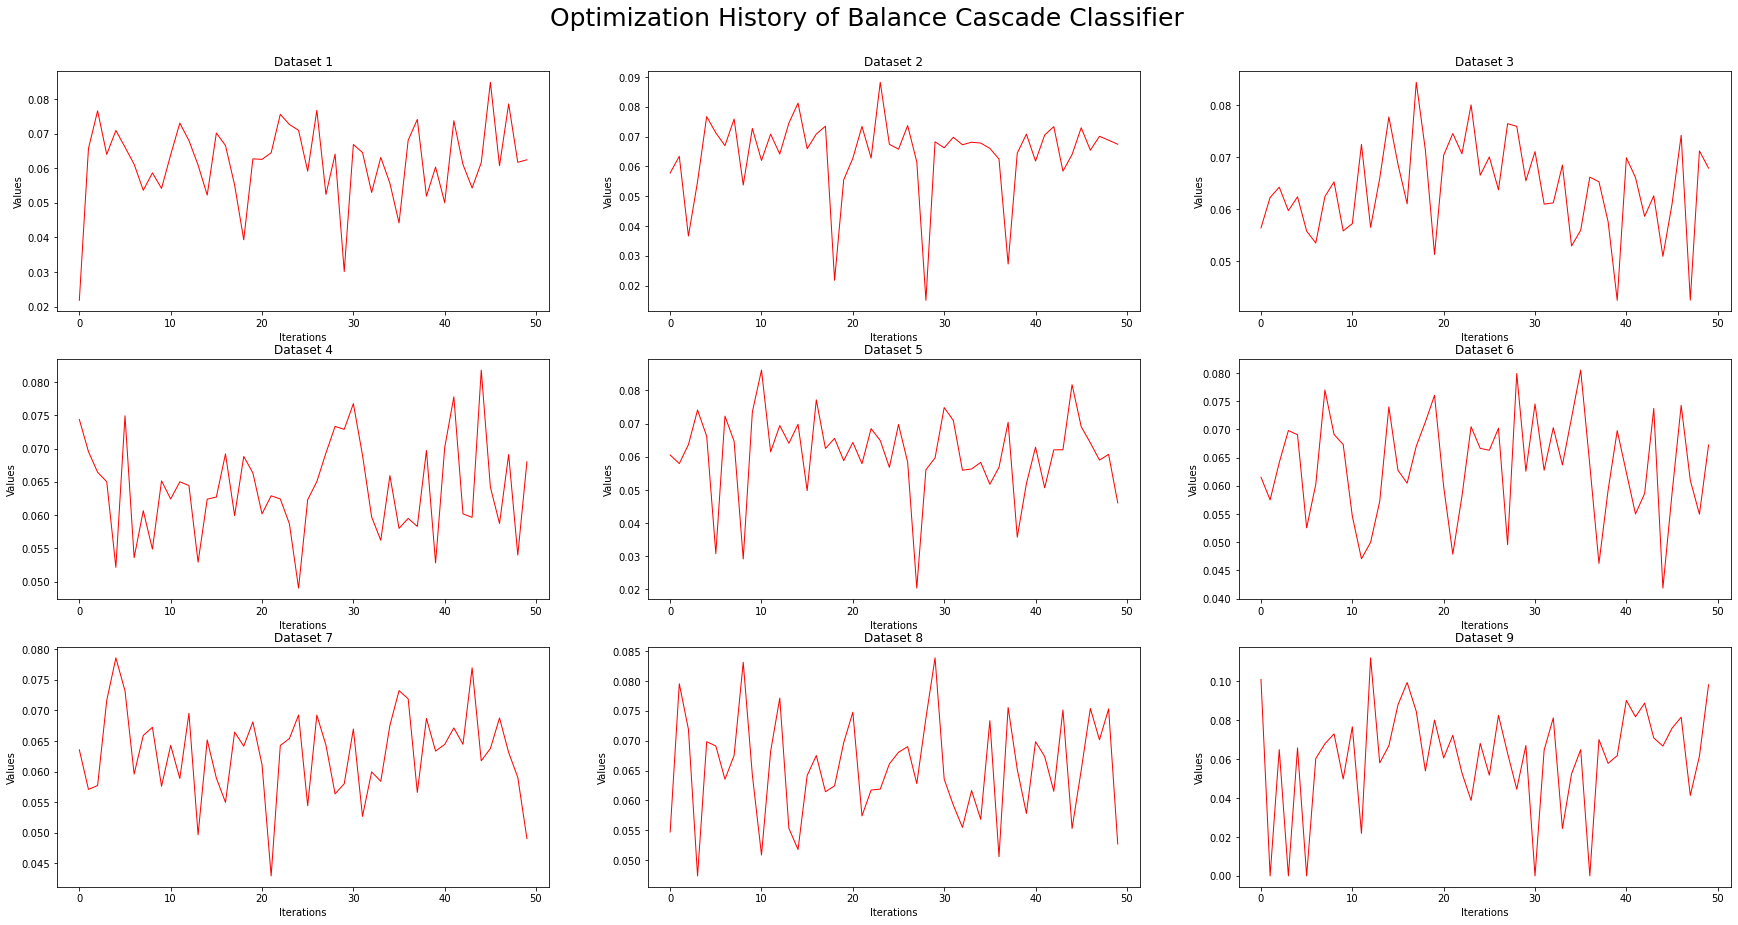

In [22]:
##### optimization history plot #####
optuna_history(best_paramC, all_scoreC, num_row = 3, num_col = 3, model = 'Balance Cascade Classifier')
            
##### best hyperparameter table #####
param_table = pd.DataFrame(best_paramC).T
param_table

#### Balance Cascade Scheme 1


 Dataset 1:

Iteration 1:
Stop Oversampling !
Size after Undersampling: 3084

Iteration 2:
Stop Oversampling !
Size after Undersampling: 3084

Iteration 3:
Stop Oversampling !
Size after Undersampling: 3084

Iteration 4:
Stop Oversampling !
Size after Undersampling: 3084

Iteration 5:
Stop Oversampling !
Stop Undersampling !
Precision: 0.0016835016835016834 
Recall: 0.11764705882352941 
Aging Rate: 0.07325947090382125

 Dataset 2:

Iteration 1:
Stop Oversampling !
Size after Undersampling: 3018

Iteration 2:
Stop Oversampling !
Size after Undersampling: 3018

Iteration 3:
Stop Oversampling !
Size after Undersampling: 3018

Iteration 4:
Stop Oversampling !
Size after Undersampling: 3018

Iteration 5:
Stop Oversampling !
Stop Undersampling !


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:105: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.01050381302801702

 Dataset 3:

Iteration 1:
Stop Oversampling !
Size after Undersampling: 3032

Iteration 2:
Stop Oversampling !
Size after Undersampling: 3032

Iteration 3:
Stop Oversampling !
Size after Undersampling: 3032

Iteration 4:
Stop Oversampling !
Size after Undersampling: 3032

Iteration 5:
Stop Oversampling !
Stop Undersampling !
Precision: 0.0005224660397074191 
Recall: 0.0196078431372549 
Aging Rate: 0.03934304918908919

 Dataset 4:

Iteration 1:
Stop Oversampling !
Size after Undersampling: 3036

Iteration 2:
Stop Oversampling !
Size after Undersampling: 3036

Iteration 3:
Stop Oversampling !
Size after Undersampling: 3036

Iteration 4:
Stop Oversampling !
Size after Undersampling: 3036

Iteration 5:
Stop Oversampling !
Stop Undersampling !
Precision: 0.001628001628001628 
Recall: 0.0784313725490196 
Aging Rate: 0.050504635244301016

 Dataset 5:

Iteration 1:
Stop Oversampling !
Size after Undersampling: 3034

Iteration 2:
Sto

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0

 Dataset 9:

Iteration 1:
Stop Oversampling !
Size after Undersampling: 608

Iteration 2:
Stop Oversampling !
Size after Undersampling: 608

Iteration 3:
Stop Oversampling !
Size after Undersampling: 608

Iteration 4:
Stop Oversampling !
Size after Undersampling: 608

Iteration 5:
Stop Oversampling !
Stop Undersampling !
Precision: 0.0011337868480725624 
Recall: 0.19607843137254902 
Aging Rate: 0.18129869062056775


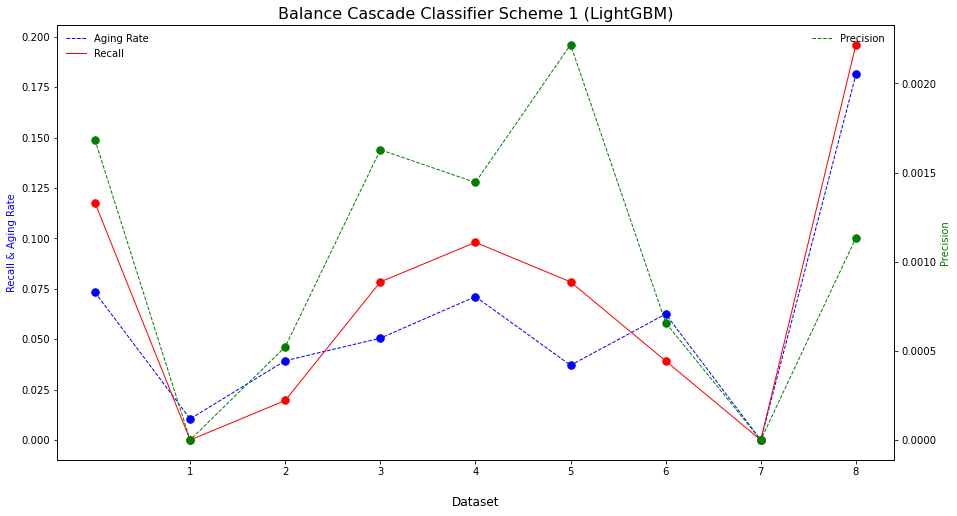

In [14]:
scheme = 1
table_setC = runall_cascade(run_train, run_test, base_paramC, num_iter = 5)
line_chart(table_setC, title = 'Balance Cascade Classifier Scheme 1')

In [15]:
table_setC

Balance Ratio  Train_OK  Train_NG    TP      FP    FN       TN  \
dataset 1       25.00000   38550.0    1542.0   6.0  3558.0  45.0  45040.0   
dataset 2       25.00000   37725.0    1509.0   0.0   511.0  51.0  48087.0   
dataset 3       25.00000   37900.0    1516.0   1.0  1913.0  50.0  46685.0   
dataset 4       25.00000   37950.0    1518.0   4.0  2453.0  47.0  46145.0   
dataset 5       25.04944   38000.0    1517.0   5.0  3456.0  46.0  45142.0   
dataset 6       25.18224   38000.0    1509.0   4.0  1800.0  47.0  46798.0   
dataset 7       25.18224   38000.0    1509.0   2.0  3038.0  49.0  45560.0   
dataset 8       25.00000   38000.0    1520.0   0.0     0.0  51.0  48598.0   
dataset 9       25.00000    7600.0     304.0  10.0  8810.0  41.0  39788.0   

           Precision    Recall  Aging Rate  Efficiency  F1 Score     Score  
dataset 1   0.001684  0.117647    0.073259    1.605896  0.001660  0.112680  
dataset 2   0.000000  0.000000    0.010504    0.000000       NaN  0.000000  
dataset 3   0.000522  0.019608    0.039343    0.498381  0.000509  0.000000  
dataset 4   0.001628  0.078431    0.050505    1.552954  0.001595  0.073510  
dataset 5   0.001445  0.098039    0.071142    1.378073  0.001424  0.084930  
dataset 6   0.002217  0.078431    0.037082    2.115082  0.002156  0.089118  
dataset 7   0.000658  0.039216    0.062488    0.627567  0.000647  0.000000  
dataset 8   0.000000  0.000000    0.000000    0.000000  0.000000       NaN  
dataset 9   0.001134  0.196078    0.181299    1.081521  0.001127  0.143745

#### Balance Cascade Scheme 2


 Dataset 1:

Iteration 1:
Size before Oversampling: 32382
Size after Oversampling: 38591
Size after Undersampling: 9252

Iteration 2:
Size before Oversampling: 27980
Size after Oversampling: 34127
Size after Undersampling: 9252

Iteration 3:
Size before Oversampling: 24206
Size after Oversampling: 30360
Size after Undersampling: 9252

Iteration 4:
Size before Oversampling: 20971
Size after Oversampling: 27134
Size after Undersampling: 9252

Iteration 5:
Size before Oversampling: 18198
Size after Oversampling: 24342
Size after Undersampling: 9252

Iteration 6:
Size before Oversampling: 15821
Size after Oversampling: 22005
Size after Undersampling: 9252

Iteration 7:
Size before Oversampling: 13783
Size after Oversampling: 19940
Size after Undersampling: 9252

Iteration 8:
Size before Oversampling: 12036
Size after Oversampling: 18187
Size after Undersampling: 9252

Iteration 9:
Size before Oversampling: 10538
Size after Oversampling: 16672
Size after Undersampling: 9252

Iteration 10:


Size after Oversampling: 38002
Size after Undersampling: 9120

Iteration 2:
Size before Oversampling: 27581
Size after Oversampling: 33652
Size after Undersampling: 9120

Iteration 3:
Size before Oversampling: 23861
Size after Oversampling: 29920
Size after Undersampling: 9120

Iteration 4:
Size before Oversampling: 20672
Size after Oversampling: 26739
Size after Undersampling: 9120

Iteration 5:
Size before Oversampling: 17938
Size after Oversampling: 24000
Size after Undersampling: 9120

Iteration 6:
Size before Oversampling: 15595
Size after Oversampling: 21693
Size after Undersampling: 9120

Iteration 7:
Size before Oversampling: 13586
Size after Oversampling: 19640
Size after Undersampling: 9120

Iteration 8:
Size before Oversampling: 11864
Size after Oversampling: 17914
Size after Undersampling: 9120

Iteration 9:
Size before Oversampling: 10388
Size after Oversampling: 16427
Size after Undersampling: 9120

Iteration 10:
Size before Oversampling: 9123
Size after Oversampling: 152

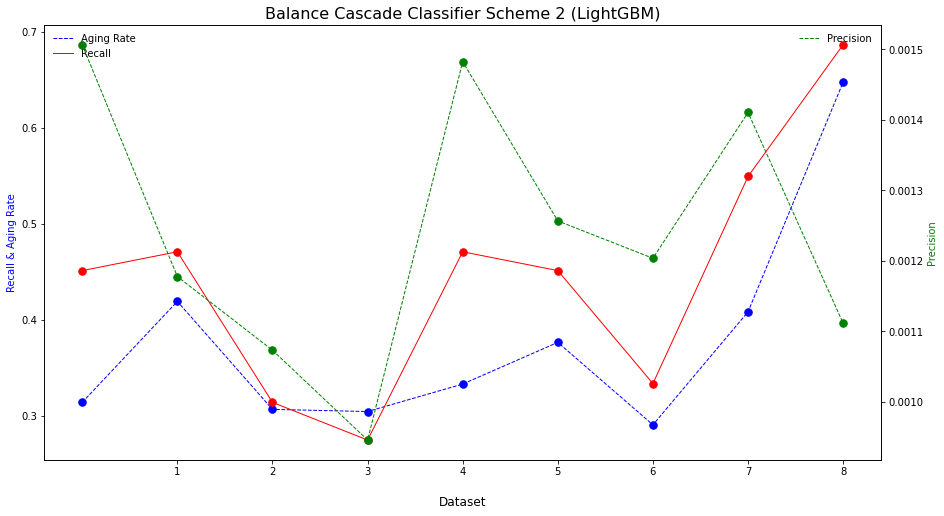

In [27]:
scheme = 2
table_setC = runall_cascade(run_train, run_test, base_config = base_paramC, meta_config = meta_paramC, num_iter = 10)
line_chart(table_setC, title = 'Balance Cascade Classifier Scheme 2')

In [28]:
table_setC

Balance Ratio  Train_OK  Train_NG    TP       FP    FN       TN  \
dataset 1      20.000000   30840.0    1542.0  23.0  15244.0  28.0  33354.0   
dataset 2      20.000000   30020.0    1501.0  24.0  20354.0  27.0  28244.0   
dataset 3      20.000000   30320.0    1516.0  16.0  14891.0  35.0  33707.0   
dataset 4      20.000000   30360.0    1518.0  14.0  14786.0  37.0  33812.0   
dataset 5      20.253165   30400.0    1501.0  24.0  16166.0  27.0  32432.0   
dataset 6      20.105820   30400.0    1512.0  23.0  18280.0  28.0  30318.0   
dataset 7      20.172528   30400.0    1507.0  17.0  14107.0  34.0  34491.0   
dataset 8      20.000000   30400.0    1520.0  28.0  19824.0  23.0  28774.0   
dataset 9      20.000000    6080.0     304.0  35.0  31454.0  16.0  17144.0   

           Precision    Recall  Aging Rate  Efficiency  F1 Score     Score  
dataset 1   0.001507  0.450980    0.313819    1.437070  0.001502  0.401732  
dataset 2   0.001178  0.470588    0.418878    1.123449  0.001175  0.354373  
dataset 3   0.001073  0.313725    0.306419    1.023843  0.001070  0.221176  
dataset 4   0.000946  0.274510    0.304220    0.902340  0.000943  0.000000  
dataset 5   0.001482  0.470588    0.332792    1.414061  0.001478  0.414734  
dataset 6   0.001257  0.450980    0.376226    1.198697  0.001253  0.355312  
dataset 7   0.001204  0.333333    0.290325    1.148140  0.001199  0.254867  
dataset 8   0.001410  0.549020    0.408066    1.345419  0.001407  0.468019  
dataset 9   0.001111  0.686275    0.647269    1.060261  0.001110  0.496062

### Full Experiment

In [9]:
scheme = 2
training_month = range(2, 5)

table_setC = full_balancecascade(training_month, times = 3, scheme = scheme)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Month 2:
# bad: 69
Size before Border: 39009
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 4
Distance = 9 ...
# over: 4
Distance = 10 ...
# over: 4
Distance = 11 ...
# over: 20
Distance = 12 ...
# over: 12
Distance = 13 ...
# over: 28
Distance = 14 ...
# over: 28
Distance = 15 ...
# over: 96
Distance = 16 ...
# over: 86
# over: 86
Size after Border: 39282

 Generating Dataset 2
Size after Undersampling: 7182
Size after Undersampling: (7182, 88) , Balance Ratio: 20.0
Size before Undersampling: 39009

 Generating Dataset 6
Size after Undersampling: 6969
Size after Undersampling: 6969
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 4
Distance = 9 ...
# over: 4
Distance = 10 ...
# over: 4
Distance = 11 ...
# over: 20
Distance = 12 ...
# over: 12
Distance = 13 ...
# over: 28
Distance = 14 ...
# over:

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-04-18 09:19:42,406] A new study created in memory with name: no-name-e4f3bf6c-c5a0-4cf0-9a82-788fe2431b39


Dataset 1 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]


Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28926
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25596
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22814
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20346
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18238
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16476
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14980
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13666
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12534
Size after Undersampling: 6936

Iteration 10:
Size before Ove

Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20384
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18262
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16471
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14961
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13632
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12494
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11520
Stop Undersampling !
Precision: 0.037267080745341616 
Recall: 0.1836734693877551 
Aging Rate: 0.2441860465116279

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28876
Size after Undersampling: 6936

Iteration 2:
Size before

Size after Oversampling: 16522
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14934
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13669
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12539
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11520
Stop Undersampling !
Precision: 0.0345489443378119 
Recall: 0.21951219512195122 
Aging Rate: 0.2555174104953409

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28941
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25644
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22773
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20305
Size after Undersampling: 

Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11571
Stop Undersampling !
Precision: 0.04024144869215292 
Recall: 0.24096385542168675 
Aging Rate: 0.24482758620689654

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28956
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25626
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22773
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20313
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18238
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16519
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14991
Size after Undersampling: 6936

Iteration 8:
Size bef

Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25647
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22783
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20316
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18299
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16527
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14958
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13689
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12589
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11552
Stop Undersampling !
Precision

Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18252
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16509
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14926
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13626
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12506
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11615
Stop Undersampling !
Precision: 0.03536345776031434 
Recall: 0.21951219512195122 
Aging Rate: 0.2582445459157788

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28866
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25623
Size after Undersampling: 6936

Iteration 3:
Size before

Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13634
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12469
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11559
Stop Undersampling !
Precision: 0.04375 
Recall: 0.22826086956521738 
Aging Rate: 0.23610427939006395

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28868
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25642
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22740
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20363
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18277
Size after Undersampling: 6936

Iteration 6:
Size before Oversampli

Precision: 0.05222437137330754 
Recall: 0.29347826086956524 
Aging Rate: 0.256575682382134

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28886
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25537
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22792
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20337
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18239
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16451
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14962
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13622
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
S

Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22823
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20313
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18264
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16448
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 15006
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13589
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12498
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11571
Stop Undersampling !
Precision: 0.03364485981308411 
Recall: 0.21686746987951808 
Aging Rate: 0.2628992628992629
[I 2022-04-18 09:32:56,59

Size after Oversampling: 18252
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16424
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14907
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13696
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12560
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11546
Stop Undersampling !
Precision: 0.029411764705882353 
Recall: 0.1794871794871795 
Aging Rate: 0.238
[I 2022-04-18 09:34:24,837] Trial 18 finished with value: 0.05117759367664227 and parameters: {'n_estimators': 1000, 'learning_rate': 0.325, 'max_depth': 3, 'num_leaves': 110, 'min_child_samples': 500, 'min_split_gain': 12, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 3.0160435618146555, 'reg_lambda': 0.077422057323097

Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12535
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11562
Stop Undersampling !
Precision: 0.044 
Recall: 0.2268041237113402 
Aging Rate: 0.24740227610094012
[I 2022-04-18 09:35:53,915] Trial 20 finished with value: 0.060761702567661814 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07500000000000001, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 500, 'min_split_gain': 4, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.7030614483372651, 'reg_lambda': 0.4925388228217561, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 3 with value: 0.07759590746535304.

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28918
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25648
Size after Undersampling: 


Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28927
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25626
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22835
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20385
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18296
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16485
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14938
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13674
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12493
Size after Undersampling: 6936

Iteration 10:
Size before Ove

[I 2022-04-18 09:38:55,902] A new study created in memory with name: no-name-1da29c02-33c1-4e69-bb4e-405e2c6a960b


Precision: 0.03543307086614173 
Recall: 0.21428571428571427 
Aging Rate: 0.24624333494910325
[I 2022-04-18 09:38:55,824] Trial 24 finished with value: 0.0729397456246932 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 90, 'min_child_samples': 1000, 'min_split_gain': 10, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 1.768838704148047, 'reg_lambda': 1.323785179967839, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 3 with value: 0.07759590746535304.
Sampler is TPESampler
Dataset 2 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]


Iteration 1:
Size before Oversampling: 23766
Size after Oversampling: 28267
Size after Undersampling: 6786

Iteration 2:
Size before Oversampling: 20534
Size after Oversampling: 24981
Size after Undersampling: 6786

Iteration 3:
Size before Oversampling: 17763
Size after Oversampling: 22223
Size after Undersampling: 6786

Iteration 4:
Size before Oversampling: 15388
Size after Oversampling: 19969
Size after Undersampling: 6786

Iteration 5:
Size before Oversampling: 13352
Size after Oversampling: 17947
Size after Undersampling: 6786

Iteration 6:
Size before Oversampling: 11607
Size after Oversampling: 16181
Size after Undersampling: 6786

Iteration 7:
Size before Oversampling: 10111
Size after Oversampling: 14712
Size after Undersampling: 6786

Iteration 8:
Size before Oversampling: 8829
Size after Oversampling: 13398
Size after Undersampling: 6786

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12288
Size after Undersampling: 6786

Iteration 10:
Size before Ove

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0

Iteration 1:
Size before Oversampling: 23766
Size after Oversampling: 28225
Size after Undersampling: 6786

Iteration 2:
Size before Oversampling: 20534
Size after Oversampling: 25131
Size after Undersampling: 6786

Iteration 3:
Size before Oversampling: 17763
Size after Oversampling: 22241
Size after Undersampling: 6786

Iteration 4:
Size before Oversampling: 15388
Size after Oversampling: 19962
Size after Undersampling: 6786

Iteration 5:
Size before Oversampling: 13352
Size after Oversampling: 17831
Size after Undersampling: 6786

Iteration 6:
Size before Oversampling: 11607
Size after Oversampling: 16133
Size after Undersampling: 6786

Iteration 7:
Size before Oversampling: 10111
Size after Oversampling: 14649
Size after Undersampling: 6786

Iteration 8:
Size before Oversampling: 8829
Size after Oversampling: 13350
Size after Undersampling: 6786

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12287
Size after Undersa

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-18 09:40:17,089] Trial 1 finished with value: 0.010139416983523445 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 12, 'num_leaves': 10, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.6749980287647354, 'reg_lambda': 0.01137025973468062, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 0 with value: 0.05193431692575038.

Iteration 1:
Size before Oversampling: 23766
Size after Oversampling: 28395
Size after Undersampling: 6786

Iteration 2:
Size before Oversampling: 20534
Size after Oversampling: 25048
Size after Undersampling: 6786

Iteration 3:
Size before Oversampling: 17763
Size after Oversampling: 22352
Size after Undersampling: 6786

Iteration 4:
Size before Oversampling: 15388
Size after Oversampling: 19931
Size after Undersampling: 6786

Iteration 5:
Size before Oversampling: 13352
Size after Oversa


Iteration 1:
Size before Oversampling: 23766
Size after Oversampling: 28288
Size after Undersampling: 6786

Iteration 2:
Size before Oversampling: 20534
Size after Oversampling: 24993
Size after Undersampling: 6786

Iteration 3:
Size before Oversampling: 17763
Size after Oversampling: 22244
Size after Undersampling: 6786

Iteration 4:
Size before Oversampling: 15388
Size after Oversampling: 19840
Size after Undersampling: 6786

Iteration 5:
Size before Oversampling: 13352
Size after Oversampling: 17827
Size after Undersampling: 6786

Iteration 6:
Size before Oversampling: 11607
Size after Oversampling: 16030
Size after Undersampling: 6786

Iteration 7:
Size before Oversampling: 10111
Size after Oversampling: 14685
Size after Undersampling: 6786

Iteration 8:
Size before Oversampling: 8829
Size after Oversampling: 13261
Size after Undersampling: 6786

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12324
Size after Undersampling: 6786

Iteration 10:
Size before Ove

Size after Undersampling: 6786

Iteration 4:
Size before Oversampling: 15388
Size after Oversampling: 19996
Size after Undersampling: 6786

Iteration 5:
Size before Oversampling: 13352
Size after Oversampling: 17885
Size after Undersampling: 6786

Iteration 6:
Size before Oversampling: 11607
Size after Oversampling: 16125
Size after Undersampling: 6786

Iteration 7:
Size before Oversampling: 10111
Size after Oversampling: 14602
Size after Undersampling: 6786

Iteration 8:
Size before Oversampling: 8829
Size after Oversampling: 13436
Size after Undersampling: 6786

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12243
Size after Undersampling: 6786

Iteration 10:
Size before Oversampling: 6788
Size after Oversampling: 11322
Stop Undersampling !
Precision: 0.01972386587771203 
Recall: 0.11764705882352941 
Aging Rate: 0.24719648951730863

Iteration 1:
Size before Oversampling: 23766
Size after Oversampling: 28335
Size after Undersampling: 6786

Iteration 2:
Size befor

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-18 09:44:29,710] Trial 7 finished with value: 0.03619672474643304 and parameters: {'n_estimators': 100, 'learning_rate': 0.025, 'max_depth': 12, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.03390566746164261, 'reg_lambda': 0.022579890770285604, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 5 with value: 0.07940450102135531.

Iteration 1:
Size before Oversampling: 23766
Size after Oversampling: 28228
Size after Undersampling: 6786

Iteration 2:
Size before Oversampling: 20534
Size after Oversampling: 25011
Size after Undersampling: 6786

Iteration 3:
Size before Oversampling: 17763
Size after Oversampling: 22258
Size after Undersampling: 6786

Iteration 4:
Size before Oversampling: 15388
Size after Oversampling: 19851
Size after Undersampling: 6786

Iteration 5:
Size before Oversampling: 13352
Size after Over

Size before Oversampling: 23766
Size after Oversampling: 28353
Size after Undersampling: 6786

Iteration 2:
Size before Oversampling: 20534
Size after Oversampling: 25050
Size after Undersampling: 6786

Iteration 3:
Size before Oversampling: 17763
Size after Oversampling: 22341
Size after Undersampling: 6786

Iteration 4:
Size before Oversampling: 15388
Size after Oversampling: 19871
Size after Undersampling: 6786

Iteration 5:
Size before Oversampling: 13352
Size after Oversampling: 17949
Size after Undersampling: 6786

Iteration 6:
Size before Oversampling: 11607
Size after Oversampling: 16108
Size after Undersampling: 6786

Iteration 7:
Size before Oversampling: 10111
Size after Oversampling: 14584
Size after Undersampling: 6786

Iteration 8:
Size before Oversampling: 8829
Size after Oversampling: 13325
Size after Undersampling: 6786

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12172
Size after Undersampling: 6786

Iteration 10:
Size before Oversampling: 678


Iteration 4:
Size before Oversampling: 15388
Size after Oversampling: 19991
Size after Undersampling: 6786

Iteration 5:
Size before Oversampling: 13352
Size after Oversampling: 17881
Size after Undersampling: 6786

Iteration 6:
Size before Oversampling: 11607
Size after Oversampling: 16203
Size after Undersampling: 6786

Iteration 7:
Size before Oversampling: 10111
Size after Oversampling: 14573
Size after Undersampling: 6786

Iteration 8:
Size before Oversampling: 8829
Size after Oversampling: 13430
Size after Undersampling: 6786

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12248
Size after Undersampling: 6786

Iteration 10:
Size before Oversampling: 6788
Size after Oversampling: 11250
Stop Undersampling !
Precision: 0.03577817531305903 
Recall: 0.24096385542168675 
Aging Rate: 0.27894211576846306

Iteration 1:
Size before Oversampling: 23766
Size after Oversampling: 28299
Size after Undersampling: 6786

Iteration 2:
Size before Oversampling: 20534
Size afte

Size after Undersampling: 6786

Iteration 7:
Size before Oversampling: 10111
Size after Oversampling: 14569
Size after Undersampling: 6786

Iteration 8:
Size before Oversampling: 8829
Size after Oversampling: 13267
Size after Undersampling: 6786

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12194
Size after Undersampling: 6786

Iteration 10:
Size before Oversampling: 6788
Size after Oversampling: 11227
Stop Undersampling !
Precision: 0.037037037037037035 
Recall: 0.23376623376623376 
Aging Rate: 0.243

Iteration 1:
Size before Oversampling: 23766
Size after Oversampling: 28253
Size after Undersampling: 6786

Iteration 2:
Size before Oversampling: 20534
Size after Oversampling: 24991
Size after Undersampling: 6786

Iteration 3:
Size before Oversampling: 17763
Size after Oversampling: 22236
Size after Undersampling: 6786

Iteration 4:
Size before Oversampling: 15388
Size after Oversampling: 19841
Size after Undersampling: 6786

Iteration 5:
Size before Oversamplin

Size after Undersampling: 6786

Iteration 10:
Size before Oversampling: 6788
Size after Oversampling: 11233
Stop Undersampling !
Precision: 0.03807615230460922 
Recall: 0.2159090909090909 
Aging Rate: 0.253685815963396

Iteration 1:
Size before Oversampling: 23766
Size after Oversampling: 28312
Size after Undersampling: 6786

Iteration 2:
Size before Oversampling: 20534
Size after Oversampling: 24989
Size after Undersampling: 6786

Iteration 3:
Size before Oversampling: 17763
Size after Oversampling: 22313
Size after Undersampling: 6786

Iteration 4:
Size before Oversampling: 15388
Size after Oversampling: 19918
Size after Undersampling: 6786

Iteration 5:
Size before Oversampling: 13352
Size after Oversampling: 17896
Size after Undersampling: 6786

Iteration 6:
Size before Oversampling: 11607
Size after Oversampling: 16099
Size after Undersampling: 6786

Iteration 7:
Size before Oversampling: 10111
Size after Oversampling: 14613
Size after Undersampling: 6786

Iteration 8:
Size before

Size after Undersampling: 6786

Iteration 2:
Size before Oversampling: 20534
Size after Oversampling: 25156
Size after Undersampling: 6786

Iteration 3:
Size before Oversampling: 17763
Size after Oversampling: 22373
Size after Undersampling: 6786

Iteration 4:
Size before Oversampling: 15388
Size after Oversampling: 19991
Size after Undersampling: 6786

Iteration 5:
Size before Oversampling: 13352
Size after Oversampling: 17846
Size after Undersampling: 6786

Iteration 6:
Size before Oversampling: 11607
Size after Oversampling: 16164
Size after Undersampling: 6786

Iteration 7:
Size before Oversampling: 10111
Size after Oversampling: 14708
Size after Undersampling: 6786

Iteration 8:
Size before Oversampling: 8829
Size after Oversampling: 13372
Size after Undersampling: 6786

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12210
Size after Undersampling: 6786

Iteration 10:
Size before Oversampling: 6788
Size after Oversampling: 11261
Stop Undersampling !
Precision

Size after Oversampling: 19813
Size after Undersampling: 6786

Iteration 5:
Size before Oversampling: 13352
Size after Oversampling: 17839
Size after Undersampling: 6786

Iteration 6:
Size before Oversampling: 11607
Size after Oversampling: 16015
Size after Undersampling: 6786

Iteration 7:
Size before Oversampling: 10111
Size after Oversampling: 14536
Size after Undersampling: 6786

Iteration 8:
Size before Oversampling: 8829
Size after Oversampling: 13386
Size after Undersampling: 6786

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12323
Size after Undersampling: 6786

Iteration 10:
Size before Oversampling: 6788
Size after Oversampling: 11377
Stop Undersampling !
Precision: 0.03162055335968379 
Recall: 0.2077922077922078 
Aging Rate: 0.254911838790932

Iteration 1:
Size before Oversampling: 23766
Size after Oversampling: 28213
Size after Undersampling: 6786

Iteration 2:
Size before Oversampling: 20534
Size after Oversampling: 25000
Size after Undersampling: 6

Size after Oversampling: 14574
Size after Undersampling: 6786

Iteration 8:
Size before Oversampling: 8829
Size after Oversampling: 13293
Size after Undersampling: 6786

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12285
Size after Undersampling: 6786

Iteration 10:
Size before Oversampling: 6788
Size after Oversampling: 11349
Stop Undersampling !
Precision: 0.05150214592274678 
Recall: 0.3 
Aging Rate: 0.23958868894601543

Iteration 1:
Size before Oversampling: 23766
Size after Oversampling: 28255
Size after Undersampling: 6786

Iteration 2:
Size before Oversampling: 20534
Size after Oversampling: 24987
Size after Undersampling: 6786

Iteration 3:
Size before Oversampling: 17763
Size after Oversampling: 22208
Size after Undersampling: 6786

Iteration 4:
Size before Oversampling: 15388
Size after Oversampling: 19929
Size after Undersampling: 6786

Iteration 5:
Size before Oversampling: 13352
Size after Oversampling: 17808
Size after Undersampling: 6786

Iteratio

Size after Oversampling: 11264
Stop Undersampling !
Precision: 0.03966597077244259 
Recall: 0.21348314606741572 
Aging Rate: 0.2378351539225422

Iteration 1:
Size before Oversampling: 23766
Size after Oversampling: 28305
Size after Undersampling: 6786

Iteration 2:
Size before Oversampling: 20534
Size after Oversampling: 25080
Size after Undersampling: 6786

Iteration 3:
Size before Oversampling: 17763
Size after Oversampling: 22296
Size after Undersampling: 6786

Iteration 4:
Size before Oversampling: 15388
Size after Oversampling: 19870
Size after Undersampling: 6786

Iteration 5:
Size before Oversampling: 13352
Size after Oversampling: 17800
Size after Undersampling: 6786

Iteration 6:
Size before Oversampling: 11607
Size after Oversampling: 16090
Size after Undersampling: 6786

Iteration 7:
Size before Oversampling: 10111
Size after Oversampling: 14722
Size after Undersampling: 6786

Iteration 8:
Size before Oversampling: 8829
Size after Oversampling: 13443
Size after Undersampling

[I 2022-04-18 09:56:33,111] A new study created in memory with name: no-name-baa498c6-5ee7-4621-ba7e-cc4a9034b74a


Precision: 0.017892644135188866 
Recall: 0.1125 
Aging Rate: 0.2565017848036716
[I 2022-04-18 09:56:33,048] Trial 24 finished with value: 0.06050942928160535 and parameters: {'n_estimators': 300, 'learning_rate': 0.275, 'max_depth': 9, 'num_leaves': 30, 'min_child_samples': 100, 'min_split_gain': 8, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 3.629023991362856, 'reg_lambda': 0.4451387283788785, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 5 with value: 0.07940450102135531.
Sampler is TPESampler
Dataset 3 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]


Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28214
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 24946
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22136
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 19726
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17667
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 15864
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14329
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13430
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12285
Size after Undersampling: 6828

Iteration 10:
Size before Ove

Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 19847
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17775
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 15985
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14452
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13119
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 11962
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 10985
Stop Undersampling !
Precision: 0.030710172744721688 
Recall: 0.1702127659574468 
Aging Rate: 0.2614149523331661

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28181
Size after Undersampling: 6828

Iteration 2:
Size before

Size after Oversampling: 16192
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14884
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13541
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12360
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11374
Stop Undersampling !
Precision: 0.024390243902439025 
Recall: 0.13793103448275862 
Aging Rate: 0.2478589420654912

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28273
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25008
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22203
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 19773
Size after Undersampling

Size after Oversampling: 12421
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11427
Stop Undersampling !
Precision: 0.0275049115913556 
Recall: 0.18421052631578946 
Aging Rate: 0.25929699439633214

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28138
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 24883
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22071
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 19652
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17575
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16237
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14682
Size after Undersamplin

Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 24931
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22107
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 19680
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17581
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16240
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14706
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13377
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12412
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11404
Stop Undersampling !
Precision

Size after Oversampling: 17589
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16180
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14849
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13504
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12467
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11405
Stop Undersampling !
Precision: 0.0375 
Recall: 0.21176470588235294 
Aging Rate: 0.24012006003001501

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28282
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25010
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22180
Size after Undersampling: 6828

Itera

Size after Oversampling: 13504
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12293
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11376
Stop Undersampling !
Precision: 0.033402922755741124 
Recall: 0.1927710843373494 
Aging Rate: 0.2407035175879397

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28235
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 24964
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22132
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 19641
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17962
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16141
Size after Undersampling

Size after Oversampling: 28312
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25022
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22201
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 19751
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17635
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 15843
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14712
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13340
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12369
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11575

Size before Oversampling: 15481
Size after Oversampling: 19700
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17586
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16147
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14822
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13446
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12475
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11476
Stop Undersampling !
Precision: 0.0397489539748954 
Recall: 0.18627450980392157 
Aging Rate: 0.23745653253849974
[I 2022-04-18 10:08:58,669] Trial 16 finished with value: 0.06712156069594266 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 30, 'mi

Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14335
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13426
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12278
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11270
Stop Undersampling !
Precision: 0.01953125 
Recall: 0.12345679012345678 
Aging Rate: 0.25819465456379226
[I 2022-04-18 10:10:29,923] Trial 18 finished with value: 0.048005349807071655 and parameters: {'n_estimators': 1000, 'learning_rate': 0.325, 'max_depth': 9, 'num_leaves': 30, 'min_child_samples': 1000, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.026767730022111965, 'reg_lambda': 0.05285868378784294, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 14 with value: 0.06963160713865733.

Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11525
Stop Undersampling !
Precision: 0.03636363636363636 
Recall: 0.20224719101123595 
Aging Rate: 0.25242223355430904
[I 2022-04-18 10:12:05,929] Trial 20 finished with value: 0.06554380955618251 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'num_leaves': 110, 'min_child_samples': 500, 'min_split_gain': 8, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.010030597790566111, 'reg_lambda': 0.025715331323520968, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 14 with value: 0.06963160713865733.

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28223
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 24951
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22101
Size a

Size after Oversampling: 28181
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 24919
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22085
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 19652
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17968
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16365
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14766
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13547
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12333
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11304

[I 2022-04-18 10:15:00,061] A new study created in memory with name: no-name-f41dca8b-1a12-40ef-bb9e-a0cd1f4434e8


Precision: 0.030927835051546393 
Recall: 0.18072289156626506 
Aging Rate: 0.24470232088799193
[I 2022-04-18 10:14:59,998] Trial 24 finished with value: 0.0652248332688016 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 8, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0.1842558757058581, 'reg_lambda': 9.869386965930733, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 22 with value: 0.08273532229435061.
Sampler is TPESampler
Dataset 4 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]


Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28458
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25241
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22419
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20048
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 18002
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16258
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14683
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13473
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12320
Size after Undersampling: 6828

Iteration 10:
Size before Ove

Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20007
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 18005
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16221
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14723
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13446
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12333
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11377
Stop Undersampling !
Precision: 0.046632124352331605 
Recall: 0.23376623376623376 
Aging Rate: 0.19194430631526604

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28479
Size after Undersampling: 6828

Iteration 2:
Size befo

Size after Oversampling: 16239
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14739
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13446
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12322
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11375
Stop Undersampling !
Precision: 0.03468208092485549 
Recall: 0.2222222222222222 
Aging Rate: 0.25680356259277587

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28434
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25191
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22443
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20016
Size after Undersampling:

Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11400
Stop Undersampling !
Precision: 0.03143418467583497 
Recall: 0.20253164556962025 
Aging Rate: 0.2463697967086157

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28439
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25213
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22400
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20032
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17965
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16216
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14700
Size after Undersampling: 6828

Iteration 8:
Size befo

Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25226
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22443
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20051
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17996
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16218
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14733
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13433
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12320
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11399
Stop Undersampling !
Precision

Size after Oversampling: 20028
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17975
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16243
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14717
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13450
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12354
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11375
Stop Undersampling !
Precision: 0.03359683794466403 
Recall: 0.16831683168316833 
Aging Rate: 0.2506191183754334

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28437
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25196
Size after Undersampling:

Size after Oversampling: 14697
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13420
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12343
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11388
Stop Undersampling !
Precision: 0.0390625 
Recall: 0.2702702702702703 
Aging Rate: 0.2591093117408907

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28458
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25192
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22407
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20025
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17982
Size after Undersampling: 6828

Iter


Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11384
Stop Undersampling !
Precision: 0.036885245901639344 
Recall: 0.16981132075471697 
Aging Rate: 0.24461152882205514

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28490
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25209
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22436
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20045
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17963
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16258
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14703
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size af

Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25180
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22429
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20030
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17983
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16242
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14683
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13423
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12316
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11382
Stop Undersampling !
Precision

Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17983
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16248
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14724
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13473
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12307
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11359
Stop Undersampling !
Precision: 0.04356435643564356 
Recall: 0.25 
Aging Rate: 0.2619294605809129
[I 2022-04-18 10:28:52,372] Trial 18 finished with value: 0.06850403983624893 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 12, 'num_leaves': 10, 'min_child_samples': 1000, 'min_split_gain': 2, 'colsample_bytree':

Size after Oversampling: 14707
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13453
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12330
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11394
Stop Undersampling !
Precision: 0.048417132216014895 
Recall: 0.26 
Aging Rate: 0.2665012406947891
[I 2022-04-18 10:30:19,698] Trial 20 finished with value: 0.07129011274304901 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 12, 'num_leaves': 90, 'min_child_samples': 50, 'min_split_gain': 6, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 3.4543355454044566, 'reg_lambda': 0.14560082680287956, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 12 with value: 0.08194288644642146.

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28

Precision: 0.04500978473581213 
Recall: 0.23469387755102042 
Aging Rate: 0.2524703557312253
[I 2022-04-18 10:31:46,305] Trial 22 finished with value: 0.07493616270307302 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 12, 'num_leaves': 130, 'min_child_samples': 1000, 'min_split_gain': 8, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.49047654081845227, 'reg_lambda': 0.03827660890759375, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 12 with value: 0.08194288644642146.

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28490
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25195
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22431
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20011
Size after Undersampling: 6828

Iteration

[I 2022-04-18 10:33:11,177] A new study created in memory with name: no-name-ee3c2194-7c4e-4938-9417-669a120a19f4


Precision: 0.03418803418803419 
Recall: 0.20512820512820512 
Aging Rate: 0.23828920570264767
[I 2022-04-18 10:33:11,099] Trial 24 finished with value: 0.06115404124069948 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 9, 'num_leaves': 130, 'min_child_samples': 1000, 'min_split_gain': 8, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 0.667093353364936, 'reg_lambda': 0.10041524548307605, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 12 with value: 0.08194288644642146.
Sampler is TPESampler
Dataset 5 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]


Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28398
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25080
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22358
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19916
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17893
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16092
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14594
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13281
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12236
Size after Undersampling: 6750

Iteration 10:
Size before Ove

Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19984
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17946
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16078
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14571
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13384
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12158
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11299
Stop Undersampling !
Precision: 0.032119914346895075 
Recall: 0.15151515151515152 
Aging Rate: 0.23326673326673328

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28362
Size after Undersampling: 6750

Iteration 2:
Size befo

Size after Oversampling: 16124
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14598
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13314
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12178
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11274
Stop Undersampling !
Precision: 0.035381750465549346 
Recall: 0.2159090909090909 
Aging Rate: 0.2657100445324097

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28452
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25199
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22355
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19926
Size after Undersampling:


Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12135
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11213
Stop Undersampling !
Precision: 0.03294573643410853 
Recall: 0.20987654320987653 
Aging Rate: 0.25646123260437376

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28405
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25119
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22319
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19981
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17841
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16067
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size aft

Size after Oversampling: 28395
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25111
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22292
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19895
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17883
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16103
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14567
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13268
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12222
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11237

Size after Oversampling: 19963
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17827
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16141
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14633
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13281
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12247
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11223
Stop Undersampling !
Precision: 0.049586776859504134 
Recall: 0.2696629213483146 
Aging Rate: 0.23795476892822026

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28454
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25172
Size after Undersampling

Size after Oversampling: 14568
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13302
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12164
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11248
Stop Undersampling !
Precision: 0.037037037037037035 
Recall: 0.20224719101123595 
Aging Rate: 0.2470767666497204

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28465
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25146
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22344
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19906
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17895
Size after Undersampling

Size after Oversampling: 11261
Stop Undersampling !


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:105: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.0039603960396039604

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28424
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25168
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22368
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19900
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17910
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16107
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14563
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13315
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 1223

Size after Oversampling: 22333
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19911
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17844
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16113
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14555
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13292
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12194
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11241
Stop Undersampling !
Precision: 0.03725490196078431 
Recall: 0.20652173913043478 
Aging Rate: 0.25449101796407186
[I 2022-04-18 10:45:24,373] Trial 16 finished with value: 0.07158789126865432 and parameters: {'n_est

Size after Oversampling: 16115
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14565
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13332
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12231
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11243
Stop Undersampling !
Precision: 0.0467706013363029 
Recall: 0.28378378378378377 
Aging Rate: 0.23581932773109243
[I 2022-04-18 10:46:45,795] Trial 18 finished with value: 0.07735461240628903 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 130, 'min_child_samples': 50, 'min_split_gain': 12, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 4.409031876314745, 'reg_lambda': 0.0554001008779307, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Be

Size after Oversampling: 12257
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11263
Stop Undersampling !
Precision: 0.0466786355475763 
Recall: 0.28888888888888886 
Aging Rate: 0.2786393196598299
[I 2022-04-18 10:48:08,428] Trial 20 finished with value: 0.07617303032037705 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'num_leaves': 110, 'min_child_samples': 50, 'min_split_gain': 8, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.7551000532410398, 'reg_lambda': 0.16619482201856897, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 18 with value: 0.07735461240628903.

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28442
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25125
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after O


Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28390
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25116
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22349
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19885
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17848
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16147
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14562
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13285
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12171
Size after Undersampling: 6750

Iteration 10:
Size before Ove

[I 2022-04-18 10:50:52,070] A new study created in memory with name: no-name-1f406a6d-88ab-4bb7-977d-9e946d5b0b9b


Precision: 0.05252918287937743 
Recall: 0.3375 
Aging Rate: 0.2559760956175299
[I 2022-04-18 10:50:52,008] Trial 24 finished with value: 0.08279279904727828 and parameters: {'n_estimators': 300, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 130, 'min_child_samples': 50, 'min_split_gain': 6, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 2.0477822175774767, 'reg_lambda': 0.06530120787449466, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 24 with value: 0.08279279904727828.
Sampler is TPESampler
Dataset 6 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]


Iteration 1:
Size before Oversampling: 23931
Size after Oversampling: 28519
Size after Undersampling: 6786

Iteration 2:
Size before Oversampling: 20659
Size after Oversampling: 25203
Size after Undersampling: 6786

Iteration 3:
Size before Oversampling: 17857
Size after Oversampling: 22455
Size after Undersampling: 6786

Iteration 4:
Size before Oversampling: 15457
Size after Oversampling: 19993
Size after Undersampling: 6786

Iteration 5:
Size before Oversampling: 13402
Size after Oversampling: 18042
Size after Undersampling: 6786

Iteration 6:
Size before Oversampling: 11641
Size after Oversampling: 16092
Size after Undersampling: 6786

Iteration 7:
Size before Oversampling: 10133
Size after Oversampling: 14693
Size after Undersampling: 6786

Iteration 8:
Size before Oversampling: 8842
Size after Oversampling: 13374
Size after Undersampling: 6786

Iteration 9:
Size before Oversampling: 7736
Size after Oversampling: 12206
Size after Undersampling: 6786

Iteration 10:
Size before Ove

Size after Undersampling: 6786

Iteration 4:
Size before Oversampling: 15457
Size after Oversampling: 20024
Size after Undersampling: 6786

Iteration 5:
Size before Oversampling: 13402
Size after Oversampling: 17942
Size after Undersampling: 6786

Iteration 6:
Size before Oversampling: 11641
Size after Oversampling: 16195
Size after Undersampling: 6786

Iteration 7:
Size before Oversampling: 10133
Size after Oversampling: 14656
Size after Undersampling: 6786

Iteration 8:
Size before Oversampling: 8842
Size after Oversampling: 13385
Size after Undersampling: 6786

Iteration 9:
Size before Oversampling: 7736
Size after Oversampling: 12289
Size after Undersampling: 6786

Iteration 10:
Size before Oversampling: 6789
Size after Oversampling: 11288
Stop Undersampling !


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0

Iteration 1:
Size before Oversampling: 23931
Size after Oversampling: 28422
Size after Undersampling: 6786

Iteration 2:
Size before Oversampling: 20659
Size after Oversampling: 25136
Size after Undersampling: 6786

Iteration 3:
Size before Oversampling: 17857
Size after Oversampling: 22409
Size after Undersampling: 6786

Iteration 4:
Size before Oversampling: 15457
Size after Oversampling: 19939
Size after Undersampling: 6786

Iteration 5:
Size before Oversampling: 13402
Size after Oversampling: 17969
Size after Undersampling: 6786

Iteration 6:
Size before Oversampling: 11641
Size after Oversampling: 16196
Size after Undersampling: 6786

Iteration 7:
Size before Oversampling: 10133
Size after Oversampling: 14708
Size after Undersampling: 6786

Iteration 8:
Size before Oversampling: 8842
Size after Oversampling: 13303
Size after Undersampling: 6786

Iteration 9:
Size before Oversampling: 7736
Size after Oversampling: 12288
Size after Undersa

Size after Oversampling: 22454
Size after Undersampling: 6786

Iteration 4:
Size before Oversampling: 15457
Size after Oversampling: 19969
Size after Undersampling: 6786

Iteration 5:
Size before Oversampling: 13402
Size after Oversampling: 17946
Size after Undersampling: 6786

Iteration 6:
Size before Oversampling: 11641
Size after Oversampling: 16121
Size after Undersampling: 6786

Iteration 7:
Size before Oversampling: 10133
Size after Oversampling: 14690
Size after Undersampling: 6786

Iteration 8:
Size before Oversampling: 8842
Size after Oversampling: 13378
Size after Undersampling: 6786

Iteration 9:
Size before Oversampling: 7736
Size after Oversampling: 12240
Size after Undersampling: 6786

Iteration 10:
Size before Oversampling: 6789
Size after Oversampling: 11247
Stop Undersampling !
Precision: 0.03925619834710744 
Recall: 0.2261904761904762 
Aging Rate: 0.24543610547667344

Iteration 1:
Size before Oversampling: 23931
Size after Oversampling: 28384
Size after Undersampling:

Size after Oversampling: 16216
Size after Undersampling: 6786

Iteration 7:
Size before Oversampling: 10133
Size after Oversampling: 14748
Size after Undersampling: 6786

Iteration 8:
Size before Oversampling: 8842
Size after Oversampling: 13407
Size after Undersampling: 6786

Iteration 9:
Size before Oversampling: 7736
Size after Oversampling: 12304
Size after Undersampling: 6786

Iteration 10:
Size before Oversampling: 6789
Size after Oversampling: 11350
Stop Undersampling !
Precision: 0.04468085106382979 
Recall: 0.21212121212121213 
Aging Rate: 0.23039215686274508

Iteration 1:
Size before Oversampling: 23931
Size after Oversampling: 28497
Size after Undersampling: 6786

Iteration 2:
Size before Oversampling: 20659
Size after Oversampling: 25264
Size after Undersampling: 6786

Iteration 3:
Size before Oversampling: 17857
Size after Oversampling: 22300
Size after Undersampling: 6786

Iteration 4:
Size before Oversampling: 15457
Size after Oversampling: 19925
Size after Undersampling

Size after Undersampling: 6786

Iteration 10:
Size before Oversampling: 6789
Size after Oversampling: 11325
Stop Undersampling !
Precision: 0.033126293995859216 
Recall: 0.17582417582417584 
Aging Rate: 0.245676500508647

Iteration 1:
Size before Oversampling: 23931
Size after Oversampling: 28480
Size after Undersampling: 6786

Iteration 2:
Size before Oversampling: 20659
Size after Oversampling: 25111
Size after Undersampling: 6786

Iteration 3:
Size before Oversampling: 17857
Size after Oversampling: 22426
Size after Undersampling: 6786

Iteration 4:
Size before Oversampling: 15457
Size after Oversampling: 19893
Size after Undersampling: 6786

Iteration 5:
Size before Oversampling: 13402
Size after Oversampling: 17914
Size after Undersampling: 6786

Iteration 6:
Size before Oversampling: 11641
Size after Oversampling: 16201
Size after Undersampling: 6786

Iteration 7:
Size before Oversampling: 10133
Size after Oversampling: 14672
Size after Undersampling: 6786

Iteration 8:
Size befo

Size after Undersampling: 6786

Iteration 2:
Size before Oversampling: 20659
Size after Oversampling: 25167
Size after Undersampling: 6786

Iteration 3:
Size before Oversampling: 17857
Size after Oversampling: 22351
Size after Undersampling: 6786

Iteration 4:
Size before Oversampling: 15457
Size after Oversampling: 19924
Size after Undersampling: 6786

Iteration 5:
Size before Oversampling: 13402
Size after Oversampling: 17897
Size after Undersampling: 6786

Iteration 6:
Size before Oversampling: 11641
Size after Oversampling: 16146
Size after Undersampling: 6786

Iteration 7:
Size before Oversampling: 10133
Size after Oversampling: 14644
Size after Undersampling: 6786

Iteration 8:
Size before Oversampling: 8842
Size after Oversampling: 13274
Size after Undersampling: 6786

Iteration 9:
Size before Oversampling: 7736
Size after Oversampling: 12314
Size after Undersampling: 6786

Iteration 10:
Size before Oversampling: 6789
Size after Oversampling: 11378
Stop Undersampling !
Precision

Size after Oversampling: 19979
Size after Undersampling: 6786

Iteration 5:
Size before Oversampling: 13402
Size after Oversampling: 17931
Size after Undersampling: 6786

Iteration 6:
Size before Oversampling: 11641
Size after Oversampling: 16217
Size after Undersampling: 6786

Iteration 7:
Size before Oversampling: 10133
Size after Oversampling: 14709
Size after Undersampling: 6786

Iteration 8:
Size before Oversampling: 8842
Size after Oversampling: 13362
Size after Undersampling: 6786

Iteration 9:
Size before Oversampling: 7736
Size after Oversampling: 12196
Size after Undersampling: 6786

Iteration 10:
Size before Oversampling: 6789
Size after Oversampling: 11219
Stop Undersampling !
Precision: 0.03621730382293763 
Recall: 0.18556701030927836 
Aging Rate: 0.24924774322968907
[I 2022-04-18 11:00:02,393] Trial 12 finished with value: 0.05061596382540446 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 90, 'min_child_samples': 10, 'min_split

Size after Oversampling: 14621
Size after Undersampling: 6786

Iteration 8:
Size before Oversampling: 8842
Size after Oversampling: 13428
Size after Undersampling: 6786

Iteration 9:
Size before Oversampling: 7736
Size after Oversampling: 12195
Size after Undersampling: 6786

Iteration 10:
Size before Oversampling: 6789
Size after Oversampling: 11277
Stop Undersampling !
Precision: 0.039337474120082816 
Recall: 0.2087912087912088 
Aging Rate: 0.23816568047337278
[I 2022-04-18 11:01:27,425] Trial 14 finished with value: 0.0586037536423488 and parameters: {'n_estimators': 300, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 500, 'min_split_gain': 12, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 7.819644311468773, 'reg_lambda': 0.024748028465094836, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 9 with value: 0.08607272416552088.

Iteration 1:
Size before Oversampling: 23931
Size after Oversampling: 28

Size after Oversampling: 11349
Stop Undersampling !
Precision: 0.05965909090909091 
Recall: 0.2625 
Aging Rate: 0.17895271987798678
[I 2022-04-18 11:02:52,698] Trial 16 finished with value: 0.08105605605605606 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.6698887933259005, 'reg_lambda': 0.030186108128237552, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 9 with value: 0.08607272416552088.

Iteration 1:
Size before Oversampling: 23931
Size after Oversampling: 28470
Size after Undersampling: 6786

Iteration 2:
Size before Oversampling: 20659
Size after Oversampling: 25173
Size after Undersampling: 6786

Iteration 3:
Size before Oversampling: 17857
Size after Oversampling: 22438
Size after Undersampling: 6786

Iteration 4:
Size before Oversampling: 15457
Size after Oversamplin


Iteration 1:
Size before Oversampling: 23931
Size after Oversampling: 28502
Size after Undersampling: 6786

Iteration 2:
Size before Oversampling: 20659
Size after Oversampling: 25181
Size after Undersampling: 6786

Iteration 3:
Size before Oversampling: 17857
Size after Oversampling: 22386
Size after Undersampling: 6786

Iteration 4:
Size before Oversampling: 15457
Size after Oversampling: 19916
Size after Undersampling: 6786

Iteration 5:
Size before Oversampling: 13402
Size after Oversampling: 17896
Size after Undersampling: 6786

Iteration 6:
Size before Oversampling: 11641
Size after Oversampling: 16102
Size after Undersampling: 6786

Iteration 7:
Size before Oversampling: 10133
Size after Oversampling: 14740
Size after Undersampling: 6786

Iteration 8:
Size before Oversampling: 8842
Size after Oversampling: 13360
Size after Undersampling: 6786

Iteration 9:
Size before Oversampling: 7736
Size after Oversampling: 12250
Size after Undersampling: 6786

Iteration 10:
Size before Ove

Size after Oversampling: 20025
Size after Undersampling: 6786

Iteration 5:
Size before Oversampling: 13402
Size after Oversampling: 17886
Size after Undersampling: 6786

Iteration 6:
Size before Oversampling: 11641
Size after Oversampling: 16221
Size after Undersampling: 6786

Iteration 7:
Size before Oversampling: 10133
Size after Oversampling: 14656
Size after Undersampling: 6786

Iteration 8:
Size before Oversampling: 8842
Size after Oversampling: 13328
Size after Undersampling: 6786

Iteration 9:
Size before Oversampling: 7736
Size after Oversampling: 12302
Size after Undersampling: 6786

Iteration 10:
Size before Oversampling: 6789
Size after Oversampling: 11264
Stop Undersampling !
Precision: 0.03927492447129909 
Recall: 0.13541666666666666 
Aging Rate: 0.16281357599606494

Iteration 1:
Size before Oversampling: 23931
Size after Oversampling: 28371
Size after Undersampling: 6786

Iteration 2:
Size before Oversampling: 20659
Size after Oversampling: 25184
Size after Undersampling

Size after Oversampling: 14654
Size after Undersampling: 6786

Iteration 8:
Size before Oversampling: 8842
Size after Oversampling: 13401
Size after Undersampling: 6786

Iteration 9:
Size before Oversampling: 7736
Size after Oversampling: 12285
Size after Undersampling: 6786

Iteration 10:
Size before Oversampling: 6789
Size after Oversampling: 11273
Stop Undersampling !
Precision: 0.05172413793103448 
Recall: 0.18292682926829268 
Aging Rate: 0.14948453608247422

Iteration 1:
Size before Oversampling: 23931
Size after Oversampling: 28397
Size after Undersampling: 6786

Iteration 2:
Size before Oversampling: 20659
Size after Oversampling: 25291
Size after Undersampling: 6786

Iteration 3:
Size before Oversampling: 17857
Size after Oversampling: 22353
Size after Undersampling: 6786

Iteration 4:
Size before Oversampling: 15457
Size after Oversampling: 19969
Size after Undersampling: 6786

Iteration 5:
Size before Oversampling: 13402
Size after Oversampling: 17960
Size after Undersampling

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-18 11:07:43,909] Trial 23 finished with value: 0.043410646049942235 and parameters: {'n_estimators': 500, 'learning_rate': 0.025, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.3337370481506974, 'reg_lambda': 0.02903823342376017, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 9 with value: 0.08607272416552088.

Iteration 1:
Size before Oversampling: 23931
Size after Oversampling: 28414
Size after Undersampling: 6786

Iteration 2:
Size before Oversampling: 20659
Size after Oversampling: 25140
Size after Undersampling: 6786

Iteration 3:
Size before Oversampling: 17857
Size after Oversampling: 22373
Size after Undersampling: 6786

Iteration 4:
Size before Oversampling: 15457
Size after Oversampling: 20035
Size after Undersampling: 6786

Iteration 5:
Size before Oversampling: 13402
Size after Oversa

[I 2022-04-18 11:08:30,136] A new study created in memory with name: no-name-76777f68-5786-4aac-91b9-d3f8e7ee68d0


Precision: 0.0353356890459364 
Recall: 0.23255813953488372 
Aging Rate: 0.2759629449049244
[I 2022-04-18 11:08:30,089] Trial 24 finished with value: 0.07463573872817254 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 1.0024576614401686, 'reg_lambda': 0.014045965833179713, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 9 with value: 0.08607272416552088.
Sampler is TPESampler
Dataset 7 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]


Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28418
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25142
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22334
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 19914
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17824
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16031
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14495
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13181
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12010
Size after Undersampling: 6840

Iteration 10:
Size before Ove

Size before Oversampling: 15504
Size after Oversampling: 19827
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17763
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 15983
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14437
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13122
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 11964
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11382
Stop Undersampling !
Precision: 0.04896421845574388 
Recall: 0.28888888888888886 
Aging Rate: 0.25902439024390245

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28453
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling


Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14370
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13514
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12335
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11524
Stop Undersampling !
Precision: 0.04526748971193416 
Recall: 0.24444444444444444 
Aging Rate: 0.24557857503789793

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28382
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25100
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22280
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 19867
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size afte

Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11023
Stop Undersampling !
Precision: 0.03550295857988166 
Recall: 0.2 
Aging Rate: 0.25337331334332835

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28397
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25116
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22309
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 19885
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17810
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16030
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14500
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling


Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25123
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22300
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 19877
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17799
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16001
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14448
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13121
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 11967
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11422
Stop Undersampling !
Precision: 0.04483430799220273 
Recall: 

Size after Oversampling: 17769
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 15964
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14383
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13407
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12482
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11460
Stop Undersampling !
Precision: 0.06995884773662552 
Recall: 0.3333333333333333 
Aging Rate: 0.23569350145489815

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28331
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25027
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22193
Size after Undersampling:

Size after Oversampling: 13591
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12417
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11589
Stop Undersampling !
Precision: 0.04631578947368421 
Recall: 0.24444444444444444 
Aging Rate: 0.24173027989821882

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28365
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25055
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22207
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 19746
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17649
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16235
Size after Undersamplin

Precision: 0.03653846153846154 
Recall: 0.25333333333333335 
Aging Rate: 0.2572983671449777

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28275
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25003
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22193
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 19770
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17680
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 15883
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14335
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13452
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792


Size after Oversampling: 22208
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 19736
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17609
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16211
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14861
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13501
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12533
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11530
Stop Undersampling !
Precision: 0.030592734225621414 
Recall: 0.1951219512195122 
Aging Rate: 0.26710929519918286
[I 2022-04-18 11:21:20,308] Trial 16 finished with value: 0.048469131438729045 and parameters: {'n_es

Size after Oversampling: 15911
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14761
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13424
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12484
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11433
Stop Undersampling !
Precision: 0.034764826175869123 
Recall: 0.2073170731707317 
Aging Rate: 0.24746963562753035
[I 2022-04-18 11:22:46,423] Trial 18 finished with value: 0.058864828373968135 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.018852036179848725, 'reg_lambda': 0.1777834989863142, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is tri

Size after Oversampling: 12030
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11029
Stop Undersampling !
Precision: 0.04684317718940937 
Recall: 0.25274725274725274 
Aging Rate: 0.24343083787803668
[I 2022-04-18 11:24:13,212] Trial 20 finished with value: 0.07736289518980899 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'num_leaves': 10, 'min_child_samples': 10, 'min_split_gain': 8, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.06649842776611727, 'reg_lambda': 0.028314927348756163, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 10 with value: 0.08488695049213395.

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28363
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25086
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size afte

Size after Oversampling: 28336
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25060
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22241
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 19800
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17721
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 15931
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14381
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13047
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12339
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11335

[I 2022-04-18 11:27:02,912] A new study created in memory with name: no-name-5e694da2-9cda-4a55-8a77-13b623b350b1


Precision: 0.048355899419729204 
Recall: 0.26881720430107525 
Aging Rate: 0.2538046146293569
[I 2022-04-18 11:27:02,850] Trial 24 finished with value: 0.0634454712096088 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 10, 'min_split_gain': 6, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.0159030903634222, 'reg_lambda': 0.02516303179495465, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 10 with value: 0.08488695049213395.
Sampler is TPESampler
Dataset 8 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]


Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28473
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25253
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22466
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20077
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 18044
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16257
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14720
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13457
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12356
Size after Undersampling: 6840

Iteration 10:
Size before Ove

Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20070
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 18026
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16253
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14733
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13443
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12341
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11408
Stop Undersampling !
Precision: 0.036608863198458574 
Recall: 0.2261904761904762 
Aging Rate: 0.2561697926949654

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28486
Size after Undersampling: 6840

Iteration 2:
Size before

Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14779
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13434
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12325
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11391
Stop Undersampling !
Precision: 0.037894736842105266 
Recall: 0.21428571428571427 
Aging Rate: 0.2375

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28468
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25213
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22494
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20076
Size after Undersampling: 6840

Iteration 5:
Size before Oversampli

Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11397
Stop Undersampling !
Precision: 0.030534351145038167 
Recall: 0.18823529411764706 
Aging Rate: 0.2610861983059293

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28516
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25262
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22447
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20024
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 18054
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16275
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14771
Size after Undersampling: 6840

Iteration 8:
Size bef


Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25264
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22465
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20046
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 18026
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16257
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14749
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13479
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12372
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11386
Stop Undersampling !
Precision: 0.038817005545286505 
Recall:


Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 18024
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16237
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14763
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13453
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12355
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11387
Stop Undersampling !
Precision: 0.041666666666666664 
Recall: 0.2247191011235955 
Aging Rate: 0.24230186774356385

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28510
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25226
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size afte

Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13474
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12327
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11416
Stop Undersampling !
Precision: 0.03180914512922465 
Recall: 0.2191780821917808 
Aging Rate: 0.2561099796334012

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28522
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25222
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22479
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20072
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17987
Size after Undersampling: 6840

Iteration 6:
Size before 

Size after Oversampling: 11404
Stop Undersampling !
Precision: 0.04460966542750929 
Recall: 0.13186813186813187 
Aging Rate: 0.13090024330900243

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28502
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25232
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22471
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20028
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 18030
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16249
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14745
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13429
Size after Undersamplin

Size after Oversampling: 25236
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22416
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20088
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 18035
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16287
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14761
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13482
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12371
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11364
Stop Undersampling !
Precision: 0.036585365853658534 
Recall: 0.1978021978021978 
Aging Rate: 0.24477611940

Size after Oversampling: 18008
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16245
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14726
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13470
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12364
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11381
Stop Undersampling !
Precision: 0.04805914972273567 
Recall: 0.29213483146067415 
Aging Rate: 0.2679544328875681
[I 2022-04-18 11:40:45,583] Trial 18 finished with value: 0.06929247734616861 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 130, 'min_child_samples': 10, 'min_split_gain': 6, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0.13452858703041082, 'reg_lambda': 0.1391

Size after Oversampling: 13459
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12352
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11395
Stop Undersampling !
Precision: 0.027253668763102725 
Recall: 0.14444444444444443 
Aging Rate: 0.24115267947421637
[I 2022-04-18 11:42:04,789] Trial 20 finished with value: 0.05366530906585493 and parameters: {'n_estimators': 100, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 50, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 4.635645554637129, 'reg_lambda': 0.18700705745485283, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 1 with value: 0.08202578617505248.

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28515
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after O

Precision: 0.029143897996357013 
Recall: 0.19047619047619047 
Aging Rate: 0.26767430521696733
[I 2022-04-18 11:43:24,446] Trial 22 finished with value: 0.0662055700053691 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 90, 'min_child_samples': 50, 'min_split_gain': 8, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0.2210875366766985, 'reg_lambda': 0.16958970541721072, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 1 with value: 0.08202578617505248.

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28521
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25216
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22466
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20048
Size after Undersampling: 6840

Iteration 5:
Si

[I 2022-04-18 11:44:43,484] A new study created in memory with name: no-name-f90f6e2b-4915-4c4b-8487-fc5a15f7a3fe


Precision: 0.040339702760084924 
Recall: 0.2111111111111111 
Aging Rate: 0.23848101265822785
[I 2022-04-18 11:44:43,437] Trial 24 finished with value: 0.06008722878662578 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 130, 'min_child_samples': 50, 'min_split_gain': 8, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 1.0113310757411567, 'reg_lambda': 0.010277947453632003, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 23 with value: 0.08837471167642919.
Sampler is TPESampler
Dataset 9 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]


Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5697
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5045
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4487
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4006
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3582
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3234
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2942
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2690
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2461
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371


Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3588
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3288
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2976
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2712
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2459
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2251
Stop Undersampling !
Precision: 0.0273972602739726 
Recall: 0.10526315789473684 
Aging Rate: 0.18387909319899245

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5676
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5060
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:105: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.045454545454545456

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5688
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5048
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4484
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4014
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3584
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3238
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2925
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2693
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2448
Size after Unde

Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3592
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3235
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2937
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2719
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2492
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2303
Stop Undersampling !
Precision: 0.044642857142857144 
Recall: 0.23809523809523808 
Aging Rate: 0.26987951807228916
[I 2022-04-18 11:45:31,818] Trial 4 finished with value: 0.09719052876947613 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'num_leaves': 130, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_by

Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2485
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2271
Stop Undersampling !


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:105: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.21957671957671956
[I 2022-04-18 11:45:49,806] Trial 6 finished with value: 0.06289867972110963 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 130, 'min_child_samples': 500, 'min_split_gain': 10, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.03886213123700996, 'reg_lambda': 0.06516818389263133, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 4 with value: 0.09719052876947613.

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5693
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5039
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4491
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4003
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size aft

Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5064
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4501
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4014
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3597
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3261
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2952
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2681
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2473
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2281
Stop Undersampling !
Precision: 0.02654867256

Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3247
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2953
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2676
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2456
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2290
Stop Undersampling !
Precision: 0.027777777777777776 
Recall: 0.3 
Aging Rate: 0.2849604221635884

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5705
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5048
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4494
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size aft

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:105: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.2457002457002457
[I 2022-04-18 11:47:02,305] Trial 12 finished with value: 0.037605954993330755 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'num_leaves': 10, 'min_child_samples': 10, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.1114363655873362, 'reg_lambda': 9.582262534854868, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 4 with value: 0.09719052876947613.

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5692
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5027
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4509
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4024
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 269

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag



Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5732
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5074
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4511
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4030
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3613
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3257
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2943
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2699
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2480
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag



Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5720
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5066
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4503
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4025
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3608
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3240
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2968
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2691
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2462


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2269
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-18 11:47:09,888] Trial 13 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 1.5649911026275272, 'reg_lambda': 0.1681279264005912, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 4 with value: 0.09719052876947613.

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5682
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5032
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4471
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampli

Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5071
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4513
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4027
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3609
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3261
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2945
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2704
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2485
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2296
Stop Undersampling !
Precision: 0.01574803149

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


 0 
Recall: 0.0 
Aging Rate: 0.0

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5735
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5079
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4504
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4019
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3605
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3248
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2939
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2700
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2457
Size after Undersampling: 1368

Iteration 10

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag



Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5686
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5035
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4476
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4016
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3603
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3248
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2941
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2671
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2478
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


[I 2022-04-18 11:47:54,260] Trial 17 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.325, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 8.6957318222039, 'reg_lambda': 0.4332310641089666, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 4 with value: 0.09719052876947613.

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5689
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5041
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4481
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 3999
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3601
Size after Undersampling: 1368

Iteration 6:
Size before Ov

Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5060
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4503
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4024
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3588
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3233
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2966
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2706
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2481
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2281
Stop Undersampling !
Precision: 0.04761904761


Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3237
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2946
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2684
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2497
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2295
Stop Undersampling !
Precision: 0.041666666666666664 
Recall: 0.375 
Aging Rate: 0.3404255319148936

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5690
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5045
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4482
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 3997
Size af


Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2298
Stop Undersampling !
Precision: 0.02962962962962963 
Recall: 0.2222222222222222 
Aging Rate: 0.34177215189873417

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5713
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5070
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4507
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4010
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3629
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3278
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2983
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling:

Size after Undersampling: 9006

Iteration 10:
Size before Oversampling: 9008
Size after Oversampling: 15036
Stop Undersampling !

Iteration 1:
Size before Oversampling: 31908
Size after Oversampling: 37871
Size after Undersampling: 9048

Iteration 2:
Size before Oversampling: 27546
Size after Oversampling: 33536
Size after Undersampling: 9048

Iteration 3:
Size before Oversampling: 23810
Size after Oversampling: 29924
Size after Undersampling: 9048

Iteration 4:
Size before Oversampling: 20610
Size after Oversampling: 26646
Size after Undersampling: 9048

Iteration 5:
Size before Oversampling: 17869
Size after Oversampling: 23869
Size after Undersampling: 9048

Iteration 6:
Size before Oversampling: 15522
Size after Oversampling: 21528
Size after Undersampling: 9048

Iteration 7:
Size before Oversampling: 13511
Size after Oversampling: 19570
Size after Undersampling: 9048

Iteration 8:
Size before Oversampling: 11789
Size after Oversampling: 17834
Size after Undersampling: 9048

Iterat

  0%|          | 0/3 [00:00<?, ?it/s]

Month 2:
# bad: 69
Size before Border: 39009
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 4
Distance = 9 ...
# over: 4
Distance = 10 ...
# over: 4
Distance = 11 ...
# over: 20
Distance = 12 ...
# over: 12
Distance = 13 ...
# over: 28
Distance = 14 ...
# over: 28
Distance = 15 ...
# over: 96
Distance = 16 ...
# over: 84
# over: 84
Size after Border: 39282

 Generating Dataset 2
Size after Undersampling: 7182
Size after Undersampling: (7182, 88) , Balance Ratio: 20.0
Size before Undersampling: 39009

 Generating Dataset 6
Size after Undersampling: 6969
Size after Undersampling: 6969
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 4
Distance = 9 ...
# over: 4
Distance = 10 ...
# over: 4
Distance = 11 ...
# over: 20
Distance = 12 ...
# over: 12
Distance = 13 ...
# over: 28
Distance = 14 ...
# over:

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-04-18 11:54:30,085] A new study created in memory with name: no-name-9f59cb84-f8bb-42ae-a320-d99eb0c738c7


Dataset 1 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]


Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28953
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25651
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22823
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20290
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18224
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16537
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14913
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13608
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12522
Size after Undersampling: 6936

Iteration 10:
Size before Ove

Size after Oversampling: 20392
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18278
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16536
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14950
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13626
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12486
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11600
Stop Undersampling !
Precision: 0.03879310344827586 
Recall: 0.0967741935483871 
Aging Rate: 0.11127098321342925

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28891
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25568
Size after Undersampling:

Size after Oversampling: 14973
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13610
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12497
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11582
Stop Undersampling !
Precision: 0.026119402985074626 
Recall: 0.16666666666666666 
Aging Rate: 0.268671679197995

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28930
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25637
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22733
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20303
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18294
Size after Undersampling:

Precision: 0.029296875 
Recall: 0.19480519480519481 
Aging Rate: 0.24951267056530213

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28871
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25644
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22731
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20346
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18267
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16496
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14917
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13698
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size af

Size after Oversampling: 22762
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20313
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18259
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16472
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14941
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13669
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12562
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11587
Stop Undersampling !
Precision: 0.04426559356136821 
Recall: 0.23404255319148937 
Aging Rate: 0.24410609037328093

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28906
Size after Undersampling

Size after Oversampling: 16459
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14979
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13709
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12528
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11547
Stop Undersampling !
Precision: 0.038535645472061654 
Recall: 0.2127659574468085 
Aging Rate: 0.2541625857002938

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28901
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25595
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22831
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20357
Size after Undersampling:

Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11611
Stop Undersampling !
Precision: 0.05327868852459016 
Recall: 0.2736842105263158 
Aging Rate: 0.2427860696517413

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28866
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25559
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22706
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20396
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18285
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16461
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14950
Size after Undersampling: 6936

Iteration 8:
Size befor


Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25615
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22820
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20315
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18266
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16498
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14925
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13621
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12547
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11531
Stop Undersampling !
Precision: 0.03718199608610567 
Recall: 

Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18266
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16453
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14904
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13688
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12496
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11562
Stop Undersampling !
Precision: 0.029296875 
Recall: 0.17647058823529413 
Aging Rate: 0.24782187802516942
[I 2022-04-18 12:07:00,589] Trial 16 finished with value: 0.056738035605714894 and parameters: {'n_estimators': 100, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 1000, 'min_split_gain': 4, 'colsample_

Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13706
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12525
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11610
Stop Undersampling !
Precision: 0.03925233644859813 
Recall: 0.22340425531914893 
Aging Rate: 0.26354679802955666
[I 2022-04-18 12:08:57,286] Trial 18 finished with value: 0.06747125891225353 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07500000000000001, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.020869051366692894, 'reg_lambda': 0.06350570640188141, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 12 with value: 0.08495887907802817.

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28950
Size afte

Size after Oversampling: 11569
Stop Undersampling !
Precision: 0.035940803382663845 
Recall: 0.17708333333333334 
Aging Rate: 0.22938894277400582
[I 2022-04-18 12:10:20,879] Trial 20 finished with value: 0.06095447907126413 and parameters: {'n_estimators': 300, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 1000, 'min_split_gain': 8, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.31520802429744244, 'reg_lambda': 0.653863020793777, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 12 with value: 0.08495887907802817.

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28867
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25649
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22781
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling

Size before Oversampling: 24286
Size after Oversampling: 28944
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25626
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22780
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20307
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18285
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16490
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14960
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13613
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12528
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 693

[I 2022-04-18 12:13:19,645] A new study created in memory with name: no-name-40f2788c-8490-4ea0-b2c4-50d97ff4f7fb


Precision: 0.033264033264033266 
Recall: 0.18823529411764706 
Aging Rate: 0.24170854271356784
[I 2022-04-18 12:13:19,583] Trial 24 finished with value: 0.06306611251007517 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 1000, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 6.378689310991666, 'reg_lambda': 2.418948629091083, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 12 with value: 0.08495887907802817.
Sampler is TPESampler
Dataset 2 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]


Iteration 1:
Size before Oversampling: 23751
Size after Oversampling: 28294
Size after Undersampling: 6786

Iteration 2:
Size before Oversampling: 20522
Size after Oversampling: 25086
Size after Undersampling: 6786

Iteration 3:
Size before Oversampling: 17754
Size after Oversampling: 22312
Size after Undersampling: 6786

Iteration 4:
Size before Oversampling: 15381
Size after Oversampling: 19946
Size after Undersampling: 6786

Iteration 5:
Size before Oversampling: 13347
Size after Oversampling: 17808
Size after Undersampling: 6786

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16105
Size after Undersampling: 6786

Iteration 7:
Size before Oversampling: 10109
Size after Oversampling: 14661
Size after Undersampling: 6786

Iteration 8:
Size before Oversampling: 8828
Size after Oversampling: 13366
Size after Undersampling: 6786

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12219
Size after Undersampling: 6786

Iteration 10:
Size before Ove

Size after Undersampling: 6786

Iteration 4:
Size before Oversampling: 15381
Size after Oversampling: 19989
Size after Undersampling: 6786

Iteration 5:
Size before Oversampling: 13347
Size after Oversampling: 17946
Size after Undersampling: 6786

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16077
Size after Undersampling: 6786

Iteration 7:
Size before Oversampling: 10109
Size after Oversampling: 14673
Size after Undersampling: 6786

Iteration 8:
Size before Oversampling: 8828
Size after Oversampling: 13288
Size after Undersampling: 6786

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12219
Size after Undersampling: 6786

Iteration 10:
Size before Oversampling: 6788
Size after Oversampling: 11251
Stop Undersampling !
Precision: 0.035864978902953586 
Recall: 0.2 
Aging Rate: 0.23819095477386934

Iteration 1:
Size before Oversampling: 23751
Size after Oversampling: 28209
Size after Undersampling: 6786

Iteration 2:
Size before Oversampling:

Size after Oversampling: 16124
Size after Undersampling: 6786

Iteration 7:
Size before Oversampling: 10109
Size after Oversampling: 14673
Size after Undersampling: 6786

Iteration 8:
Size before Oversampling: 8828
Size after Oversampling: 13319
Size after Undersampling: 6786

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12255
Size after Undersampling: 6786

Iteration 10:
Size before Oversampling: 6788
Size after Oversampling: 11328
Stop Undersampling !


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0

Iteration 1:
Size before Oversampling: 23751
Size after Oversampling: 28251
Size after Undersampling: 6786

Iteration 2:
Size before Oversampling: 20522
Size after Oversampling: 25105
Size after Undersampling: 6786

Iteration 3:
Size before Oversampling: 17754
Size after Oversampling: 22210
Size after Undersampling: 6786

Iteration 4:
Size before Oversampling: 15381
Size after Oversampling: 19861
Size after Undersampling: 6786

Iteration 5:
Size before Oversampling: 13347
Size after Oversampling: 17797
Size after Undersampling: 6786

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16154
Size after Undersampling: 6786

Iteration 7:
Size before Oversampling: 10109
Size after Oversampling: 14671
Size after Undersampling: 6786

Iteration 8:
Size before Oversampling: 8828
Size after Oversampling: 13317
Size after Undersampling: 6786

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12266
Size after Undersa

Size after Oversampling: 22220
Size after Undersampling: 6786

Iteration 4:
Size before Oversampling: 15381
Size after Oversampling: 19863
Size after Undersampling: 6786

Iteration 5:
Size before Oversampling: 13347
Size after Oversampling: 17851
Size after Undersampling: 6786

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16049
Size after Undersampling: 6786

Iteration 7:
Size before Oversampling: 10109
Size after Oversampling: 14660
Size after Undersampling: 6786

Iteration 8:
Size before Oversampling: 8828
Size after Oversampling: 13271
Size after Undersampling: 6786

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12318
Size after Undersampling: 6786

Iteration 10:
Size before Oversampling: 6788
Size after Oversampling: 11395
Stop Undersampling !
Precision: 0.05102040816326531 
Recall: 0.25510204081632654 
Aging Rate: 0.2459839357429719

Iteration 1:
Size before Oversampling: 23751
Size after Oversampling: 28327
Size after Undersampling:

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0

Iteration 1:
Size before Oversampling: 23751
Size after Oversampling: 28332
Size after Undersampling: 6786

Iteration 2:
Size before Oversampling: 20522
Size after Oversampling: 25052
Size after Undersampling: 6786

Iteration 3:
Size before Oversampling: 17754
Size after Oversampling: 22216
Size after Undersampling: 6786

Iteration 4:
Size before Oversampling: 15381
Size after Oversampling: 19950
Size after Undersampling: 6786

Iteration 5:
Size before Oversampling: 13347
Size after Oversampling: 17841
Size after Undersampling: 6786

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16159
Size after Undersampling: 6786

Iteration 7:
Size before Oversampling: 10109
Size after Oversampling: 14623
Size after Undersampling: 6786

Iteration 8:
Size before Oversampling: 8828
Size after Oversampling: 13312
Size after Undersampling: 6786

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12306
Size after Undersa

Size after Undersampling: 6786

Iteration 4:
Size before Oversampling: 15381
Size after Oversampling: 19853
Size after Undersampling: 6786

Iteration 5:
Size before Oversampling: 13347
Size after Oversampling: 17923
Size after Undersampling: 6786

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16058
Size after Undersampling: 6786

Iteration 7:
Size before Oversampling: 10109
Size after Oversampling: 14575
Size after Undersampling: 6786

Iteration 8:
Size before Oversampling: 8828
Size after Oversampling: 13309
Size after Undersampling: 6786

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12230
Size after Undersampling: 6786

Iteration 10:
Size before Oversampling: 6788
Size after Oversampling: 11358
Stop Undersampling !
Precision: 0.03006012024048096 
Recall: 0.19230769230769232 
Aging Rate: 0.253685815963396

Iteration 1:
Size before Oversampling: 23751
Size after Oversampling: 28214
Size after Undersampling: 6786

Iteration 2:
Size before 

Size after Undersampling: 6786

Iteration 7:
Size before Oversampling: 10109
Size after Oversampling: 14582
Size after Undersampling: 6786

Iteration 8:
Size before Oversampling: 8828
Size after Oversampling: 13289
Size after Undersampling: 6786

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12200
Size after Undersampling: 6786

Iteration 10:
Size before Oversampling: 6788
Size after Oversampling: 11284
Stop Undersampling !
Precision: 0.039014373716632446 
Recall: 0.2375 
Aging Rate: 0.2468322351748606

Iteration 1:
Size before Oversampling: 23751
Size after Oversampling: 28342
Size after Undersampling: 6786

Iteration 2:
Size before Oversampling: 20522
Size after Oversampling: 25145
Size after Undersampling: 6786

Iteration 3:
Size before Oversampling: 17754
Size after Oversampling: 22325
Size after Undersampling: 6786

Iteration 4:
Size before Oversampling: 15381
Size after Oversampling: 19908
Size after Undersampling: 6786

Iteration 5:
Size before Oversamplin

Size after Undersampling: 6786

Iteration 10:
Size before Oversampling: 6788
Size after Oversampling: 11252
Stop Undersampling !
Precision: 0.04789272030651341 
Recall: 0.26881720430107525 
Aging Rate: 0.2561334641805692

Iteration 1:
Size before Oversampling: 23751
Size after Oversampling: 28301
Size after Undersampling: 6786

Iteration 2:
Size before Oversampling: 20522
Size after Oversampling: 25053
Size after Undersampling: 6786

Iteration 3:
Size before Oversampling: 17754
Size after Oversampling: 22220
Size after Undersampling: 6786

Iteration 4:
Size before Oversampling: 15381
Size after Oversampling: 19980
Size after Undersampling: 6786

Iteration 5:
Size before Oversampling: 13347
Size after Oversampling: 17862
Size after Undersampling: 6786

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16154
Size after Undersampling: 6786

Iteration 7:
Size before Oversampling: 10109
Size after Oversampling: 14579
Size after Undersampling: 6786

Iteration 8:
Size befo


Iteration 2:
Size before Oversampling: 20522
Size after Oversampling: 24965
Size after Undersampling: 6786

Iteration 3:
Size before Oversampling: 17754
Size after Oversampling: 22227
Size after Undersampling: 6786

Iteration 4:
Size before Oversampling: 15381
Size after Oversampling: 19879
Size after Undersampling: 6786

Iteration 5:
Size before Oversampling: 13347
Size after Oversampling: 17850
Size after Undersampling: 6786

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16152
Size after Undersampling: 6786

Iteration 7:
Size before Oversampling: 10109
Size after Oversampling: 14656
Size after Undersampling: 6786

Iteration 8:
Size before Oversampling: 8828
Size after Oversampling: 13352
Size after Undersampling: 6786

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12180
Size after Undersampling: 6786

Iteration 10:
Size before Oversampling: 6788
Size after Oversampling: 11350
Stop Undersampling !
Precision: 0.05327868852459016 
Recall: 

Size after Undersampling: 6786

Iteration 5:
Size before Oversampling: 13347
Size after Oversampling: 17959
Size after Undersampling: 6786

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16163
Size after Undersampling: 6786

Iteration 7:
Size before Oversampling: 10109
Size after Oversampling: 14702
Size after Undersampling: 6786

Iteration 8:
Size before Oversampling: 8828
Size after Oversampling: 13265
Size after Undersampling: 6786

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12320
Size after Undersampling: 6786

Iteration 10:
Size before Oversampling: 6788
Size after Oversampling: 11326
Stop Undersampling !
Precision: 0.03244274809160305 
Recall: 0.20481927710843373 
Aging Rate: 0.26305220883534136
[I 2022-04-18 12:27:31,651] Trial 18 finished with value: 0.06183173870879124 and parameters: {'n_estimators': 1000, 'learning_rate': 0.025, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 1000, 'min_split_gain': 2, 'colsample_bytre

Size after Undersampling: 6786

Iteration 8:
Size before Oversampling: 8828
Size after Oversampling: 13414
Size after Undersampling: 6786

Iteration 9:
Size before Oversampling: 7730
Size after Oversampling: 12137
Size after Undersampling: 6786

Iteration 10:
Size before Oversampling: 6788
Size after Oversampling: 11415
Stop Undersampling !
Precision: 0.028985507246376812 
Recall: 0.16666666666666666 
Aging Rate: 0.24198396793587174
[I 2022-04-18 12:28:54,776] Trial 20 finished with value: 0.062446697835581065 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 50, 'min_child_samples': 1000, 'min_split_gain': 6, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 1.586614602258984, 'reg_lambda': 0.5873857778137456, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 9 with value: 0.07772457846502555.

Iteration 1:
Size before Oversampling: 23751
Size after Oversampling: 28211
Size after Undersampling: 

Precision: 0.04703476482617587 
Recall: 0.25274725274725274 
Aging Rate: 0.24124321657622103
[I 2022-04-18 12:30:13,792] Trial 22 finished with value: 0.06740795925003194 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 12, 'num_leaves': 70, 'min_child_samples': 1000, 'min_split_gain': 8, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.5333417770821923, 'reg_lambda': 5.013361715040448, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 9 with value: 0.07772457846502555.

Iteration 1:
Size before Oversampling: 23751
Size after Oversampling: 28346
Size after Undersampling: 6786

Iteration 2:
Size before Oversampling: 20522
Size after Oversampling: 25142
Size after Undersampling: 6786

Iteration 3:
Size before Oversampling: 17754
Size after Oversampling: 22343
Size after Undersampling: 6786

Iteration 4:
Size before Oversampling: 15381
Size after Oversampling: 19969
Size after Undersampling: 6786

Iteration 5:
S

[I 2022-04-18 12:31:33,105] A new study created in memory with name: no-name-259efc3c-e34c-46a1-9302-95fc8d61c75f


Precision: 0.03682170542635659 
Recall: 0.2375 
Aging Rate: 0.26272912423625255
[I 2022-04-18 12:31:33,042] Trial 24 finished with value: 0.0657291919870382 and parameters: {'n_estimators': 100, 'learning_rate': 0.17500000000000002, 'max_depth': 12, 'num_leaves': 90, 'min_child_samples': 1000, 'min_split_gain': 12, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.06106626623044416, 'reg_lambda': 1.3252569804539147, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 9 with value: 0.07772457846502555.
Sampler is TPESampler
Dataset 3 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]


Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28188
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 24880
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22042
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20006
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 18157
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16323
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14901
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13527
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12301
Size after Undersampling: 6828

Iteration 10:
Size before Ove

Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 19774
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17683
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 15895
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14362
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13034
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12266
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11259
Stop Undersampling !
Precision: 0.05220883534136546 
Recall: 0.27956989247311825 
Aging Rate: 0.25227963525835867

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28080
Size after Undersampling: 6828

Iteration 2:
Size befor

Size after Oversampling: 15876
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14326
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13401
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12226
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11487
Stop Undersampling !
Precision: 0.03837953091684435 
Recall: 0.21951219512195122 
Aging Rate: 0.24175257731958763

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28186
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 24916
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22106
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 19677
Size after Undersampling


Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12347
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11559
Stop Undersampling !
Precision: 0.0486815415821501 
Recall: 0.2696629213483146 
Aging Rate: 0.2505081300813008

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28206
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 24940
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22113
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 19693
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17620
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 15822
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after 

Size after Oversampling: 28264
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25000
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22171
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 19745
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17663
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 15880
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14339
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13405
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12263
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11522


Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 19685
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17603
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 15817
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14692
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13361
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12472
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11481
Stop Undersampling !
Precision: 0.04411764705882353 
Recall: 0.2608695652173913 
Aging Rate: 0.2711864406779661

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28161
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after 

Size after Oversampling: 15866
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14336
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13429
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12278
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11267
Stop Undersampling !
Precision: 0.0408997955010225 
Recall: 0.25 
Aging Rate: 0.24376869391824527

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28245
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 24971
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22159
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 19741
Size after Undersampling: 6828

Iteratio

Size after Oversampling: 12417
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11411
Stop Undersampling !
Precision: 0.033707865168539325 
Recall: 0.20224719101123595 
Aging Rate: 0.26112469437652813

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28317
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25057
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22239
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 19827
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17744
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 15957
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14414
Size after Undersampl

Size after Oversampling: 28217
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 24934
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22122
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 19707
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17621
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 15826
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14695
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13344
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12477
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11447

Size after Oversampling: 19689
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17612
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 15821
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14699
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13348
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12468
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11457
Stop Undersampling !
Precision: 0.04854368932038835 
Recall: 0.28735632183908044 
Aging Rate: 0.2536945812807882
[I 2022-04-18 12:45:58,986] Trial 18 finished with value: 0.07082551329741378 and parameters: {'n_estimators': 100, 'learning_rate': 0.325, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 500, 'min_split

Size after Oversampling: 14874
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13537
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12369
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11382
Stop Undersampling !
Precision: 0.03054989816700611 
Recall: 0.17647058823529413 
Aging Rate: 0.24343083787803668
[I 2022-04-18 12:47:25,035] Trial 20 finished with value: 0.06420172294535621 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 3, 'num_leaves': 70, 'min_child_samples': 1000, 'min_split_gain': 6, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0.44316247639624395, 'reg_lambda': 0.4892808868036153, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 2 with value: 0.08294826696537923.

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 2

Size after Oversampling: 11368
Stop Undersampling !
Precision: 0.041584158415841586 
Recall: 0.20388349514563106 
Aging Rate: 0.2429052429052429
[I 2022-04-18 12:48:50,239] Trial 22 finished with value: 0.07800108471605233 and parameters: {'n_estimators': 100, 'learning_rate': 0.325, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 500, 'min_split_gain': 2, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 0.07272363781447842, 'reg_lambda': 1.8319812138380671, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 2 with value: 0.08294826696537923.

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28269
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 24995
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22172
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 

[I 2022-04-18 12:50:17,037] A new study created in memory with name: no-name-6ce372ef-b988-4f98-8802-ce4aada33773


Precision: 0.033928571428571426 
Recall: 0.2345679012345679 
Aging Rate: 0.2828282828282828
[I 2022-04-18 12:50:16,974] Trial 24 finished with value: 0.058807436064051456 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 9, 'num_leaves': 10, 'min_child_samples': 500, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.10438505618960642, 'reg_lambda': 0.21982975177851716, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 2 with value: 0.08294826696537923.
Sampler is TPESampler
Dataset 4 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]


Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28468
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25185
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22450
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20041
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17989
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16236
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14683
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13446
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12342
Size after Undersampling: 6828

Iteration 10:
Size before Ove


Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20049
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17977
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16189
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14726
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13450
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12332
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11366
Stop Undersampling !
Precision: 0.03153988868274583 
Recall: 0.2073170731707317 
Aging Rate: 0.27017543859649124

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28418
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after

Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14738
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13464
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12355
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11384
Stop Undersampling !
Precision: 0.0419047619047619 
Recall: 0.25882352941176473 
Aging Rate: 0.26676829268292684

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28444
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25210
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22402
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20015
Size after Undersampling: 6828

Iteration 5:
Size before

Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11393
Stop Undersampling !
Precision: 0.028985507246376812 
Recall: 0.16279069767441862 
Aging Rate: 0.24357034795763993

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28418
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25187
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22405
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20001
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17981
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16208
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14691
Size after Undersampling: 6828

Iteration 8:
Size be

Size after Oversampling: 25247
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22442
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20045
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17998
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16222
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14718
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13418
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12312
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11357
Stop Undersampling !
Precision: 0.034274193548387094 
Recall: 0.2236842105263158 
Aging Rate: 0.24962254655

Size after Oversampling: 17998
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16245
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14743
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13459
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12329
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11405
Stop Undersampling !
Precision: 0.06153846153846154 
Recall: 0.2077922077922078 
Aging Rate: 0.1267056530214425

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28442
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25205
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22392
Size after Undersampling: 

Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12298
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11388
Stop Undersampling !
Precision: 0.05242718446601942 
Recall: 0.29347826086956524 
Aging Rate: 0.2675324675324675

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28476
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25223
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22420
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20051
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17963
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16204
Size after Undersampling: 6828

Iteration 7:
Size befor

Size after Oversampling: 28447
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25174
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22444
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20043
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17987
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16217
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14738
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13443
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12363
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11375

Size after Oversampling: 20021
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17993
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16218
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14732
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13403
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12316
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11383
Stop Undersampling !
Precision: 0.039603960396039604 
Recall: 0.23809523809523808 
Aging Rate: 0.2576530612244898
[I 2022-04-18 13:02:35,810] Trial 16 finished with value: 0.052937009782316725 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 12, 'num_leaves': 130, 'min_child_samples': 50, 'min_s

Size after Oversampling: 14692
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13445
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12318
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11389
Stop Undersampling !
Precision: 0.03549060542797495 
Recall: 0.17894736842105263 
Aging Rate: 0.24010025062656642
[I 2022-04-18 13:03:56,262] Trial 18 finished with value: 0.08069564570883554 and parameters: {'n_estimators': 100, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 110, 'min_child_samples': 1000, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.030733507261184772, 'reg_lambda': 0.5412506546733132, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 12 with value: 0.08320689927396895.

Iteration 1:
Size before Oversampling: 23908
Size aft

Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11400
Stop Undersampling !
Precision: 0.030864197530864196 
Recall: 0.1875 
Aging Rate: 0.2510330578512397
[I 2022-04-18 13:05:29,235] Trial 20 finished with value: 0.05656264172868188 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 1000, 'min_split_gain': 10, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.029422457991266023, 'reg_lambda': 3.3424502272701986, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 12 with value: 0.08320689927396895.

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28467
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25218
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22403
Size after Undersam


Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28449
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25190
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22419
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20071
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17943
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16248
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14723
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13393
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12339
Size after Undersampling: 6828

Iteration 10:
Size before Ove

[I 2022-04-18 13:08:09,482] A new study created in memory with name: no-name-970b3836-16d7-4b55-84aa-2e5f7edea784


Precision: 0.03913894324853229 
Recall: 0.20618556701030927 
Aging Rate: 0.25486284289276806
[I 2022-04-18 13:08:09,420] Trial 24 finished with value: 0.05786994586737846 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 12, 'num_leaves': 110, 'min_child_samples': 1000, 'min_split_gain': 12, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.695298840075484, 'reg_lambda': 0.12378284183607005, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 12 with value: 0.08320689927396895.
Sampler is TPESampler
Dataset 5 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]


Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28378
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25119
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22328
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19914
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17825
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16073
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14582
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13297
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12223
Size after Undersampling: 6750

Iteration 10:
Size before Ove

Size after Oversampling: 19968
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17855
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16070
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14555
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13294
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12180
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11320
Stop Undersampling !
Precision: 0.03024193548387097 
Recall: 0.19480519480519481 
Aging Rate: 0.2572614107883817

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28465
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25171
Size after Undersampling:


Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14617
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13265
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12165
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11192
Stop Undersampling !
Precision: 0.025590551181102362 
Recall: 0.16455696202531644 
Aging Rate: 0.2509881422924901

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28418
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25165
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22330
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19867
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size afte

Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11317
Stop Undersampling !
Precision: 0.03474903474903475 
Recall: 0.25 
Aging Rate: 0.26442062276671774

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28392
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25102
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22321
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19906
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17867
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16087
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14597
Size after Undersampling: 6750

Iteration 8:
Size before Oversamplin

Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25113
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22331
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19911
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17842
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16115
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14631
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13279
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12224
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11281
Stop Undersampling !
Precision

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:105: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.0035070140280561123

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28428
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25112
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22367
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19960
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17840
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16140
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14574
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13328
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 1221


Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22349
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19886
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17876
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16091
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14554
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13276
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12219
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11277
Stop Undersampling !
Precision: 0.0390625 
Recall: 0.24096385542168675 
Aging Rate: 0.2591093117408907

Iteration 1:
Size before Oversampling: 23925
Size after Oversampl


Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16064
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14563
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13281
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12236
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11266
Stop Undersampling !
Precision: 0.020793950850661626 
Recall: 0.13924050632911392 
Aging Rate: 0.27044989775051126

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28415
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25082
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22352
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size aft

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-18 13:18:59,832] Trial 14 finished with value: 0.026391692354232842 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 2.4015995409625566, 'reg_lambda': 0.5333699939490628, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 1 with value: 0.07269507582623407.

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28427
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25063
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22369
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19935
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversam


Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28433
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25174
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22314
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19886
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17847
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16111
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14572
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13276
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12269
Size after Undersampling: 6750

Iteration 10:
Size before Ove


Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19901
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17911
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16146
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14634
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13324
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12256
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11208
Stop Undersampling !
Precision: 0.029106029106029108 
Recall: 0.18181818181818182 
Aging Rate: 0.24591002044989774

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28434
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size aft

Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14648
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13265
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12119
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11258
Stop Undersampling !
Precision: 0.0410958904109589 
Recall: 0.25 
Aging Rate: 0.25678391959798996

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28439
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25181
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22278
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19918
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 

Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11315
Stop Undersampling !
Precision: 0.02857142857142857 
Recall: 0.20512820512820512 
Aging Rate: 0.275726243229936

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28475
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25097
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22335
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19977
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17862
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16181
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14595
Size after Undersampling: 6750

Iteration 8:
Size befor

[I 2022-04-18 13:26:28,345] A new study created in memory with name: no-name-4ad7a20c-d484-4506-a094-3d9dcfdba361


Precision: 0.03406813627254509 
Recall: 0.18888888888888888 
Aging Rate: 0.24900199600798403
[I 2022-04-18 13:26:28,267] Trial 24 finished with value: 0.0649102618734146 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 50, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 1.3648280269246185, 'reg_lambda': 0.26371220926107697, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 1 with value: 0.07269507582623407.
Sampler is TPESampler
Dataset 6 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]


Iteration 1:
Size before Oversampling: 23932
Size after Oversampling: 28382
Size after Undersampling: 6792

Iteration 2:
Size before Oversampling: 20662
Size after Oversampling: 25132
Size after Undersampling: 6792

Iteration 3:
Size before Oversampling: 17861
Size after Oversampling: 22336
Size after Undersampling: 6792

Iteration 4:
Size before Oversampling: 15462
Size after Oversampling: 19903
Size after Undersampling: 6792

Iteration 5:
Size before Oversampling: 13407
Size after Oversampling: 17849
Size after Undersampling: 6792

Iteration 6:
Size before Oversampling: 11647
Size after Oversampling: 16240
Size after Undersampling: 6792

Iteration 7:
Size before Oversampling: 10139
Size after Oversampling: 14707
Size after Undersampling: 6792

Iteration 8:
Size before Oversampling: 8848
Size after Oversampling: 13373
Size after Undersampling: 6792

Iteration 9:
Size before Oversampling: 7742
Size after Oversampling: 12354
Size after Undersampling: 6792

Iteration 10:
Size before Ove


Iteration 4:
Size before Oversampling: 15462
Size after Oversampling: 20057
Size after Undersampling: 6792

Iteration 5:
Size before Oversampling: 13407
Size after Oversampling: 17996
Size after Undersampling: 6792

Iteration 6:
Size before Oversampling: 11647
Size after Oversampling: 16226
Size after Undersampling: 6792

Iteration 7:
Size before Oversampling: 10139
Size after Oversampling: 14662
Size after Undersampling: 6792

Iteration 8:
Size before Oversampling: 8848
Size after Oversampling: 13424
Size after Undersampling: 6792

Iteration 9:
Size before Oversampling: 7742
Size after Oversampling: 12326
Size after Undersampling: 6792

Iteration 10:
Size before Oversampling: 6794
Size after Oversampling: 11265
Stop Undersampling !
Precision: 0.036 
Recall: 0.21176470588235294 
Aging Rate: 0.2485089463220676

Iteration 1:
Size before Oversampling: 23932
Size after Oversampling: 28420
Size after Undersampling: 6792

Iteration 2:
Size before Oversampling: 20662
Size after Oversampling:


Iteration 7:
Size before Oversampling: 10139
Size after Oversampling: 14656
Size after Undersampling: 6792

Iteration 8:
Size before Oversampling: 8848
Size after Oversampling: 13417
Size after Undersampling: 6792

Iteration 9:
Size before Oversampling: 7742
Size after Oversampling: 12327
Size after Undersampling: 6792

Iteration 10:
Size before Oversampling: 6794
Size after Oversampling: 11292
Stop Undersampling !
Precision: 0.027777777777777776 
Recall: 0.047619047619047616 
Aging Rate: 0.07302231237322515

Iteration 1:
Size before Oversampling: 23932
Size after Oversampling: 28398
Size after Undersampling: 6792

Iteration 2:
Size before Oversampling: 20662
Size after Oversampling: 25191
Size after Undersampling: 6792

Iteration 3:
Size before Oversampling: 17861
Size after Oversampling: 22396
Size after Undersampling: 6792

Iteration 4:
Size before Oversampling: 15462
Size after Oversampling: 20034
Size after Undersampling: 6792

Iteration 5:
Size before Oversampling: 13407
Size af

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0

Iteration 1:
Size before Oversampling: 23932
Size after Oversampling: 28514
Size after Undersampling: 6792

Iteration 2:
Size before Oversampling: 20662
Size after Oversampling: 25182
Size after Undersampling: 6792

Iteration 3:
Size before Oversampling: 17861
Size after Oversampling: 22370
Size after Undersampling: 6792

Iteration 4:
Size before Oversampling: 15462
Size after Oversampling: 19982
Size after Undersampling: 6792

Iteration 5:
Size before Oversampling: 13407
Size after Oversampling: 17887
Size after Undersampling: 6792

Iteration 6:
Size before Oversampling: 11647
Size after Oversampling: 16125
Size after Undersampling: 6792

Iteration 7:
Size before Oversampling: 10139
Size after Oversampling: 14714
Size after Undersampling: 6792

Iteration 8:
Size before Oversampling: 8848
Size after Oversampling: 13409
Size after Undersampling: 6792

Iteration 9:
Size before Oversampling: 7742
Size after Oversampling: 12237
Size after Undersa

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0

Iteration 1:
Size before Oversampling: 23932
Size after Oversampling: 28476
Size after Undersampling: 6792

Iteration 2:
Size before Oversampling: 20662
Size after Oversampling: 25116
Size after Undersampling: 6792

Iteration 3:
Size before Oversampling: 17861
Size after Oversampling: 22307
Size after Undersampling: 6792

Iteration 4:
Size before Oversampling: 15462
Size after Oversampling: 20037
Size after Undersampling: 6792

Iteration 5:
Size before Oversampling: 13407
Size after Oversampling: 17947
Size after Undersampling: 6792

Iteration 6:
Size before Oversampling: 11647
Size after Oversampling: 16197
Size after Undersampling: 6792

Iteration 7:
Size before Oversampling: 10139
Size after Oversampling: 14682
Size after Undersampling: 6792

Iteration 8:
Size before Oversampling: 8848
Size after Oversampling: 13368
Size after Undersampling: 6792

Iteration 9:
Size before Oversampling: 7742
Size after Oversampling: 12233
Size after Undersa

Size after Oversampling: 22437
Size after Undersampling: 6792

Iteration 4:
Size before Oversampling: 15462
Size after Oversampling: 19998
Size after Undersampling: 6792

Iteration 5:
Size before Oversampling: 13407
Size after Oversampling: 17941
Size after Undersampling: 6792

Iteration 6:
Size before Oversampling: 11647
Size after Oversampling: 16151
Size after Undersampling: 6792

Iteration 7:
Size before Oversampling: 10139
Size after Oversampling: 14614
Size after Undersampling: 6792

Iteration 8:
Size before Oversampling: 8848
Size after Oversampling: 13334
Size after Undersampling: 6792

Iteration 9:
Size before Oversampling: 7742
Size after Oversampling: 12230
Size after Undersampling: 6792

Iteration 10:
Size before Oversampling: 6794
Size after Oversampling: 11381
Stop Undersampling !
Precision: 0.0367965367965368 
Recall: 0.18888888888888888 
Aging Rate: 0.2319277108433735
[I 2022-04-18 13:32:57,667] Trial 8 finished with value: 0.07040665488346344 and parameters: {'n_estima

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-18 13:33:37,255] Trial 9 finished with value: 0.031441906165561286 and parameters: {'n_estimators': 300, 'learning_rate': 0.275, 'max_depth': 12, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 3.8282945655549248, 'reg_lambda': 0.39021620675556584, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 3 with value: 0.07549861147774668.

Iteration 1:
Size before Oversampling: 23932
Size after Oversampling: 28516
Size after Undersampling: 6792

Iteration 2:
Size before Oversampling: 20662
Size after Oversampling: 25222
Size after Undersampling: 6792

Iteration 3:
Size before Oversampling: 17861
Size after Oversampling: 22489
Size after Undersampling: 6792

Iteration 4:
Size before Oversampling: 15462
Size after Oversampling: 20052
Size after Undersampling: 6792

Iteration 5:
Size before Oversampling: 13407
Size after Overs


Iteration 1:
Size before Oversampling: 23932
Size after Oversampling: 28391
Size after Undersampling: 6792

Iteration 2:
Size before Oversampling: 20662
Size after Oversampling: 25133
Size after Undersampling: 6792

Iteration 3:
Size before Oversampling: 17861
Size after Oversampling: 22479
Size after Undersampling: 6792

Iteration 4:
Size before Oversampling: 15462
Size after Oversampling: 20046
Size after Undersampling: 6792

Iteration 5:
Size before Oversampling: 13407
Size after Oversampling: 17967
Size after Undersampling: 6792

Iteration 6:
Size before Oversampling: 11647
Size after Oversampling: 16224
Size after Undersampling: 6792

Iteration 7:
Size before Oversampling: 10139
Size after Oversampling: 14693
Size after Undersampling: 6792

Iteration 8:
Size before Oversampling: 8848
Size after Oversampling: 13332
Size after Undersampling: 6792

Iteration 9:
Size before Oversampling: 7742
Size after Oversampling: 12251
Size after Undersampling: 6792

Iteration 10:
Size before Ove

Size after Undersampling: 6792

Iteration 4:
Size before Oversampling: 15462
Size after Oversampling: 19909
Size after Undersampling: 6792

Iteration 5:
Size before Oversampling: 13407
Size after Oversampling: 17844
Size after Undersampling: 6792

Iteration 6:
Size before Oversampling: 11647
Size after Oversampling: 16232
Size after Undersampling: 6792

Iteration 7:
Size before Oversampling: 10139
Size after Oversampling: 14663
Size after Undersampling: 6792

Iteration 8:
Size before Oversampling: 8848
Size after Oversampling: 13417
Size after Undersampling: 6792

Iteration 9:
Size before Oversampling: 7742
Size after Oversampling: 12330
Size after Undersampling: 6792

Iteration 10:
Size before Oversampling: 6794
Size after Oversampling: 11354
Stop Undersampling !
Precision: 0.02494802494802495 
Recall: 0.17391304347826086 
Aging Rate: 0.2464139344262295

Iteration 1:
Size before Oversampling: 23932
Size after Oversampling: 28420
Size after Undersampling: 6792

Iteration 2:
Size before

Size after Oversampling: 16183
Size after Undersampling: 6792

Iteration 7:
Size before Oversampling: 10139
Size after Oversampling: 14727
Size after Undersampling: 6792

Iteration 8:
Size before Oversampling: 8848
Size after Oversampling: 13408
Size after Undersampling: 6792

Iteration 9:
Size before Oversampling: 7742
Size after Oversampling: 12222
Size after Undersampling: 6792

Iteration 10:
Size before Oversampling: 6794
Size after Oversampling: 11369
Stop Undersampling !
Precision: 0.02795698924731183 
Recall: 0.17567567567567569 
Aging Rate: 0.23319959879638916

Iteration 1:
Size before Oversampling: 23932
Size after Oversampling: 28499
Size after Undersampling: 6792

Iteration 2:
Size before Oversampling: 20662
Size after Oversampling: 25173
Size after Undersampling: 6792

Iteration 3:
Size before Oversampling: 17861
Size after Oversampling: 22308
Size after Undersampling: 6792

Iteration 4:
Size before Oversampling: 15462
Size after Oversampling: 19980
Size after Undersampling

Size after Undersampling: 6792

Iteration 10:
Size before Oversampling: 6794
Size after Oversampling: 11352
Stop Undersampling !
Precision: 0.04743083003952569 
Recall: 0.26373626373626374 
Aging Rate: 0.2503711034141514

Iteration 1:
Size before Oversampling: 23932
Size after Oversampling: 28376
Size after Undersampling: 6792

Iteration 2:
Size before Oversampling: 20662
Size after Oversampling: 25208
Size after Undersampling: 6792

Iteration 3:
Size before Oversampling: 17861
Size after Oversampling: 22397
Size after Undersampling: 6792

Iteration 4:
Size before Oversampling: 15462
Size after Oversampling: 20006
Size after Undersampling: 6792

Iteration 5:
Size before Oversampling: 13407
Size after Oversampling: 17893
Size after Undersampling: 6792

Iteration 6:
Size before Oversampling: 11647
Size after Oversampling: 16225
Size after Undersampling: 6792

Iteration 7:
Size before Oversampling: 10139
Size after Oversampling: 14564
Size after Undersampling: 6792

Iteration 8:
Size befo

Size after Undersampling: 6792

Iteration 2:
Size before Oversampling: 20662
Size after Oversampling: 25233
Size after Undersampling: 6792

Iteration 3:
Size before Oversampling: 17861
Size after Oversampling: 22437
Size after Undersampling: 6792

Iteration 4:
Size before Oversampling: 15462
Size after Oversampling: 19950
Size after Undersampling: 6792

Iteration 5:
Size before Oversampling: 13407
Size after Oversampling: 17975
Size after Undersampling: 6792

Iteration 6:
Size before Oversampling: 11647
Size after Oversampling: 16175
Size after Undersampling: 6792

Iteration 7:
Size before Oversampling: 10139
Size after Oversampling: 14606
Size after Undersampling: 6792

Iteration 8:
Size before Oversampling: 8848
Size after Oversampling: 13342
Size after Undersampling: 6792

Iteration 9:
Size before Oversampling: 7742
Size after Oversampling: 12233
Size after Undersampling: 6792

Iteration 10:
Size before Oversampling: 6794
Size after Oversampling: 11253
Stop Undersampling !
Precision

Size after Oversampling: 19974
Size after Undersampling: 6792

Iteration 5:
Size before Oversampling: 13407
Size after Oversampling: 17884
Size after Undersampling: 6792

Iteration 6:
Size before Oversampling: 11647
Size after Oversampling: 16135
Size after Undersampling: 6792

Iteration 7:
Size before Oversampling: 10139
Size after Oversampling: 14595
Size after Undersampling: 6792

Iteration 8:
Size before Oversampling: 8848
Size after Oversampling: 13295
Size after Undersampling: 6792

Iteration 9:
Size before Oversampling: 7742
Size after Oversampling: 12182
Size after Undersampling: 6792

Iteration 10:
Size before Oversampling: 6794
Size after Oversampling: 11272
Stop Undersampling !
Precision: 0.038696537678207736 
Recall: 0.20652173913043478 
Aging Rate: 0.23719806763285023

Iteration 1:
Size before Oversampling: 23932
Size after Oversampling: 28406
Size after Undersampling: 6792

Iteration 2:
Size before Oversampling: 20662
Size after Oversampling: 25262
Size after Undersamplin

Size after Oversampling: 14613
Size after Undersampling: 6792

Iteration 8:
Size before Oversampling: 8848
Size after Oversampling: 13392
Size after Undersampling: 6792

Iteration 9:
Size before Oversampling: 7742
Size after Oversampling: 12217
Size after Undersampling: 6792

Iteration 10:
Size before Oversampling: 6794
Size after Oversampling: 11259
Stop Undersampling !
Precision: 0.04684317718940937 
Recall: 0.24468085106382978 
Aging Rate: 0.24562281140570286

Iteration 1:
Size before Oversampling: 23932
Size after Oversampling: 28498
Size after Undersampling: 6792

Iteration 2:
Size before Oversampling: 20662
Size after Oversampling: 25278
Size after Undersampling: 6792

Iteration 3:
Size before Oversampling: 17861
Size after Oversampling: 22381
Size after Undersampling: 6792

Iteration 4:
Size before Oversampling: 15462
Size after Oversampling: 20030
Size after Undersampling: 6792

Iteration 5:
Size before Oversampling: 13407
Size after Oversampling: 17885
Size after Undersampling

[I 2022-04-18 13:44:08,704] A new study created in memory with name: no-name-fc924c63-aba9-4507-9778-d432b9dd2aa3


Precision: 0.022727272727272728 
Recall: 0.13953488372093023 
Aging Rate: 0.2734334541688244
[I 2022-04-18 13:44:08,626] Trial 24 finished with value: 0.05953928747088356 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 50, 'min_split_gain': 2, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 0.07405540251829043, 'reg_lambda': 0.9793838087060868, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 20 with value: 0.08259733159506867.
Sampler is TPESampler
Dataset 7 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]


Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28449
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25147
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22285
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 19837
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17728
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 15882
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14740
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13562
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12364
Size after Undersampling: 6840

Iteration 10:
Size before Ove

Size before Oversampling: 15504
Size after Oversampling: 19850
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17764
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 15980
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14437
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13113
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 11965
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11405
Stop Undersampling !
Precision: 0.03429602888086643 
Recall: 0.2235294117647059 
Aging Rate: 0.2654528030666028

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28338
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 


Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14416
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13105
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 11954
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11413
Stop Undersampling !
Precision: 0.03557312252964427 
Recall: 0.19148936170212766 
Aging Rate: 0.24938393297190733

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28306
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25036
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22204
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 19784
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size afte

Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11132
Stop Undersampling !
Precision: 0.036016949152542374 
Recall: 0.20481927710843373 
Aging Rate: 0.23552894211576847

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28505
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25228
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22414
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20009
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17920
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16142
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14609
Size after Undersampling: 6840

Iteration 8:
Size be

Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25121
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22275
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 19827
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17700
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 15861
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14733
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13611
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12394
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11520
Stop Undersampling !
Precision

Size after Oversampling: 19912
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17812
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16029
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14504
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13173
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12027
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11016
Stop Undersampling !
Precision: 0.03048780487804878 
Recall: 0.15789473684210525 
Aging Rate: 0.24974619289340103

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28383
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25106
Size after Undersampling


Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14433
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13114
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 11977
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 10995
Stop Undersampling !
Precision: 0.033402922755741124 
Recall: 0.1951219512195122 
Aging Rate: 0.24118831822759315

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28382
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25103
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22279
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 19845
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size afte

Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11542
Stop Undersampling !
Precision: 0.040983606557377046 
Recall: 0.25316455696202533 
Aging Rate: 0.24086870681145114

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28433
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25159
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22342
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 19916
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17821
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16029
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14467
Size after Undersampling: 6840

Iteration 8:
Size be

Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25134
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22310
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 19885
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17796
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16003
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14455
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13103
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 11959
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11410
Stop Undersampling !
Precision

Size after Oversampling: 19875
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17792
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 15989
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14445
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13126
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 11967
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11383
Stop Undersampling !
Precision: 0.038181818181818185 
Recall: 0.2413793103448276 
Aging Rate: 0.270935960591133
[I 2022-04-18 13:58:41,367] Trial 18 finished with value: 0.0675723952399429 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07500000000000001, 'max_depth': 12, 'num_leaves': 70, 'min_child_samples': 1


Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14496
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13159
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12001
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11010
Stop Undersampling !
Precision: 0.028680688336520075 
Recall: 0.17857142857142858 
Aging Rate: 0.2594246031746032
[I 2022-04-18 14:00:18,042] Trial 20 finished with value: 0.0483809813205859 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 12, 'num_leaves': 70, 'min_child_samples': 10, 'min_split_gain': 12, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.028127026058348617, 'reg_lambda': 0.24581498736830545, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 16 with value: 0.07934089949225727.

Iteration 1:
Size befo

Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11537
Stop Undersampling !
Precision: 0.03177966101694915 
Recall: 0.1724137931034483 
Aging Rate: 0.23435948361469713
[I 2022-04-18 14:01:52,931] Trial 22 finished with value: 0.057187210179042165 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 9, 'num_leaves': 30, 'min_child_samples': 50, 'min_split_gain': 10, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 0.15755445827137982, 'reg_lambda': 0.0377825259939596, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 16 with value: 0.07934089949225727.

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28364
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25086
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22261
Size afte

[I 2022-04-18 14:03:29,580] A new study created in memory with name: no-name-cf1d9bde-d25d-4b63-bbe6-f1b9e39218ce


Precision: 0.046065259117082535 
Recall: 0.25 
Aging Rate: 0.26023976023976025
[I 2022-04-18 14:03:29,518] Trial 24 finished with value: 0.06840766876947442 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 12, 'num_leaves': 90, 'min_child_samples': 50, 'min_split_gain': 12, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.10049514289364761, 'reg_lambda': 0.05854636329420543, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 16 with value: 0.07934089949225727.
Sampler is TPESampler
Dataset 8 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]


Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28495
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25232
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22441
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20044
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 18013
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16237
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14727
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13436
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12349
Size after Undersampling: 6840

Iteration 10:
Size before Ove


Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20090
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17996
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16272
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14755
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13433
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12356
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11409
Stop Undersampling !
Precision: 0.03054989816700611 
Recall: 0.17857142857142858 
Aging Rate: 0.24698189134808854

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28509
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size afte

Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14756
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13456
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12342
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11408
Stop Undersampling !
Precision: 0.032362459546925564 
Recall: 0.11494252873563218 
Aging Rate: 0.1550426492724536

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28515
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25274
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22428
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20085
Size after Undersampling: 6840

Iteration 5:
Size befor

Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11397
Stop Undersampling !
Precision: 0.031067961165048542 
Recall: 0.18823529411764706 
Aging Rate: 0.2636968766001024

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28481
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25236
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22458
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20051
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 18032
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16234
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14778
Size after Undersampling: 6840

Iteration 8:
Size bef

Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25231
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22476
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20098
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 18044
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16277
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14767
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13473
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12317
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11430
Stop Undersampling !
Precision

Size after Oversampling: 20079
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 18052
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16275
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14777
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13442
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12340
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11405
Stop Undersampling !
Precision: 0.03292894280762565 
Recall: 0.20652173913043478 
Aging Rate: 0.28649453823237336

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28494
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25265
Size after Undersampling

Size after Oversampling: 14755
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13497
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12335
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11387
Stop Undersampling !
Precision: 0.017578125 
Recall: 0.10975609756097561 
Aging Rate: 0.24890617403986387

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28486
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25256
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22469
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20047
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17994
Size after Undersampling: 6840



Size after Oversampling: 11424
Stop Undersampling !
Precision: 0.03718199608610567 
Recall: 0.25 
Aging Rate: 0.2612474437627812

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28471
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25237
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22480
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20045
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 18028
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16279
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14727
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13466
Size after Undersampling: 6840

Iterati

Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22469
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20066
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 18022
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16271
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14727
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13470
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12357
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11403
Stop Undersampling !
Precision: 0.040983606557377046 
Recall: 0.20202020202020202 
Aging Rate: 0.23666343355965083
[I 2022-04-18 14:15:36,

Size after Oversampling: 17986
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16229
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14755
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13453
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12368
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11419
Stop Undersampling !
Precision: 0.02385685884691849 
Recall: 0.16 
Aging Rate: 0.2530181086519115
[I 2022-04-18 14:17:03,944] Trial 18 finished with value: 0.04857094547576874 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 10, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.10724358033072197, 'reg_lambda': 0.07563779063627413, '

Size after Oversampling: 13419
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12322
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11420
Stop Undersampling !
Precision: 0.05202312138728324 
Recall: 0.3103448275862069 
Aging Rate: 0.2627848101265823
[I 2022-04-18 14:18:25,909] Trial 20 finished with value: 0.07004794046656128 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 10, 'min_split_gain': 6, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 0.05725035916568928, 'reg_lambda': 1.3497508438308454, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 13 with value: 0.08241800601173913.

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28469
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Ove


Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28517
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25231
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22471
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20069
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 18035
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16228
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14729
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13499
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12326
Size after Undersampling: 6840

Iteration 10:
Size before Ove

[I 2022-04-18 14:21:05,050] A new study created in memory with name: no-name-02e73500-35a9-4448-9c8b-c368e402a886


Precision: 0.034 
Recall: 0.18085106382978725 
Aging Rate: 0.25497195308516063
[I 2022-04-18 14:21:04,987] Trial 24 finished with value: 0.0619391086977815 and parameters: {'n_estimators': 100, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 100, 'min_split_gain': 4, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 8.932198034693325, 'reg_lambda': 0.016683141428379674, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 13 with value: 0.08241800601173913.
Sampler is TPESampler
Dataset 9 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]


Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5727
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5071
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4511
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4027
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3602
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3248
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2954
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2689
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2455
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371


Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3259
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2960
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2698
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2479
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2286
Stop Undersampling !
Precision: 0.0380952380952381 
Recall: 0.2222222222222222 
Aging Rate: 0.26785714285714285

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5717
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5061
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4507
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling:

Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2280
Stop Undersampling !
Precision: 0.1 
Recall: 0.21428571428571427 
Aging Rate: 0.07853403141361257

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5723
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5051
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4494
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4001
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3607
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3257
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2949
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size aft

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:105: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)



Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5728
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5068
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4507
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4014
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3614
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3254
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2956
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2686
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2452
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:105: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.25761772853185594

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5707
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5050
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4506
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4005
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3606
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3259
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2930
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2706
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2484
Size after Under

Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3593
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3247
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2942
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2682
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2461
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2297
Stop Undersampling !
Precision: 0.012658227848101266 
Recall: 0.07142857142857142 
Aging Rate: 0.19362745098039216
[I 2022-04-18 14:22:37,269] Trial 8 finished with value: 0.05305301098212109 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 50, 'min_split_gain': 4, 'colsample_bytree': 0.7, 's

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:105: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.25906735751295334

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5694
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5049
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4487
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 3994
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3576
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3259
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2960
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2686
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2457
Size after Under

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:105: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Size before Oversampling: 4788
Size after Oversampling: 5732
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5074
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4509
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4024
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3607
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3242
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2945
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2705
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2448
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Ove

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size before Oversampling: 4788
Size after Oversampling: 5712
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5059
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4497
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4011
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3597
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3244
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2940
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2711
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2464
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Ove

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size before Oversampling: 4788
Size after Oversampling: 5693
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5041
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4468
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4018
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3607
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3253
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2943
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2672
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2447


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2298
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-18 14:23:01,474] Trial 11 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.025, 'max_depth': 12, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 8, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 8.522943534696303, 'reg_lambda': 1.0222381627394403, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 4 with value: 0.11212787945461215.

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5684
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5036
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4494
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampli

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size before Oversampling: 4788
Size after Oversampling: 5698
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5037
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4486
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4028
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3581
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3266
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2954
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2682
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2489
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Ove

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size before Oversampling: 4788
Size after Oversampling: 5713
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5061
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4482
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4006
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3596
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3229
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2952
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2695
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2479


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2273
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-18 14:23:16,018] Trial 13 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.07500000000000001, 'max_depth': 9, 'num_leaves': 10, 'min_child_samples': 5000, 'min_split_gain': 8, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 2.5265352490904482, 'reg_lambda': 0.35558050602890934, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 4 with value: 0.11212787945461215.

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5689
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5035
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4467
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size af

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:105: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.24343675417661098

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5717
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5066
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4504
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4017
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3606
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3243
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2975
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2715
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2479
Size after Under

Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3239
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2938
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2684
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2447
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2246
Stop Undersampling !
Precision: 0.04081632653061224 
Recall: 0.15384615384615385 
Aging Rate: 0.12342569269521411
[I 2022-04-18 14:23:53,063] Trial 17 finished with value: 0.05267420751291719 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 110, 'min_child_samples': 1000, 'min_split_gain': 4, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 0.5096008283205155, 'reg_lambda': 0.17351132796985508, 'num_iter': 10, 'ove

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:105: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.05025125628140704
[I 2022-04-18 14:24:14,848] Trial 19 finished with value: 0.080765639589169 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'num_leaves': 110, 'min_child_samples': 1000, 'min_split_gain': 10, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 1.081506786162828, 'reg_lambda': 0.18735737388270984, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 4 with value: 0.11212787945461215.

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5696
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5036
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4480
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4015
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:105: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.14532019704433496
[I 2022-04-18 14:24:23,337] Trial 20 finished with value: 0.03280481137233461 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07500000000000001, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 1000, 'min_split_gain': 10, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 1.4979938735395761, 'reg_lambda': 0.35846065627724505, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 4 with value: 0.11212787945461215.

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5683
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5025
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4478
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 3996
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling

Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5059
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4495
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4011
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3580
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3229
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2963
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2690
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2436
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2320
Stop Undersampling !


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:105: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.1134020618556701

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5700
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5044
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4479
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4030
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3606
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3255
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2976
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2702
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2477
Size after Unders

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:105: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.007263922518159807
[I 2022-04-18 14:24:57,231] Trial 24 finished with value: 0.06666666666666667 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'num_leaves': 110, 'min_child_samples': 1000, 'min_split_gain': 12, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 1.2540796324650891, 'reg_lambda': 0.2659172387079392, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 4 with value: 0.11212787945461215.
Sampler is TPESampler

Iteration 1:
Size before Oversampling: 32382
Size after Oversampling: 38605
Size after Undersampling: 9252

Iteration 2:
Size before Oversampling: 27980
Size after Oversampling: 34105
Size after Undersampling: 9252

Iteration 3:
Size before Oversampling: 24206
Size after Oversampling: 30329
Size after Undersampling: 9252

Iteration 4:
Size before Oversampling: 20971
Size after Oversampling: 27193
Size after Undersampling: 9252

Iterat

Size after Oversampling: 33658
Size after Undersampling: 9120

Iteration 3:
Size before Oversampling: 23861
Size after Oversampling: 29933
Size after Undersampling: 9120

Iteration 4:
Size before Oversampling: 20672
Size after Oversampling: 26759
Size after Undersampling: 9120

Iteration 5:
Size before Oversampling: 17938
Size after Oversampling: 24033
Size after Undersampling: 9120

Iteration 6:
Size before Oversampling: 15595
Size after Oversampling: 21679
Size after Undersampling: 9120

Iteration 7:
Size before Oversampling: 13586
Size after Oversampling: 19629
Size after Undersampling: 9120

Iteration 8:
Size before Oversampling: 11864
Size after Oversampling: 17969
Size after Undersampling: 9120

Iteration 9:
Size before Oversampling: 10388
Size after Oversampling: 16427
Size after Undersampling: 9120

Iteration 10:
Size before Oversampling: 9123
Size after Oversampling: 15196
Stop Undersampling !

Iteration 1:
Size before Oversampling: 6384
Size after Oversampling: 7617
Size afte

  0%|          | 0/3 [00:00<?, ?it/s]

Month 2:
# bad: 69
Size before Border: 39009
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 4
Distance = 9 ...
# over: 4
Distance = 10 ...
# over: 4
Distance = 11 ...
# over: 20
Distance = 12 ...
# over: 12
Distance = 13 ...
# over: 28
Distance = 14 ...
# over: 28
Distance = 15 ...
# over: 96
Distance = 16 ...
# over: 84
# over: 84
Size after Border: 39281

 Generating Dataset 2
Size after Undersampling: 7161
Size after Undersampling: (7161, 88) , Balance Ratio: 20.0
Size before Undersampling: 39009

 Generating Dataset 6
Size after Undersampling: 6969
Size after Undersampling: 6969
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 4
Distance = 9 ...
# over: 4
Distance = 10 ...
# over: 4
Distance = 11 ...
# over: 20
Distance = 12 ...
# over: 12
Distance = 13 ...
# over: 28
Distance = 14 ...
# over:

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-04-18 14:29:31,927] A new study created in memory with name: no-name-61d34452-33ff-40e5-ae92-a4bd96af1c8a


Dataset 1 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]


Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28971
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25571
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22806
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20365
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18278
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16511
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14932
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13625
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12538
Size after Undersampling: 6936

Iteration 10:
Size before Ove


Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20332
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18241
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16535
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14955
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13663
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12533
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11543
Stop Undersampling !
Precision: 0.025341130604288498 
Recall: 0.18840579710144928 
Aging Rate: 0.25987841945288753

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28876
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size aft

Size after Oversampling: 14985
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13614
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12532
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11524
Stop Undersampling !
Precision: 0.04073319755600815 
Recall: 0.23529411764705882 
Aging Rate: 0.2476046394351992

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28863
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25582
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22773
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20377
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18235
Size after Undersampling:

Size after Oversampling: 11548
Stop Undersampling !
Precision: 0.038356164383561646 
Recall: 0.14893617021276595 
Aging Rate: 0.18015794669299112

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28942
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25577
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22731
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20326
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18292
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16508
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14982
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13664
Size after Undersampli

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-18 14:35:00,728] Trial 6 finished with value: 0.03345741912979832 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.09015303283685439, 'reg_lambda': 4.892971606139196, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 0 with value: 0.07198590618139632.

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28866
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25685
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22795
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20350
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampl


Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28889
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25602
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22809
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20346
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18289
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16514
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14955
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13651
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12498
Size after Undersampling: 6936

Iteration 10:
Size before Ove

Size after Oversampling: 20313
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18213
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16470
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14905
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13701
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12487
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11580
Stop Undersampling !
Precision: 0.03838383838383838 
Recall: 0.2289156626506024 
Aging Rate: 0.2456575682382134

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28859
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25595
Size after Undersampling: 

Size after Oversampling: 15010
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13681
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12481
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11602
Stop Undersampling !
Precision: 0.036053130929791274 
Recall: 0.22093023255813954 
Aging Rate: 0.256198347107438

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28865
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25594
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22729
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20307
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18286
Size after Undersampling:

Size after Oversampling: 11603
Stop Undersampling !
Precision: 0.048 
Recall: 0.22857142857142856 
Aging Rate: 0.24354603019970775

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28844
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25561
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22773
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20309
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18327
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16507
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14979
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13689
Size after Undersampling: 6936

Itera

Size after Oversampling: 25643
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22845
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20335
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18274
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16495
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 15006
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13614
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12487
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11529
Stop Undersampling !
Precision: 0.055248618784530384 
Recall: 0.35294117647058826 
Aging Rate: 0.2583254043


Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18287
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16493
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14962
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13691
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12538
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11537
Stop Undersampling !
Precision: 0.0380952380952381 
Recall: 0.25316455696202533 
Aging Rate: 0.2615844544095665

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28908
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25634
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after 

Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13650
Size after Undersampling: 6936

Iteration 9:
Size before Oversampling: 7902
Size after Oversampling: 12471
Size after Undersampling: 6936

Iteration 10:
Size before Oversampling: 6939
Size after Oversampling: 11559
Stop Undersampling !
Precision: 0.04212454212454213 
Recall: 0.25 
Aging Rate: 0.2681728880157171

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28969
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25594
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22812
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20388
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18256
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 

Size after Oversampling: 11530
Stop Undersampling !
Precision: 0.034026465028355386 
Recall: 0.20224719101123595 
Aging Rate: 0.2577972709551657

Iteration 1:
Size before Oversampling: 24286
Size after Oversampling: 28931
Size after Undersampling: 6936

Iteration 2:
Size before Oversampling: 20984
Size after Oversampling: 25558
Size after Undersampling: 6936

Iteration 3:
Size before Oversampling: 18153
Size after Oversampling: 22817
Size after Undersampling: 6936

Iteration 4:
Size before Oversampling: 15726
Size after Oversampling: 20304
Size after Undersampling: 6936

Iteration 5:
Size before Oversampling: 13646
Size after Oversampling: 18335
Size after Undersampling: 6936

Iteration 6:
Size before Oversampling: 11863
Size after Oversampling: 16459
Size after Undersampling: 6936

Iteration 7:
Size before Oversampling: 10335
Size after Oversampling: 14957
Size after Undersampling: 6936

Iteration 8:
Size before Oversampling: 9025
Size after Oversampling: 13672
Size after Undersamplin

[I 2022-04-18 14:47:51,687] A new study created in memory with name: no-name-522446d0-d3be-4c7a-849e-099f37b37bca


Precision: 0.05859375 
Recall: 0.3157894736842105 
Aging Rate: 0.2497560975609756
[I 2022-04-18 14:47:51,624] Trial 24 finished with value: 0.07824361232823963 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 3, 'num_leaves': 90, 'min_child_samples': 1000, 'min_split_gain': 6, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.47561730489159726, 'reg_lambda': 0.8657345759477459, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 15 with value: 0.07869068070047756.
Sampler is TPESampler
Dataset 2 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]


Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28146
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 24912
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17669
Size after Oversampling: 22205
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19874
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17772
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11546
Size after Oversampling: 16090
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14492
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13226
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12168
Size after Undersampling: 6750

Iteration 10:
Size before Ove

Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19815
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17781
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11546
Size after Oversampling: 16090
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14592
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13283
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12249
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11223
Stop Undersampling !
Precision: 0.04208416833667335 
Recall: 0.23595505617977527 
Aging Rate: 0.25113236034222447

Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28101
Size after Undersampling: 6750

Iteration 2:
Size befor

Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14500
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13193
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12114
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11158
Stop Undersampling !
Precision: 0.035196687370600416 
Recall: 0.2361111111111111 
Aging Rate: 0.24807395993836673

Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28085
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 24882
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17669
Size after Oversampling: 22097
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19694
Size after Undersampling: 6750

Iteration 5:
Size befor

Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11241
Stop Undersampling !
Precision: 0.04878048780487805 
Recall: 0.06976744186046512 
Aging Rate: 0.0636316606311433

Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28197
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 25015
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17669
Size after Oversampling: 22226
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19732
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17782
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11546
Size after Oversampling: 16016
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14511
Size after Undersampling: 6750

Iteration 8:
Size befo

Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 25008
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17669
Size after Oversampling: 22133
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19848
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17731
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11546
Size after Oversampling: 16067
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14603
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13294
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12206
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11261
Stop Undersampling !
Precision

Size after Oversampling: 19743
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17724
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11546
Size after Oversampling: 15963
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14566
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13295
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12147
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11270
Stop Undersampling !
Precision: 0.035269709543568464 
Recall: 0.19101123595505617 
Aging Rate: 0.24417426545086118

Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28183
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 24961
Size after Undersamplin

Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13187
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12258
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11321
Stop Undersampling !
Precision: 0.046511627906976744 
Recall: 0.25263157894736843 
Aging Rate: 0.26192893401015227

Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28132
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 24870
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17669
Size after Oversampling: 22091
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19745
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17790
Size after Undersampling: 6750

Iteration 6:
Size befo

Precision: 0.03958333333333333 
Recall: 0.22093023255813954 
Aging Rate: 0.243531202435312

Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28113
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 24898
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17669
Size after Oversampling: 22177
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19873
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17780
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11546
Size after Oversampling: 16075
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14584
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13346
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
S


Iteration 3:
Size before Oversampling: 17669
Size after Oversampling: 22184
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19755
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17713
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11546
Size after Oversampling: 15983
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14444
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13270
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12182
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11227
Stop Undersampling !
Precision: 0.026530612244897958 
Recall: 0.14130434782608695 
Aging Rate: 0.2419753086419753
[I 2022-04-18 15:00:16,208] Trial 16 finished with valu

Size after Oversampling: 15993
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14649
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13281
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12289
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11299
Stop Undersampling !
Precision: 0.025974025974025976 
Recall: 0.14814814814814814 
Aging Rate: 0.23607562595809914
[I 2022-04-18 15:01:35,954] Trial 18 finished with value: 0.060444753493857944 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 30, 'min_child_samples': 10, 'min_split_gain': 10, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 2.2927858221624446, 'reg_lambda': 0.3809906740162883, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial

Size after Oversampling: 12116
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11303
Stop Undersampling !
Precision: 0.043568464730290454 
Recall: 0.2441860465116279 
Aging Rate: 0.24667349027635618
[I 2022-04-18 15:02:55,552] Trial 20 finished with value: 0.06225801493540519 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 12, 'num_leaves': 110, 'min_child_samples': 10, 'min_split_gain': 12, 'colsample_bytree': 0.9, 'subsample': 0.9, 'reg_alpha': 1.4829517965798202, 'reg_lambda': 7.305559126734866, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 2 with value: 0.0743784122676988.

Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28140
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 24976
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17669
Size after Oversampling: 2


Iteration 1:
Size before Oversampling: 23640
Size after Oversampling: 28119
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20425
Size after Oversampling: 24913
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17669
Size after Oversampling: 22094
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15307
Size after Oversampling: 19724
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13282
Size after Oversampling: 17830
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11546
Size after Oversampling: 16066
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10058
Size after Oversampling: 14530
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8783
Size after Oversampling: 13211
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7690
Size after Oversampling: 12299
Size after Undersampling: 6750

Iteration 10:
Size before Ove

[I 2022-04-18 15:05:41,316] A new study created in memory with name: no-name-5a232b87-116f-4df1-aa64-b02aecf1a610


Precision: 0.047311827956989246 
Recall: 0.25287356321839083 
Aging Rate: 0.2359208523592085
[I 2022-04-18 15:05:41,241] Trial 24 finished with value: 0.07397577317089452 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 9, 'num_leaves': 50, 'min_child_samples': 50, 'min_split_gain': 12, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 3.6654227677146114, 'reg_lambda': 0.7050755577372451, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 22 with value: 0.08368479113408224.
Sampler is TPESampler
Dataset 3 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]


Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28266
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25000
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22198
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 19786
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17710
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 15916
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14378
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13053
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12320
Size after Undersampling: 6828

Iteration 10:
Size before Ove

Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 19744
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17665
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 15873
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14338
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13415
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12272
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11525
Stop Undersampling !
Precision: 0.05283757338551859 
Recall: 0.3253012048192771 
Aging Rate: 0.26559251559251557

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28249
Size after Undersampling: 6828

Iteration 2:
Size before

Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14359
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13035
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12327
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11343
Stop Undersampling !
Precision: 0.029239766081871343 
Recall: 0.1724137931034483 
Aging Rate: 0.2630769230769231

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28232
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 24967
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22165
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 19755
Size after Undersampling: 6828

Iteration 5:
Size before

Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11331
Stop Undersampling !
Precision: 0.030303030303030304 
Recall: 0.16853932584269662 
Aging Rate: 0.248868778280543

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28261
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 24982
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22167
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 19751
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17653
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 15839
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14742
Size after Undersampling: 6828

Iteration 8:
Size befo

Size after Oversampling: 25065
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22221
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 19775
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17652
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 15817
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14645
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13502
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12308
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11504
Stop Undersampling !
Precision: 0.035416666666666666 
Recall: 0.19318181818181818 
Aging Rate: 0.2457757296

Size after Oversampling: 17618
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16246
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14660
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13562
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12406
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11400
Stop Undersampling !
Precision: 0.047619047619047616 
Recall: 0.26666666666666666 
Aging Rate: 0.25635808748728384

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28313
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25033
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22226
Size after Undersamplin

Size after Oversampling: 13359
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12223
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11496
Stop Undersampling !
Precision: 0.05078125 
Recall: 0.28888888888888886 
Aging Rate: 0.2540942928039702

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28377
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25109
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22299
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 19883
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17800
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16001
Size after Undersampling: 6828

I

Size after Oversampling: 28136
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 24865
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22060
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 19650
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 18012
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16192
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14862
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13535
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12327
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11566


Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 19682
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17600
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 15824
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14716
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13360
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12436
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11438
Stop Undersampling !
Precision: 0.021739130434782608 
Recall: 0.13333333333333333 
Aging Rate: 0.22682445759368836
[I 2022-04-18 15:19:07,233] Trial 16 finished with value: 0.04608911508130185 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 3, 'num_

Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14691
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13331
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12356
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11361
Stop Undersampling !
Precision: 0.05465587044534413 
Recall: 0.27 
Aging Rate: 0.24215686274509804
[I 2022-04-18 15:20:37,947] Trial 18 finished with value: 0.0735029631833055 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 3, 'num_leaves': 110, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.03325814788851797, 'reg_lambda': 1.6127351909452765, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 14 with value: 0.08347455288272182.

Iterati

Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11530
Stop Undersampling !
Precision: 0.03885480572597137 
Recall: 0.2345679012345679 
Aging Rate: 0.24797160243407707
[I 2022-04-18 15:22:07,367] Trial 20 finished with value: 0.07239462647793367 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 130, 'min_child_samples': 500, 'min_split_gain': 6, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.2763468814341525, 'reg_lambda': 0.0220511119741903, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 14 with value: 0.08347455288272182.

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28280
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25012
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22206
Size after Undersampling:

Size after Oversampling: 28282
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25009
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22202
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 19785
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17714
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 15912
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14360
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13028
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12315
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11308

[I 2022-04-18 15:25:45,381] A new study created in memory with name: no-name-fcb4034b-f33d-4dfc-8961-3ca4c84c7fa0


Precision: 0.03612167300380228 
Recall: 0.21839080459770116 
Aging Rate: 0.27002053388090347
[I 2022-04-18 15:25:45,317] Trial 24 finished with value: 0.06319226892121199 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07500000000000001, 'max_depth': 9, 'num_leaves': 110, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.9, 'reg_alpha': 1.3081446669148686, 'reg_lambda': 0.11362785148451938, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 14 with value: 0.08347455288272182.
Sampler is TPESampler
Dataset 4 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]


Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28478
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25234
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22460
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20041
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17989
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16216
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14705
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13420
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12351
Size after Undersampling: 6828

Iteration 10:
Size before Ove

Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20061
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17987
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16235
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14733
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13423
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12322
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11410
Stop Undersampling !
Precision: 0.029411764705882353 
Recall: 0.19736842105263158 
Aging Rate: 0.26007139214686387

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28458
Size after Undersampling: 6828

Iteration 2:
Size befo

Size after Oversampling: 16238
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14744
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13426
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12347
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11397
Stop Undersampling !
Precision: 0.04204753199268738 
Recall: 0.24731182795698925 
Aging Rate: 0.27132936507936506

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28472
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25225
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22450
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20016
Size after Undersampling

Size after Oversampling: 12321
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11370
Stop Undersampling !
Precision: 0.037037037037037035 
Recall: 0.20689655172413793 
Aging Rate: 0.24808575803981622

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28477
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25167
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22402
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20019
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17955
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16218
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14760
Size after Undersampl

Size after Oversampling: 28482
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25219
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22450
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20058
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17973
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16228
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14693
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13439
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12339
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11393

Size after Oversampling: 20031
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17964
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16225
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14723
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13406
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12344
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11406
Stop Undersampling !
Precision: 0.02976190476190476 
Recall: 0.1595744680851064 
Aging Rate: 0.2537764350453172

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28438
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25187
Size after Undersampling: 

Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13433
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12299
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11414
Stop Undersampling !
Precision: 0.04483430799220273 
Recall: 0.2804878048780488 
Aging Rate: 0.2626728110599078

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28439
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25194
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22407
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20046
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 18011
Size after Undersampling: 6828

Iteration 6:
Size before 

Precision: 0.02434077079107505 
Recall: 0.16 
Aging Rate: 0.25063548551093034

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28476
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25224
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22438
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20032
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17997
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16254
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14747
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13424
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Ove


Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22417
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20031
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17983
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16206
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14741
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13420
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12303
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11395
Stop Undersampling !
Precision: 0.03225806451612903 
Recall: 0.21052631578947367 
Aging Rate: 0.24615384615384617
[I 2022-04-18 15:38:35,946] Trial 16 finished with valu

Size after Oversampling: 17976
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16241
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14742
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13451
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12335
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11368
Stop Undersampling !
Precision: 0.041916167664670656 
Recall: 0.23595505617977527 
Aging Rate: 0.25548189699133095
[I 2022-04-18 15:40:00,340] Trial 18 finished with value: 0.07517493389862707 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 500, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.11560033708206097, 're

Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12337
Size after Undersampling: 6828

Iteration 10:
Size before Oversampling: 6830
Size after Oversampling: 11392
Stop Undersampling !
Precision: 0.030364372469635626 
Recall: 0.14563106796116504 
Aging Rate: 0.24322993599212211
[I 2022-04-18 15:41:33,470] Trial 20 finished with value: 0.06023043531659326 and parameters: {'n_estimators': 1000, 'learning_rate': 0.025, 'max_depth': 3, 'num_leaves': 110, 'min_child_samples': 1000, 'min_split_gain': 6, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 0.025019702927848612, 'reg_lambda': 0.13165639224121414, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 4 with value: 0.07820343793480207.

Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28449
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25197
Size after Undersamp


Iteration 1:
Size before Oversampling: 23908
Size after Oversampling: 28477
Size after Undersampling: 6828

Iteration 2:
Size before Oversampling: 20657
Size after Oversampling: 25236
Size after Undersampling: 6828

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22455
Size after Undersampling: 6828

Iteration 4:
Size before Oversampling: 15481
Size after Oversampling: 20001
Size after Undersampling: 6828

Iteration 5:
Size before Oversampling: 13433
Size after Oversampling: 17989
Size after Undersampling: 6828

Iteration 6:
Size before Oversampling: 11678
Size after Oversampling: 16242
Size after Undersampling: 6828

Iteration 7:
Size before Oversampling: 10173
Size after Oversampling: 14696
Size after Undersampling: 6828

Iteration 8:
Size before Oversampling: 8883
Size after Oversampling: 13404
Size after Undersampling: 6828

Iteration 9:
Size before Oversampling: 7778
Size after Oversampling: 12346
Size after Undersampling: 6828

Iteration 10:
Size before Ove

[I 2022-04-18 15:44:28,629] A new study created in memory with name: no-name-7d3a7437-863a-475a-91dc-bb815b5ebccd


Precision: 0.025896414342629483 
Recall: 0.16666666666666666 
Aging Rate: 0.25612244897959185
[I 2022-04-18 15:44:28,552] Trial 24 finished with value: 0.056996071464199015 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 500, 'min_split_gain': 12, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.32553744412396685, 'reg_lambda': 1.4835988883000344, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 4 with value: 0.07820343793480207.
Sampler is TPESampler
Dataset 5 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]


Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28382
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25160
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22278
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19889
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17837
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16101
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14565
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13326
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12229
Size after Undersampling: 6750

Iteration 10:
Size before Ove

Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19963
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17899
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16070
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14546
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13348
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12145
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11270
Stop Undersampling !
Precision: 0.045889101338432124 
Recall: 0.24489795918367346 
Aging Rate: 0.2601990049751244

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28445
Size after Undersampling: 6750

Iteration 2:
Size befor

Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14547
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13280
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12207
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11269
Stop Undersampling !
Precision: 0.03187250996015936 
Recall: 0.20253164556962025 
Aging Rate: 0.24729064039408866

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28425
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25162
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22337
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19921
Size after Undersampling: 6750

Iteration 5:
Size befor

Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11263
Stop Undersampling !
Precision: 0.045454545454545456 
Recall: 0.2558139534883721 
Aging Rate: 0.24236354531797696

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28502
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25172
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22323
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19930
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17903
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16135
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14608
Size after Undersampling: 6750

Iteration 8:
Size bef

Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25146
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22386
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19902
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17893
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16116
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14625
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13229
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12150
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11224
Stop Undersampling !
Precision

Size after Oversampling: 19936
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17861
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16108
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14631
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13292
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12165
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11319
Stop Undersampling !
Precision: 0.046218487394957986 
Recall: 0.26506024096385544 
Aging Rate: 0.23552696684809502

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28422
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25130
Size after Undersamplin

Size after Oversampling: 14635
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13276
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12213
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11225
Stop Undersampling !
Precision: 0.037698412698412696 
Recall: 0.24675324675324675 
Aging Rate: 0.2485207100591716

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28467
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25139
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22361
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19941
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17894
Size after Undersampling

Precision: 0.032692307692307694 
Recall: 0.17346938775510204 
Aging Rate: 0.2627589691763517

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28413
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25178
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22384
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19927
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17942
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16128
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14532
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13302
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28405
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25165
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22362
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19951
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17873
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16058
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14577
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13279
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12177
Size after Undersa

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28458
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25183
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22362
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19888
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17882
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16126
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14561
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13331
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12211
Size after Undersa

Size after Oversampling: 22356
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19907
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17837
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16063
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14625
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13258
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12219
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11252
Stop Undersampling !
Precision: 0.03333333333333333 
Recall: 0.20253164556962025 
Aging Rate: 0.24230186774356385
[I 2022-04-18 15:57:52,918] Trial 17 finished with value: 0.052436070604675256 and parameters: {'n_es

Size after Oversampling: 16136
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14583
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13265
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12178
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11286
Stop Undersampling !
Precision: 0.04930966469428008 
Recall: 0.27472527472527475 
Aging Rate: 0.25400801603206413
[I 2022-04-18 15:59:18,816] Trial 19 finished with value: 0.06798665809160562 and parameters: {'n_estimators': 300, 'learning_rate': 0.025, 'max_depth': 6, 'num_leaves': 10, 'min_child_samples': 500, 'min_split_gain': 2, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 0.03722430804053345, 'reg_lambda': 1.045676302443414, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 0

Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 6753
Size after Oversampling: 11218
Stop Undersampling !
Precision: 0.039568345323741004 
Recall: 0.21568627450980393 
Aging Rate: 0.2734874569601574
[I 2022-04-18 16:00:49,817] Trial 21 finished with value: 0.06738808318354345 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 30, 'min_child_samples': 10, 'min_split_gain': 8, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 0.17338021204230758, 'reg_lambda': 0.037802348441360295, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 0 with value: 0.07623392122061984.

Iteration 1:
Size before Oversampling: 23925
Size after Oversampling: 28467
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25182
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22291
Size after Undersamplin

Size before Oversampling: 23925
Size after Oversampling: 28487
Size after Undersampling: 6750

Iteration 2:
Size before Oversampling: 20642
Size after Oversampling: 25133
Size after Undersampling: 6750

Iteration 3:
Size before Oversampling: 17832
Size after Oversampling: 22394
Size after Undersampling: 6750

Iteration 4:
Size before Oversampling: 15426
Size after Oversampling: 19914
Size after Undersampling: 6750

Iteration 5:
Size before Oversampling: 13367
Size after Oversampling: 17881
Size after Undersampling: 6750

Iteration 6:
Size before Oversampling: 11604
Size after Oversampling: 16092
Size after Undersampling: 6750

Iteration 7:
Size before Oversampling: 10095
Size after Oversampling: 14594
Size after Undersampling: 6750

Iteration 8:
Size before Oversampling: 8804
Size after Oversampling: 13269
Size after Undersampling: 6750

Iteration 9:
Size before Oversampling: 7699
Size after Oversampling: 12242
Size after Undersampling: 6750

Iteration 10:
Size before Oversampling: 675

[I 2022-04-18 16:03:00,099] A new study created in memory with name: no-name-bfba272c-45f3-4be5-9c79-81ec90dc41e3


Precision: 0.028446389496717725 
Recall: 0.16455696202531644 
Aging Rate: 0.23115832068791098
[I 2022-04-18 16:03:00,036] Trial 24 finished with value: 0.04957470401369027 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 10, 'min_child_samples': 10, 'min_split_gain': 4, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0.010807529931597946, 'reg_lambda': 0.010906441780629429, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 23 with value: 0.08028555126604577.
Sampler is TPESampler
Dataset 6 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]


Iteration 1:
Size before Oversampling: 23934
Size after Oversampling: 28399
Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size after Oversampling: 25315
Size after Undersampling: 6804

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22340
Size after Undersampling: 6804

Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 19949
Size after Undersampling: 6804

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17916
Size after Undersampling: 6804

Iteration 6:
Size before Oversampling: 11660
Size after Oversampling: 16242
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14758
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13488
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12348
Size after Undersampling: 6804

Iteration 10:
Size before Ove


Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 20058
Size after Undersampling: 6804

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17955
Size after Undersampling: 6804

Iteration 6:
Size before Oversampling: 11660
Size after Oversampling: 16140
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14731
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13341
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12281
Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11304
Stop Undersampling !
Precision: 0.046747967479674794 
Recall: 0.27380952380952384 
Aging Rate: 0.2473604826546003

Iteration 1:
Size before Oversampling: 23934
Size after Oversampling: 28403
Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size afte

Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14743
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13481
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12354
Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11361
Stop Undersampling !
Precision: 0.04897959183673469 
Recall: 0.3037974683544304 
Aging Rate: 0.2533609100310238

Iteration 1:
Size before Oversampling: 23934
Size after Oversampling: 28484
Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size after Oversampling: 25171
Size after Undersampling: 6804

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22300
Size after Undersampling: 6804

Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 20053
Size after Undersampling: 6804

Iteration 5:
Size before 

Size after Oversampling: 12207
Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11283
Stop Undersampling !
Precision: 0.04468085106382979 
Recall: 0.26582278481012656 
Aging Rate: 0.24102564102564103

Iteration 1:
Size before Oversampling: 23934
Size after Oversampling: 28442
Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size after Oversampling: 25239
Size after Undersampling: 6804

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22469
Size after Undersampling: 6804

Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 19995
Size after Undersampling: 6804

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17883
Size after Undersampling: 6804

Iteration 6:
Size before Oversampling: 11660
Size after Oversampling: 16224
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14665
Size after Undersampli

Size after Oversampling: 28494
Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size after Oversampling: 25235
Size after Undersampling: 6804

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22445
Size after Undersampling: 6804

Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 20001
Size after Undersampling: 6804

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 18001
Size after Undersampling: 6804

Iteration 6:
Size before Oversampling: 11660
Size after Oversampling: 16259
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14741
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13469
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12222
Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11306

Size after Oversampling: 19946
Size after Undersampling: 6804

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17882
Size after Undersampling: 6804

Iteration 6:
Size before Oversampling: 11660
Size after Oversampling: 16121
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14719
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13458
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12284
Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11358
Stop Undersampling !
Precision: 0.03397027600849257 
Recall: 0.2 
Aging Rate: 0.23632714500752633

Iteration 1:
Size before Oversampling: 23934
Size after Oversampling: 28551
Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size after Oversampling: 25272
Size after Undersampling: 6804

Iteratio

Size after Oversampling: 14710
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13432
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12298
Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11294
Stop Undersampling !
Precision: 0.029354207436399216 
Recall: 0.17647058823529413 
Aging Rate: 0.2597864768683274

Iteration 1:
Size before Oversampling: 23934
Size after Oversampling: 28416
Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size after Oversampling: 25180
Size after Undersampling: 6804

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22370
Size after Undersampling: 6804

Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 19958
Size after Undersampling: 6804

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17879
Size after Undersampling

Precision: 0.03625954198473282 
Recall: 0.2261904761904762 
Aging Rate: 0.2702423929860753

Iteration 1:
Size before Oversampling: 23934
Size after Oversampling: 28491
Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size after Oversampling: 25241
Size after Undersampling: 6804

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22336
Size after Undersampling: 6804

Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 20031
Size after Undersampling: 6804

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 18015
Size after Undersampling: 6804

Iteration 6:
Size before Oversampling: 11660
Size after Oversampling: 16133
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14617
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13395
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
S


Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22463
Size after Undersampling: 6804

Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 20058
Size after Undersampling: 6804

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17884
Size after Undersampling: 6804

Iteration 6:
Size before Oversampling: 11660
Size after Oversampling: 16131
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14632
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13402
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12252
Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11332
Stop Undersampling !
Precision: 0.03829787234042553 
Recall: 0.1978021978021978 
Aging Rate: 0.2437759336099585
[I 2022-04-18 16:15:49,148] Trial 16 finished with value:

Size after Undersampling: 6804

Iteration 6:
Size before Oversampling: 11660
Size after Oversampling: 16137
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14624
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13436
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12364
Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11345
Stop Undersampling !
Precision: 0.048417132216014895 
Recall: 0.3170731707317073 
Aging Rate: 0.2671641791044776
[I 2022-04-18 16:17:13,679] Trial 18 finished with value: 0.06855970495764395 and parameters: {'n_estimators': 300, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 100, 'min_split_gain': 6, 'colsample_bytree': 0.9, 'subsample': 0.9, 'reg_alpha': 0.2684717942946515, 'reg_lambda': 0.010743446543811317, 'num_iter': 10, 

Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12386
Size after Undersampling: 6804

Iteration 10:
Size before Oversampling: 6807
Size after Oversampling: 11333
Stop Undersampling !
Precision: 0.04263565891472868 
Recall: 0.25 
Aging Rate: 0.2617960426179604
[I 2022-04-18 16:18:48,222] Trial 20 finished with value: 0.06431970404295922 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 1.0040970543844945, 'reg_lambda': 0.020786864682341248, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 4 with value: 0.07865693171669404.

Iteration 1:
Size before Oversampling: 23934
Size after Oversampling: 28411
Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size after Oversampling: 25274
Size after Undersampling:


Iteration 1:
Size before Oversampling: 23934
Size after Oversampling: 28464
Size after Undersampling: 6804

Iteration 2:
Size before Oversampling: 20668
Size after Oversampling: 25139
Size after Undersampling: 6804

Iteration 3:
Size before Oversampling: 17870
Size after Oversampling: 22379
Size after Undersampling: 6804

Iteration 4:
Size before Oversampling: 15473
Size after Oversampling: 20061
Size after Undersampling: 6804

Iteration 5:
Size before Oversampling: 13419
Size after Oversampling: 17934
Size after Undersampling: 6804

Iteration 6:
Size before Oversampling: 11660
Size after Oversampling: 16146
Size after Undersampling: 6804

Iteration 7:
Size before Oversampling: 10153
Size after Oversampling: 14707
Size after Undersampling: 6804

Iteration 8:
Size before Oversampling: 8861
Size after Oversampling: 13419
Size after Undersampling: 6804

Iteration 9:
Size before Oversampling: 7755
Size after Oversampling: 12250
Size after Undersampling: 6804

Iteration 10:
Size before Ove

[I 2022-04-18 16:21:38,614] A new study created in memory with name: no-name-bef740fc-ea8c-4812-ba51-ab762361988a


Precision: 0.03512396694214876 
Recall: 0.19318181818181818 
Aging Rate: 0.24139650872817955
[I 2022-04-18 16:21:38,549] Trial 24 finished with value: 0.07416368700207206 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 9, 'num_leaves': 110, 'min_child_samples': 1000, 'min_split_gain': 6, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.4918727509696425, 'reg_lambda': 0.4612456123716641, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 4 with value: 0.07865693171669404.
Sampler is TPESampler
Dataset 7 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]


Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28404
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25131
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22321
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 19910
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17822
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16028
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14469
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13140
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12001
Size after Undersampling: 6840

Iteration 10:
Size before Ove

Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 19972
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17894
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16103
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14546
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13222
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12081
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11086
Stop Undersampling !
Precision: 0.03564356435643564 
Recall: 0.21176470588235294 
Aging Rate: 0.253259779338014

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28483
Size after Undersampling: 6840

Iteration 2:
Size before 

Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14523
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13212
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12077
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11086
Stop Undersampling !
Precision: 0.03285420944558522 
Recall: 0.2077922077922078 
Aging Rate: 0.24670719351570417

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28528
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25239
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22406
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 19973
Size after Undersampling: 6840

Iteration 5:
Size before

Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11095
Stop Undersampling !
Precision: 0.03345070422535211 
Recall: 0.18811881188118812 
Aging Rate: 0.2785679254536538

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28415
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25137
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22319
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 19891
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17806
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16017
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14474
Size after Undersampling: 6840

Iteration 8:
Size befo

Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25137
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22267
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 19812
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17673
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16235
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14676
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13526
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12345
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11534
Stop Undersampling !
Precision

Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17632
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16282
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14880
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13521
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12484
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11486
Stop Undersampling !
Precision: 0.04516129032258064 
Recall: 0.25925925925925924 
Aging Rate: 0.2390745501285347

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28456
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25151
Size after Undersampling: 6840

Iteration 3:
Size before

Size after Oversampling: 14714
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13628
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12421
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11604
Stop Undersampling !
Precision: 0.03139013452914798 
Recall: 0.1686746987951807 
Aging Rate: 0.22697201017811705

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28416
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25101
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22253
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 19768
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17664
Size after Undersampling:

Size after Oversampling: 11471
Stop Undersampling !
Precision: 0.033185840707964605 
Recall: 0.189873417721519 
Aging Rate: 0.22656641604010025

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28396
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25090
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22231
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 19752
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17608
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16220
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14792
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13654
Size after Undersampling

Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22240
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 19786
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17667
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16252
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14687
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13521
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12354
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11557
Stop Undersampling !
Precision: 0.04 
Recall: 0.20652173913043478 
Aging Rate: 0.2402630247850278
[I 2022-04-18 16:34:21,929] Trial 16 fin

Size after Oversampling: 17840
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16052
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14511
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13181
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12042
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11055
Stop Undersampling !
Precision: 0.027184466019417475 
Recall: 0.18421052631578946 
Aging Rate: 0.2624872579001019
[I 2022-04-18 16:35:49,911] Trial 18 finished with value: 0.06433949764864429 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 10, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.274276210264793, 'reg_lambda': 0.66482

Size after Oversampling: 13565
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12369
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11581
Stop Undersampling !
Precision: 0.035955056179775284 
Recall: 0.1927710843373494 
Aging Rate: 0.2238430583501006
[I 2022-04-18 16:37:17,722] Trial 20 finished with value: 0.05728992440957662 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 12, 'num_leaves': 110, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 7.549246467247486, 'reg_lambda': 0.05312800183691113, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 10 with value: 0.08581366848639997.

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28449
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling

Size after Oversampling: 28487
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25144
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22290
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 19830
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17688
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16269
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14669
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13537
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12369
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11522

[I 2022-04-18 16:40:07,876] A new study created in memory with name: no-name-3d7d650b-b60b-4f3d-81b7-e432782348cf


Precision: 0.02952755905511811 
Recall: 0.1744186046511628 
Aging Rate: 0.24720194647201946
[I 2022-04-18 16:40:07,814] Trial 24 finished with value: 0.055138731114513596 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 110, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 8.992109378108823, 'reg_lambda': 0.20750752135344144, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 10 with value: 0.08581366848639997.
Sampler is TPESampler
Dataset 8 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]


Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28513
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25241
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22431
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20060
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 18011
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16265
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14754
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13470
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12368
Size after Undersampling: 6840

Iteration 10:
Size before Ove

Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20085
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 18012
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16237
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14768
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13459
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12371
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11404
Stop Undersampling !
Precision: 0.029069767441860465 
Recall: 0.1724137931034483 
Aging Rate: 0.25787106446776614

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28504
Size after Undersampling: 6840

Iteration 2:
Size befor

Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14770
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13468
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12358
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11441
Stop Undersampling !
Precision: 0.041015625 
Recall: 0.1891891891891892 
Aging Rate: 0.25036674816625915

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28501
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25240
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22479
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20083
Size after Undersampling: 6840

Iteration 5:
Size before Oversam

Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11386
Stop Undersampling !
Precision: 0.033663366336633666 
Recall: 0.19101123595505617 
Aging Rate: 0.2535140562248996

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28520
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25221
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22429
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20084
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17974
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16267
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14746
Size after Undersampling: 6840

Iteration 8:
Size bef

Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25261
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22479
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20054
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 18029
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16264
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14736
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13468
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12360
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11408
Stop Undersampling !
Precision

Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 18039
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16246
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14743
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13444
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12345
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11397
Stop Undersampling !
Precision: 0.041379310344827586 
Recall: 0.14285714285714285 
Aging Rate: 0.14624306606152296

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28477
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25279
Size after Undersampling: 6840

Iteration 3:
Size befo

Size after Oversampling: 14742
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13489
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12382
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11371
Stop Undersampling !
Precision: 0.03888888888888889 
Recall: 0.2727272727272727 
Aging Rate: 0.27565084226646247

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28482
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25252
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22456
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20048
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 18024
Size after Undersampling:

Size after Oversampling: 11418
Stop Undersampling !
Precision: 0.05351170568561873 
Recall: 0.18181818181818182 
Aging Rate: 0.1497995991983968

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28501
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25248
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22431
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20039
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17990
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16263
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14741
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13438
Size after Undersampling

Size after Oversampling: 25276
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22456
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20080
Size after Undersampling: 6840

Iteration 5:
Size before Oversampling: 13454
Size after Oversampling: 17993
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16247
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14769
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13439
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12341
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11403
Stop Undersampling !
Precision: 0.038461538461538464 
Recall: 0.08823529411764706 
Aging Rate: 0.0778054862

Size after Oversampling: 18036
Size after Undersampling: 6840

Iteration 6:
Size before Oversampling: 11697
Size after Oversampling: 16271
Size after Undersampling: 6840

Iteration 7:
Size before Oversampling: 10190
Size after Oversampling: 14772
Size after Undersampling: 6840

Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13455
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12339
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11394
Stop Undersampling !
Precision: 0.030303030303030304 
Recall: 0.24242424242424243 
Aging Rate: 0.2691131498470948
[I 2022-04-18 16:53:56,580] Trial 18 finished with value: 0.05434783702455942 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 500, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.12545062540355031, 'reg_


Iteration 8:
Size before Oversampling: 8899
Size after Oversampling: 13430
Size after Undersampling: 6840

Iteration 9:
Size before Oversampling: 7792
Size after Oversampling: 12347
Size after Undersampling: 6840

Iteration 10:
Size before Oversampling: 6843
Size after Oversampling: 11380
Stop Undersampling !
Precision: 0.03206412825651302 
Recall: 0.20253164556962025 
Aging Rate: 0.2518929833417466
[I 2022-04-18 16:55:23,324] Trial 20 finished with value: 0.0775196055579914 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 10, 'min_split_gain': 6, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 1.3364576783359143, 'reg_lambda': 0.01011558739011309, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 5 with value: 0.08347272147503466.

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28461
Size after Undersampling: 6840

Iteration 2:
Si

Precision: 0.03219315895372234 
Recall: 0.1951219512195122 
Aging Rate: 0.2472636815920398
[I 2022-04-18 16:56:51,794] Trial 22 finished with value: 0.061782036083903785 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 10, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 2.9568784506090036, 'reg_lambda': 0.026256333129325994, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 5 with value: 0.08347272147503466.

Iteration 1:
Size before Oversampling: 23940
Size after Oversampling: 28472
Size after Undersampling: 6840

Iteration 2:
Size before Oversampling: 20686
Size after Oversampling: 25270
Size after Undersampling: 6840

Iteration 3:
Size before Oversampling: 17896
Size after Oversampling: 22462
Size after Undersampling: 6840

Iteration 4:
Size before Oversampling: 15504
Size after Oversampling: 20065
Size after Undersampling: 6840

Iteration 5:
Si

[I 2022-04-18 16:58:15,527] A new study created in memory with name: no-name-c399704e-722a-4872-a202-849bef9baeb8


Precision: 0.022556390977443608 
Recall: 0.06896551724137931 
Aging Rate: 0.13585291113381
[I 2022-04-18 16:58:15,464] Trial 24 finished with value: 0.04348728891505096 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 8, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.05273461800624801, 'reg_lambda': 0.2909620123313941, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 5 with value: 0.08347272147503466.
Sampler is TPESampler
Dataset 9 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]


Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5701
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5045
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4487
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4005
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3592
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3266
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2961
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2691
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2465
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371


Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3241
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2927
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2674
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2488
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2286
Stop Undersampling !
Precision: 0.04 
Recall: 0.2222222222222222 
Aging Rate: 0.26525198938992045

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5746
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5087
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4527
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size aft

Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2276
Stop Undersampling !
Precision: 0.08547008547008547 
Recall: 0.5882352941176471 
Aging Rate: 0.28746928746928746

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5682
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5035
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4471
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4022
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3606
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3261
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2951
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling

Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4002
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3592
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3258
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2953
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2688
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2448
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2263
Stop Undersampling !
Precision: 0.0660377358490566 
Recall: 0.3181818181818182 
Aging Rate: 0.26433915211970077

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5692
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling:

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:105: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.2641025641025641
[I 2022-04-18 16:59:24,589] Trial 7 finished with value: 0.03511203511203511 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'num_leaves': 10, 'min_child_samples': 500, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.4798682225097483, 'reg_lambda': 0.8016075826661616, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 4 with value: 0.10593866479791186.

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5726
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5082
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4504
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4027
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 269

Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5056
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4488
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4007
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3614
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3259
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2931
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2706
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2483
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2293
Stop Undersampling !
Precision: 0.01428571428

Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2934
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2695
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2478
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2270
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag



Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5732
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5079
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4501
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4022
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3606
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3254
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2933
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2680
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2449
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size before Oversampling: 4788
Size after Oversampling: 5687
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5043
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4490
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4005
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3601
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3238
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2935
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2671
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2471


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2277
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-18 17:00:06,386] Trial 12 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 110, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.9, 'reg_alpha': 0.9692473208582347, 'reg_lambda': 0.464116663164867, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 4 with value: 0.10593866479791186.

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5694
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5031
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4502
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversamplin

Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5036
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4494
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4031
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3586
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3255
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2944
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2692
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2483
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2289
Stop Undersampling !
Precision: 0.02941176470


Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3250
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2945
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2667
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2484
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2296
Stop Undersampling !
Precision: 0.034482758620689655 
Recall: 0.2222222222222222 
Aging Rate: 0.3036649214659686

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5710
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5055
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4487
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling:

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag



Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5672
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5061
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4498
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4013
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3592
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3234
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2934
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2669
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2434
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag



Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5727
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5074
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4509
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4026
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3614
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3248
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2958
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2676
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2486
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


[I 2022-04-18 17:01:12,537] Trial 18 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 12, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0.8511557191831006, 'reg_lambda': 0.19704999376074445, 'num_iter': 10, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 4 with value: 0.10593866479791186.

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5706
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5099
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4539
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4048
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3643
Size after Undersampling: 1368

Iteration 6:
Size befo

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:105: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.2826666666666667

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5714
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5064
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4500
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 4021
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3602
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3244
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2943
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2674
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2445
Size after Unders

Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3595
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3240
Size after Undersampling: 1368

Iteration 7:
Size before Oversampling: 2040
Size after Oversampling: 2955
Size after Undersampling: 1368

Iteration 8:
Size before Oversampling: 1782
Size after Oversampling: 2689
Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2467
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2264
Stop Undersampling !
Precision: 0.061855670103092786 
Recall: 0.3 
Aging Rate: 0.24681933842239187

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5679
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5020
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size af

Size after Undersampling: 1368

Iteration 9:
Size before Oversampling: 1561
Size after Oversampling: 2466
Size after Undersampling: 1368

Iteration 10:
Size before Oversampling: 1371
Size after Oversampling: 2275
Stop Undersampling !
Precision: 0.031914893617021274 
Recall: 0.21428571428571427 
Aging Rate: 0.2367758186397985

Iteration 1:
Size before Oversampling: 4788
Size after Oversampling: 5703
Size after Undersampling: 1368

Iteration 2:
Size before Oversampling: 4138
Size after Oversampling: 5039
Size after Undersampling: 1368

Iteration 3:
Size before Oversampling: 3580
Size after Oversampling: 4475
Size after Undersampling: 1368

Iteration 4:
Size before Oversampling: 3102
Size after Oversampling: 3996
Size after Undersampling: 1368

Iteration 5:
Size before Oversampling: 2692
Size after Oversampling: 3608
Size after Undersampling: 1368

Iteration 6:
Size before Oversampling: 2341
Size after Oversampling: 3262
Size after Undersampling: 1368

Iteration 7:
Size before Oversamplin

Size after Oversampling: 16460
Size after Undersampling: 9078

Iteration 10:
Size before Oversampling: 9081
Size after Oversampling: 15079
Stop Undersampling !

Iteration 1:
Size before Oversampling: 31920
Size after Oversampling: 37597
Size after Undersampling: 9120

Iteration 2:
Size before Oversampling: 27581
Size after Oversampling: 33206
Size after Undersampling: 9120

Iteration 3:
Size before Oversampling: 23861
Size after Oversampling: 29419
Size after Undersampling: 9120

Iteration 4:
Size before Oversampling: 20672
Size after Oversampling: 26825
Size after Undersampling: 9120

Iteration 5:
Size before Oversampling: 17938
Size after Oversampling: 23996
Size after Undersampling: 9120

Iteration 6:
Size before Oversampling: 15595
Size after Oversampling: 21774
Size after Undersampling: 9120

Iteration 7:
Size before Oversampling: 13586
Size after Oversampling: 19676
Size after Undersampling: 9120

Iteration 8:
Size before Oversampling: 11864
Size after Oversampling: 18160
Size af

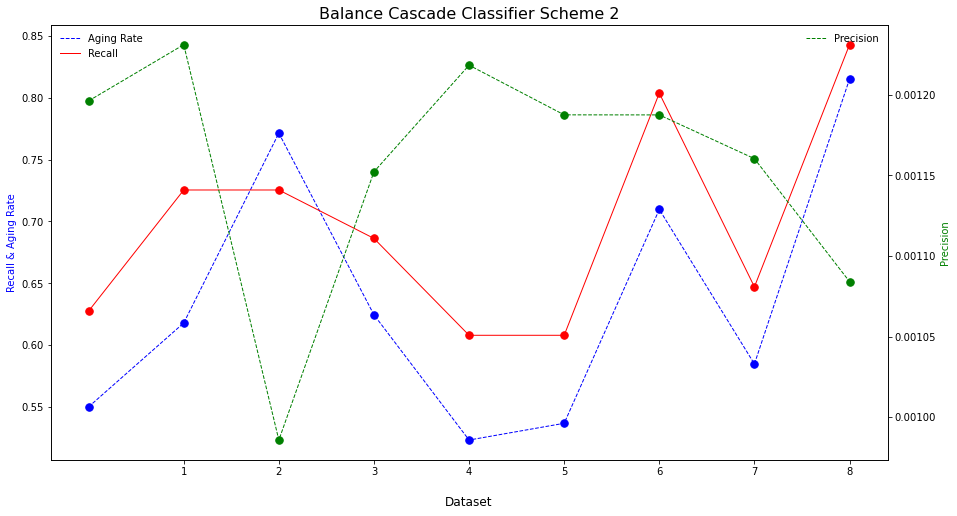

Balance Ratio  Train_OK  Train_NG    TP       FP    FN       TN  \
dataset1      20.000000   30840.0    1542.0  32.0  26720.0  19.0  21878.0   
dataset2      20.000000   30020.0    1501.0  37.0  30019.0  14.0  18579.0   
dataset3      20.000000   30360.0    1518.0  37.0  37496.0  14.0  11102.0   
dataset4      20.000000   30360.0    1518.0  35.0  30342.0  16.0  18256.0   
dataset5      20.253165   30400.0    1501.0  31.0  25414.0  20.0  23184.0   
dataset6      20.092531   30400.0    1513.0  31.0  26074.0  20.0  22524.0   
dataset7      20.000000   30400.0    1520.0  41.0  34486.0  10.0  14112.0   
dataset8      20.000000   30400.0    1520.0  33.0  28407.0  18.0  20191.0   
dataset9      20.000000    6080.0     304.0  43.0  39622.0   8.0   8976.0   

          Precision    Recall  Aging Rate  Efficiency  F1 Score     Score  
dataset1   0.001196  0.627451    0.549898    1.141031  0.001194  0.477671  
dataset2   0.001231  0.725490    0.617813    1.174287  0.001229  0.563489  
dataset3   0.000986  0.725490    0.771506    0.940356  0.000984  0.000000  
dataset4   0.001152  0.686275    0.624412    1.099074  0.001150  0.508870  
dataset5   0.001218  0.607843    0.523032    1.162152  0.001216  0.468710  
dataset6   0.001188  0.607843    0.536599    1.132770  0.001185  0.460394  
dataset7   0.001187  0.803922    0.709717    1.132736  0.001186  0.608895  
dataset8   0.001160  0.647059    0.584596    1.106848  0.001158  0.482184  
dataset9   0.001084  0.843137    0.815330    1.034105  0.001083  0.598675

In [10]:
line_chart(table_setC, title = f'Balance Cascade Classifier Scheme {scheme}')
table_setC

### Export

In [11]:
savedate = '20220419'
TPE_multi = False

table_setC['sampler'] = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
table_setC['model'] = f'BalanceCascade{scheme}_full_low'
with pd.ExcelWriter(f'{savedate}_Classifier.xlsx', mode = 'a') as writer:
    table_setC.to_excel(writer, sheet_name = f'BalanceCascade{scheme}_full_low')